**NAME: PARTHA SAKHA PAUL**

**ROLL: MA23M016**

    CS6910_assignment1

In [24]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# importing dataset
from keras.datasets import fashion_mnist

# for the confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns #for plotting the confusion matrix

# ***Question 1***

Download the fashion-MNIST dataset and plot 1 sample image for each class as shown in the grid below. Use from keras.datasets import fashion_mnist for getting the fashion mnist dataset.

In [3]:
# loading the data
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

# spliting data for validation
x_val = x_train[54000:]
y_val = y_train[54000:]
# print(x_val)
# print(y_val)
# spliting data for training
x_train = x_train[:54000]
y_train = y_train[:54000]
# print(x_train)
# print(y_train)

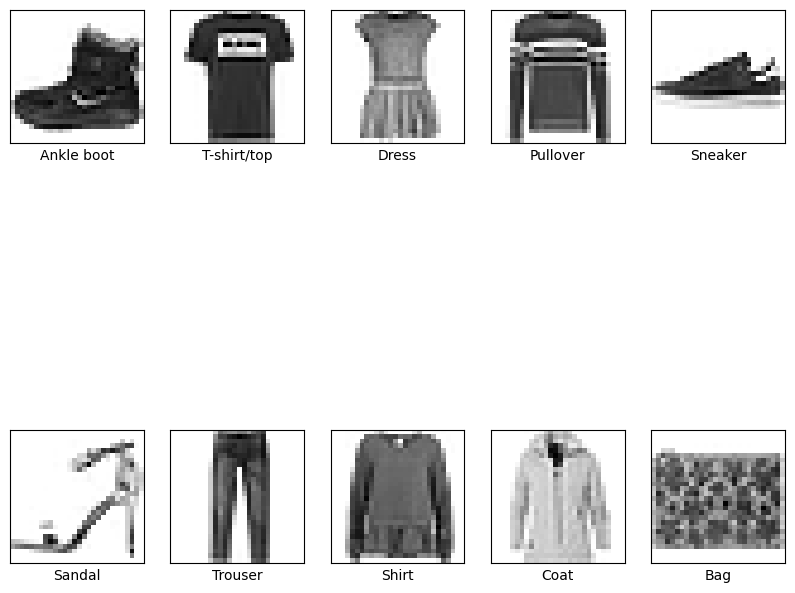

In [4]:
# labels
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
image = []
label = []
for i in range(54000):
  if len(label) >= 10:
    break;
  if class_names[y_train[i]] not in label:
      image.append(x_train[i])
      label.append(class_names[y_train[i]])

#the dimensions of the plot grid
plt.figure(figsize=(10,10))

for i in range(len(image)):
  plt.subplot(2, 5, i+1)  #plotting in a 2x5 grid
  plt.xticks([])  #remove x-ticks
  plt.yticks([])  #remove y-ticks
  plt.grid(False)  #no grid
  plt.imshow(image[i], cmap=plt.cm.binary)  #plotting the image in binary colormap
  plt.xlabel(label[i])  #x-axis label
plt.show()

In [5]:
# vectorise the data
x_train = x_train.reshape(x_train.shape[0], 784)
# print(x_train.shape)
x_val  = x_val.reshape(x_val.shape[0], 784)
x_test = x_test.reshape(x_test.shape[0], 784)

# normalize
x_train = x_train / 255.0
x_test = x_test / 255.0
x_val  = x_val / 255.0
# print(x_train)

# One hot encoding for labels
def one_hot_enc(labels, dimension=10):
    # Creating an array of zeros of shape (number of labels, number of categories)
    one_hot_labels = np.zeros((len(labels), dimension))

    one_hot_labels[np.arange(len(labels)), labels] = 1
    return one_hot_labels
#ref : https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html



print(y_train[1023])
# one-hot encoding to the datasets
y_train_encode = one_hot_enc(y_train)
y_val_encode = one_hot_enc(y_val)
y_test_encode = one_hot_enc(y_test)

print(y_train_encode[1023])  # for verifying
print(y_train_encode.shape) #verifying

7
[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
(54000, 10)


In [6]:
#all necessary functions::
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def softmax(x):
    exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
    return exp_x / np.sum(exp_x, axis=1, keepdims=True)

def sigmoid_deriv(x):
    sig = sigmoid(x)
    return sig * (1 - sig)

def relu(x):
    return np.maximum(0, x)

def relu_deriv(x):
    return np.where(x <= 0, 0, 1)

def tanh(x):
    return np.tanh(x)

def tanh_deriv(x):
    return 1 - np.tanh(x)**2

def cross_entropy(y_hat, y, sum_norm, regpara):
    m = y.shape[0]
    logyhat = np.log(y_hat)
    loss = -np.sum(y * logyhat) / m + regpara / 2 * sum_norm
    return loss

activation_functions = {
    "sigmoid": sigmoid,
    "relu": relu,
    "tanh": tanh
}

activation_derivatives = {
    "sigmoid": sigmoid_deriv,
    "relu": relu_deriv,
    "tanh": tanh_deriv
}
#ref : https://www.analyticsvidhya.com/blog/2021/04/activation-functions-and-their-derivatives-a-quick-complete-guide/

# ***Question 2***
Implement a feedforward neural network which takes images from the fashion-mnist data as input and outputs a probability distribution over the 10 classes.

Your code should be flexible such that it is easy to change the number of hidden layers and the number of neurons in each hidden layer.

In [7]:
class NeuralNetwork:
    #initialize the network with construtor
    def __init__(self, layer_sizes, activation_func="sigmoid", weight_init="random"):
        self.layer_sizes = layer_sizes
        self.activation_func = activation_func
        self.weights, self.biases = self.init_network(layer_sizes, weight_init)
        self.momenta_weights, self.momenta_biases = self.init_momenta_for_mgd()

    #initializing function
    def init_network(self, layer_sizes, weight_init):
        weights = []
        biases = []
        # i = 0 to L-1; here len(self.layer_sizes) = L+1(input_layer+hidden_layers+output_layer)
        for i in range(len(layer_sizes) - 1):
            # "xavier" weight_initialization
            if weight_init == "xavier":
                stddev = np.sqrt(2 / (layer_sizes[i] + layer_sizes[i + 1]))
            #random initialization
            else:
                stddev = 0.1  # standard deviation for random initialization

            weight = np.random.randn(layer_sizes[i], layer_sizes[i + 1]) * stddev
            bias = np.zeros((1, layer_sizes[i + 1]))
            weights.append(weight)
            biases.append(bias)
        return weights, biases

    #initializing momentums for mgd
    def init_momenta_for_mgd(self):
        momenta_weights = []
        momenta_biases = []
        for i in range(len(self.layer_sizes) - 1):
            v_weight = np.zeros((self.layer_sizes[i], self.layer_sizes[i + 1]))
            v_bias = np.zeros((1, self.layer_sizes[i + 1]))
            momenta_weights.append(v_weight)
            momenta_biases.append(v_bias)
        return momenta_weights, momenta_biases

    #forward propagation
    def feedforward(self, X):
        a = {}
        h = {"h0": X}
        # i = 1 to L; here len(self.layer_sizes) = L+1(input_layer+hidden_layers+output_layer)
        for i in range(1, len(self.layer_sizes)):
            h_previous = h["h" + str(i-1)]   #input layer(data point)
            a_current = np.dot(h_previous, self.weights[i-1]) + self.biases[i-1]
            a["a" + str(i)] = a_current
            if i == len(self.layer_sizes) - 1:  # for output layer
                h_current = softmax(a_current)
            else:
                h_current = activation_functions[self.activation_func](a_current)   #sigmoid(a_current)
            h["h" + str(i)] = h_current
        y_hat = h["h" + str(len(self.layer_sizes) - 1)]
        return h, a, y_hat

#ref:: https://medium.com/hackernoon/building-a-feedforward-neural-network-from-scratch-in-python-d3526457156b

In [27]:
layer_sizes = [784, 128, 10]

# initializing the model
model_forward = NeuralNetwork(layer_sizes, activation_func="sigmoid", weight_init="random")
_,_,y_hat = model_forward.feedforward(x_train)
print('A probability distribution over the 10 classes by feedforward NN before train:: \n',y_hat[5180])
# print(sum(y_hat[51]))
print('Corresponding labelled output:: \n',y_train_encode[5180])

A probability distribution over the 10 classes by feedforward NN before train:: 
 [0.11128688 0.09366076 0.13889323 0.13388599 0.07296209 0.07613021
 0.13558938 0.06939434 0.08086319 0.08733393]
Corresponding labelled output:: 
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


# ***Question 3***
Implement the backpropagation algorithm with support for the following optimisation functions

    sgd
    momentum based gradient descent
    nesterov accelerated gradient descent
    rmsprop
    adam
    nadam

In [9]:
# for backward propagation and the optimizers
class backward_optimizer(NeuralNetwork):
    #backward propagation
    def backward(self, h, a, y, y_hat, regpara):
        number_hidden = len(self.layer_sizes) - 2  #excluding input and output layers
        grad = self.init_grad()

        #derivative of cross-entropy w.r.t softmax function
        da = y_hat - y

        # i = L to 1; here len(self.layer_sizes) = L+1(input_layer+hidden_layers+output_layer)
        for i in reversed(range(1, len(self.layer_sizes))):
            grad["dW" + str(i)] = np.dot(h["h" + str(i-1)].T, da) / y.shape[0]   #for normalizing, dividing by y.shape[0]
            grad["dW" + str(i)] += regpara * self.weights[i-1] / y.shape[0]  #adding l2 regularization
            grad["db" + str(i)] = np.sum(da, axis=0, keepdims=True) / y.shape[0]
            if i > 1:  #no need to calculate derivatives after the first hidden layer
                dh_previous = np.dot(da, self.weights[i-1].T)
                da = dh_previous * activation_derivatives[self.activation_func](a["a" + str(i-1)])
        return grad
    #ref:: https://machinelearningmastery.com/implement-backpropagation-algorithm-scratch-python/


    #gradient initializing
    def init_grad(self):
        grad = {}
        # i = 1 to L; here len(self.layer_sizes) = L+1(input_layer+hidden_layers+output_layer)
        for i in range(1, len(self.layer_sizes)):
            grad["dW" + str(i)] = np.zeros_like(self.weights[i-1])   #initializing dw1 with W1 having all zeros
            grad["db" + str(i)] = np.zeros_like(self.biases[i-1])    #initializing db1 with b1 having all zeros
        return grad

    #vanilla GD
    def vanilla_gd(self, grads, eta):
        # i = 0 to L-1; here len(self.weights) = L (as weights = [W1,W2,W3,...], list of weights W1,W2,W3,....)
        for i in range(len(self.weights)):
            self.weights[i] -= eta * grads["dW" + str(i + 1)]   #updating W1,W2,W3 by grad_descent rule
            self.biases[i] -= eta * grads["db" + str(i + 1)]    #updating b1,b2,b3 by grad_descent rule

    #SGD
    def sgd(self, X_train, Y_train,X_val, Y_val_encode, max_epochs, eta, batch_size, regpara):
        train_datapoints = X_train.shape[0]  #train_datapoints = 54000

        for epoch in range(max_epochs):
            for start in range(0, train_datapoints, batch_size):
                end = min(start + batch_size, train_datapoints)
                X_batch = X_train[start:end]
                Y_batch = Y_train[start:end]

                # Forward prop
                h, a, y_hat = self.feedforward(X_batch)
                # print(h['h0'])

                # Backward prop
                grad = self.backward(h, a, Y_batch, y_hat, regpara)

                # Update weights and biases with SGD
                for i in range(1, len(self.layer_sizes)):
                    self.weights[i-1] -= eta * (grad["dW" + str(i)] + regpara * self.weights[i-1])
                    self.biases[i-1] -= eta * grad["db" + str(i)]

            # printing loss and accuracy at the end of each epoch
            loss, accuracy = self.loss_accuracy(X_train, Y_train, regpara)
            print(f"End of Epoch {epoch}, Loss: {loss}, Accuracy: {accuracy}")
            wandb.log({'train_loss': loss})
            wandb.log({'train_accuracy': accuracy*100 })
            wandb.log({'epoch': epoch + 1})

            # printing loss and accuracy on the validation dataset
            val_loss, val_accuracy = self.loss_accuracy(X_val, Y_val_encode, regpara)
            print(f"End of Epoch {epoch}, Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}")
            wandb.log({'val_loss': val_loss})
            wandb.log({'val_accuracy': val_accuracy*100 })

    #MGD
    def mgd(self,X_train, Y_train, X_val, Y_val_encode, max_epochs, eta, batch_size, regpara,beta=0.9):
        train_datapoints = X_train.shape[0]  #train_datapoints = 54000

        for epoch in range(max_epochs):
            for start in range(0, train_datapoints, batch_size):
                end = min(start + batch_size, train_datapoints)
                X_batch = X_train[start:end]
                Y_batch = Y_train[start:end]

                # Forward prop
                h, a, y_hat = self.feedforward(X_batch)

                # Backward prop
                grad = self.backward(h, a, Y_batch, y_hat, regpara)

                # update with momentum
                for i in range(len(self.weights)):
                    # momentum updates
                    self.momenta_weights[i] = beta * self.momenta_weights[i] + eta * (grad["dW" + str(i + 1)] + regpara * self.weights[i])
                    self.momenta_biases[i] = beta * self.momenta_biases[i] + eta * grad["db" + str(i + 1)]

                    # update weights and biases
                    self.weights[i] -= self.momenta_weights[i] + eta * regpara * self.weights[i]
                    self.biases[i] -= self.momenta_biases[i]

            # printing loss and accuracy at the end of each epoch
            loss, accuracy = self.loss_accuracy(X_train, Y_train, regpara)
            print(f"End of Epoch {epoch}, Loss: {loss}, Accuracy: {accuracy}")
            wandb.log({'train_loss': loss})
            wandb.log({'train_accuracy': accuracy*100 })
            wandb.log({'epoch': epoch + 1})

            # printing loss and accuracy on the validation dataset
            val_loss, val_accuracy = self.loss_accuracy(X_val, Y_val_encode, regpara)
            print(f"End of Epoch {epoch}, Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}")
            wandb.log({'val_loss': val_loss})
            wandb.log({'val_accuracy': val_accuracy*100 })

    #NAG
    def nag(self, X_train, Y_train, X_val, Y_val_encode, max_epochs, eta, batch_size, regpara, beta=0.9):
        train_datapoints = X_train.shape[0]

        # initializing momenta for NAG
        prev_momenta_weights = [np.zeros_like(w) for w in self.weights]
        prev_momenta_biases = [np.zeros_like(b) for b in self.biases]

        for epoch in range(max_epochs):
            for start in range(0, train_datapoints, batch_size):
                end = min(start + batch_size, train_datapoints)
                X_batch = X_train[start:end]
                Y_batch = Y_train[start:end]

                # storing original weights and biases
                original_weights = [np.copy(w) for w in self.weights]
                original_biases = [np.copy(b) for b in self.biases]

                #  NAG method
                self.weights = [w - beta * v for w, v in zip(self.weights, prev_momenta_weights)]
                self.biases = [b - beta * v for b, v in zip(self.biases, prev_momenta_biases)]

                # Forward prop with lookahead weights and biases
                h, a, y_hat = self.feedforward(X_batch)

                # Backward prop
                grads = self.backward(h, a, Y_batch, y_hat, regpara)

                # Taking original weights and biases before actual update
                self.weights = original_weights
                self.biases = original_biases

                # Updating with computed grads and momentums
                for i in range(len(self.weights)):
                    momenta_weights = beta * prev_momenta_weights[i] + eta * (grads["dW" + str(i + 1)] + regpara * self.weights[i])
                    momenta_biases = beta * prev_momenta_biases[i] + eta * grads["db" + str(i + 1)]

                    self.weights[i] -= momenta_weights
                    self.biases[i] -= momenta_biases

                    # Updating momenta for next iteration
                    prev_momenta_weights[i] = momenta_weights
                    prev_momenta_biases[i] = momenta_biases

            # printing loss and accuracy at the end of each epoch
            loss, accuracy = self.loss_accuracy(X_train, Y_train, regpara)
            print(f"End of Epoch {epoch}, Loss: {loss}, Accuracy: {accuracy}")
            wandb.log({'train_loss': loss})
            wandb.log({'train_accuracy': accuracy*100 })
            wandb.log({'epoch': epoch + 1})

            # printing loss and accuracy on the validation dataset
            val_loss, val_accuracy = self.loss_accuracy(X_val, Y_val_encode, regpara)
            print(f"End of Epoch {epoch}, Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}")
            wandb.log({'val_loss': val_loss})
            wandb.log({'val_accuracy': val_accuracy*100 })

    #RMSPROP
    def rmsprop(self, X_train, Y_train,X_val, Y_val_encode, max_epochs, eta, batch_size, regpara, beta=0.9, epsilon=1e-8):
      train_datapoints = X_train.shape[0]

      # initializing square gradients
      s_weights = [np.zeros_like(w) for w in self.weights]
      s_biases = [np.zeros_like(b) for b in self.biases]

      for epoch in range(max_epochs):
          for start in range(0, train_datapoints, batch_size):
              end = min(start + batch_size, train_datapoints)
              X_batch = X_train[start:end]
              Y_batch = Y_train[start:end]

              # Forward prop
              h, a, y_hat = self.feedforward(X_batch)

              # Backward prop
              grads = self.backward(h, a, Y_batch, y_hat, regpara)

              # updating weights and biases with RMSprop
              for i in range(len(self.weights)):
                  # updating square gradients
                  s_weights[i] = beta * s_weights[i] + (1 - beta) * np.square((grads["dW" + str(i + 1)]  + regpara * self.weights[i]))
                  s_biases[i] = beta * s_biases[i] + (1 - beta) * np.square(grads["db" + str(i + 1)])

                  # updating weights and biases
                  self.weights[i] -= eta * (grads["dW" + str(i + 1)] + regpara * self.weights[i]) / (np.sqrt(s_weights[i]) + epsilon)
                  self.biases[i] -= eta * grads["db" + str(i + 1)] / (np.sqrt(s_biases[i]) + epsilon)

          # printing loss and accuracy at the end of each epoch
          loss, accuracy = self.loss_accuracy(X_train, Y_train, regpara)
          print(f"End of Epoch {epoch}, Loss: {loss}, Accuracy: {accuracy}")
          wandb.log({'train_loss': loss})
          wandb.log({'train_accuracy': accuracy*100 })
          wandb.log({'epoch': epoch + 1})

          # printing loss and accuracy on the validation dataset
          val_loss, val_accuracy = self.loss_accuracy(X_val, Y_val_encode, regpara)
          print(f"End of Epoch {epoch}, Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}")
          wandb.log({'val_loss': val_loss})
          wandb.log({'val_accuracy': val_accuracy*100 })

    #ADAM
    def adam(self, X_train, Y_train,X_val, Y_val_encode, max_epochs, eta, batch_size, regpara, beta1=0.9, beta2=0.999, eps=1e-8):
      train_datapoints = X_train.shape[0]

      # initializing momenta (m) and velocities (v) for Adam
      m_weights = [np.zeros_like(w) for w in self.weights]
      m_biases = [np.zeros_like(b) for b in self.biases]
      v_weights = [np.zeros_like(w) for w in self.weights]
      v_biases = [np.zeros_like(b) for b in self.biases]

      for epoch in range(max_epochs):
          for start in range(0, train_datapoints, batch_size):
              end = min(start + batch_size, train_datapoints)
              X_batch = X_train[start:end]
              Y_batch = Y_train[start:end]

              # Forward prop
              h, a, y_hat = self.feedforward(X_batch)

              # Backward prop
              grads = self.backward(h, a, Y_batch, y_hat, regpara)

              # Adam updates for each layer
              for i in range(len(self.weights)):
                  # updating momenta and velocities
                  m_weights[i] = beta1 * m_weights[i] + (1 - beta1) * (grads["dW" + str(i + 1)] + regpara * self.weights[i])
                  m_biases[i] = beta1 * m_biases[i] + (1 - beta1) * grads["db" + str(i + 1)]
                  v_weights[i] = beta2 * v_weights[i] + (1 - beta2) * ((grads["dW" + str(i + 1)] + regpara * self.weights[i]) ** 2)
                  v_biases[i] = beta2 * v_biases[i] + (1 - beta2) * (grads["db" + str(i + 1)] ** 2)

                  # modified momenta and velocities
                  m_hat_weights = m_weights[i] / (1 - beta1 ** (epoch + 1))
                  m_hat_biases = m_biases[i] / (1 - beta1 ** (epoch + 1))
                  v_hat_weights = v_weights[i] / (1 - beta2 ** (epoch + 1))
                  v_hat_biases = v_biases[i] / (1 - beta2 ** (epoch + 1))

                  # updating weights and biases
                  self.weights[i] -= eta * m_hat_weights / (np.sqrt(v_hat_weights) + eps)
                  self.biases[i] -= eta * m_hat_biases / (np.sqrt(v_hat_biases) + eps)

          # print loss and accuracy at the end of each epoch
          loss, accuracy = self.loss_accuracy(X_train, Y_train, regpara)
          print(f"End of Epoch {epoch}, Loss: {loss}, Accuracy: {accuracy}")
          wandb.log({'train_accuracy': accuracy*100 })
          wandb.log({'train_loss': loss})
          wandb.log({'epoch': epoch + 1})

          # printing loss and accuracy on the validation dataset
          val_loss, val_accuracy = self.loss_accuracy(X_val, Y_val_encode, regpara)
          print(f"End of Epoch {epoch}, Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}")
          wandb.log({'val_accuracy': val_accuracy*100 })
          wandb.log({'val_loss': val_loss})

    #NADAM
    def nadam(self, X_train, Y_train,X_val, Y_val_encode, max_epochs=5, eta=0.001, batch_size=16, regpara=0, beta1=0.9, beta2=0.999, eps=1e-8):
      train_datapoints = X_train.shape[0]

      # initializing momenta (m) and velocities (v) for NAdam
      m_weights = [np.zeros_like(w) for w in self.weights]
      m_biases = [np.zeros_like(b) for b in self.biases]
      v_weights = [np.zeros_like(w) for w in self.weights]
      v_biases = [np.zeros_like(b) for b in self.biases]

      for epoch in range(max_epochs):
          for start in range(0, train_datapoints, batch_size):
              end = min(start + batch_size, train_datapoints)
              X_batch = X_train[start:end]
              Y_batch = Y_train[start:end]

              # Forward prop
              h, a, y_hat = self.feedforward(X_batch)

              # Backward prop
              grads = self.backward(h, a, Y_batch, y_hat, regpara)

              # NAdam updates for each layer
              for i in range(len(self.weights)):
                  # update momenta and velocities
                  m_weights[i] = beta1 * m_weights[i] + (1 - beta1) * (grads["dW" + str(i + 1)] + regpara * self.weights[i])
                  m_biases[i] = beta1 * m_biases[i] + (1 - beta1) * grads["db" + str(i + 1)]
                  v_weights[i] = beta2 * v_weights[i] + (1 - beta2) * ((grads["dW" + str(i + 1)] + regpara * self.weights[i]) ** 2)
                  v_biases[i] = beta2 * v_biases[i] + (1 - beta2) * (grads["db" + str(i + 1)] ** 2)

                  # modified momenta and velocities
                  m_hat_weights = m_weights[i] / (1 - beta1 ** (epoch + 1))
                  m_hat_biases = m_biases[i] / (1 - beta1 ** (epoch + 1))
                  v_hat_weights = v_weights[i] / (1 - beta2 ** (epoch + 1))
                  v_hat_biases = v_biases[i] / (1 - beta2 ** (epoch + 1))

                  # NAG rule
                  m_bar_weights = beta1 * m_hat_weights + ((1 - beta1) * (grads["dW" + str(i + 1)] + regpara * self.weights[i])) / (1 - beta1 ** (epoch + 1))
                  m_bar_biases = beta1 * m_hat_biases + ((1 - beta1) * grads["db" + str(i + 1)]) / (1 - beta1 ** (epoch + 1))

                  # updating weights and biases
                  self.weights[i] -= eta * m_bar_weights / (np.sqrt(v_hat_weights) + eps)
                  self.biases[i] -= eta * m_bar_biases / (np.sqrt(v_hat_biases) + eps)

          # printing loss and accuracy at the end of each epoch
          loss, accuracy = self.loss_accuracy(X_train, Y_train, regpara)
          print(f"End of Epoch {epoch}, Loss: {loss}, Accuracy: {accuracy}")
          wandb.log({'train_loss': loss})
          wandb.log({'train_accuracy': accuracy*100 })
          wandb.log({'epoch': epoch + 1})

          # printing loss and accuracy on the validation dataset
          val_loss, val_accuracy = self.loss_accuracy(X_val, Y_val_encode, regpara)
          print(f"End of Epoch {epoch}, Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}")
          wandb.log({'val_loss': val_loss})
          wandb.log({'val_accuracy': val_accuracy*100 })


    #loss_accuracy function
    def loss_accuracy(self, X, y, regpara=0.0):
        #for regularization we need
        sum_norm = 0
        for weight in self.weights:   #weights = [W1,W2,W3,......]
            sum_norm += np.sum(np.square(weight))

        h, a, y_hat = self.feedforward(X)
        loss = cross_entropy(y_hat, y, sum_norm, regpara)

        predictions = np.argmax(y_hat, axis=1)   #finding indices of max element in each row of y_hat
        labels = np.argmax(y, axis=1)            #finding indices of max element in each row of y
        accuracy = np.mean(predictions == labels) #mean of the above two

        return loss, accuracy

    #for training the model by the optimizers
    def train(self,optimizer,max_epochs, eta,batch_size,regpara):
        if optimizer == 'sgd':
          self.sgd(x_train, y_train_encode,x_val, y_val_encode, max_epochs, eta,batch_size, regpara)
        elif optimizer == 'momentum':
          self.mgd(x_train, y_train_encode,x_val, y_val_encode,  max_epochs, eta,batch_size, regpara, beta=0.9)
        elif optimizer == 'nesterov':
          self.nag(x_train, y_train_encode,x_val, y_val_encode,  max_epochs, eta,batch_size, regpara, beta=0.9)
        elif optimizer == 'rmsprop':
          self.rmsprop(x_train, y_train_encode,x_val, y_val_encode,  max_epochs, eta,batch_size, regpara, beta=0.9, epsilon=1e-8)
        elif optimizer == 'adam':
          self.adam(x_train, y_train_encode,x_val, y_val_encode,  max_epochs, eta, batch_size, regpara, beta1=0.9, beta2=0.999, eps=1e-8)
        elif optimizer == 'nadam':
          self.nadam(x_train, y_train_encode,x_val, y_val_encode,  max_epochs, eta, batch_size, regpara, beta1=0.9, beta2=0.999, eps=1e-8)

    from sklearn.metrics import confusion_matrix


    def predict(self, X):
        _, _, y_hat = self.feedforward(X)
        # print(y_hat.shape)
        predictions = np.argmax(y_hat, axis=1)  #probabilities to class labels
        # print(predictions.shape)
        return predictions

        predictions = predict(model, x_test)
        print(predictions[508])
        true_labels = np.argmax(y_test_encode, axis=1)
        print(true_labels[508])

        # confusion matrix
        conf_matrix = confusion_matrix(true_labels, predictions)

        print("Confusion Matrix:")
        print(conf_matrix)


        wandb.log({"conf_mat" : wandb.plot.confusion_matrix(probs=None,
                                y_true=true_labels, preds=predictions,
                                class_names=class_names)})
#ref: https://wandb.ai/wandb/plots/reports/Confusion-Matrix-Usage-and-Examples--VmlldzozMDg1NTM



In [10]:

layer_sizes = [784, 128, 64, 10]

# initializing the model
model = backward_optimizer(layer_sizes, activation_func="tanh", weight_init="xeiver")

#for verifying the results

# print(model.weights[0].shape)
# print(model.weights[1].shape)
# print(model.weights[0][5])
# print(model.weights[1][99])
# print()
# print(model.biases[0].shape)
# print(model.biases[1].shape)
# print(model.biases[0][0])
# print(model.biases[1][0])

In [ ]:
# x_train, y_train_encode are training data and labels
#sgd
model.sgd(x_train, y_train_encode,x_val,y_val_encode, eta=0.001, max_epochs=6, batch_size=16, regpara=0)

End of Epoch 0, Loss: 1.0445093471341718, Accuracy: 0.6590555555555555
End of Epoch 0, Validation Loss: 1.0324205962270583, Validation Accuracy: 0.6675
End of Epoch 1, Loss: 0.8137413472507301, Accuracy: 0.719037037037037
End of Epoch 1, Validation Loss: 0.8014337592657181, Validation Accuracy: 0.7233333333333334
End of Epoch 2, Loss: 0.7115802307223733, Accuracy: 0.7564444444444445
End of Epoch 2, Validation Loss: 0.7020683921478623, Validation Accuracy: 0.7598333333333334
End of Epoch 3, Loss: 0.6473876961512235, Accuracy: 0.7791481481481481
End of Epoch 3, Validation Loss: 0.6407786316261025, Validation Accuracy: 0.7808333333333334
End of Epoch 4, Loss: 0.6028145588532066, Accuracy: 0.7937777777777778
End of Epoch 4, Validation Loss: 0.5986916610326786, Validation Accuracy: 0.7925
End of Epoch 5, Loss: 0.5698621009071301, Accuracy: 0.8049259259259259
End of Epoch 5, Validation Loss: 0.5677996692823327, Validation Accuracy: 0.8033333333333333


In [ ]:
#mgd
model.mgd(x_train, y_train_encode, x_val,y_val_encode, eta=0.1, beta=0.9, max_epochs=11, batch_size=64, regpara=0)

End of Epoch 0, Loss: 0.4317224049692742, Accuracy: 0.8373703703703703
End of Epoch 0, Validation Loss: 0.45258376281221385, Validation Accuracy: 0.8311666666666667
End of Epoch 1, Loss: 0.4282253526785848, Accuracy: 0.8453148148148149
End of Epoch 1, Validation Loss: 0.45167811014932785, Validation Accuracy: 0.8343333333333334
End of Epoch 2, Loss: 0.4547812777037418, Accuracy: 0.8360925925925926
End of Epoch 2, Validation Loss: 0.48057320308529855, Validation Accuracy: 0.8253333333333334
End of Epoch 3, Loss: 0.44237952952164405, Accuracy: 0.8521666666666666
End of Epoch 3, Validation Loss: 0.47683564474447804, Validation Accuracy: 0.8365
End of Epoch 4, Loss: 0.4136345780035934, Accuracy: 0.8531481481481481
End of Epoch 4, Validation Loss: 0.4451536053099221, Validation Accuracy: 0.8386666666666667
End of Epoch 5, Loss: 0.38609000952841993, Accuracy: 0.858574074074074
End of Epoch 5, Validation Loss: 0.4190096321497696, Validation Accuracy: 0.8483333333333334
End of Epoch 6, Loss: 0

In [ ]:
#nag
model.nag(x_train, y_train_encode,x_val,y_val_encode,  eta=0.1, beta=0.9, max_epochs=11, batch_size=64, regpara=0)

End of Epoch 0, Loss: 0.4103547778468685, Accuracy: 0.8467962962962963
End of Epoch 0, Validation Loss: 0.436451247003777, Validation Accuracy: 0.8376666666666667
End of Epoch 1, Loss: 0.38735993743471087, Accuracy: 0.8566296296296296
End of Epoch 1, Validation Loss: 0.414439031782692, Validation Accuracy: 0.8475
End of Epoch 2, Loss: 0.38778494401247743, Accuracy: 0.8533333333333334
End of Epoch 2, Validation Loss: 0.4324840752539143, Validation Accuracy: 0.841
End of Epoch 3, Loss: 0.4049541246452592, Accuracy: 0.8492777777777778
End of Epoch 3, Validation Loss: 0.4381782539742686, Validation Accuracy: 0.8353333333333334
End of Epoch 4, Loss: 0.39048526804811134, Accuracy: 0.8544814814814815
End of Epoch 4, Validation Loss: 0.4423148199321028, Validation Accuracy: 0.8395
End of Epoch 5, Loss: 0.37339018083207687, Accuracy: 0.864537037037037
End of Epoch 5, Validation Loss: 0.41766096093622845, Validation Accuracy: 0.8506666666666667
End of Epoch 6, Loss: 0.4306193940440966, Accuracy:

In [ ]:
#rmsprop
model.rmsprop(x_train, y_train_encode,x_val,y_val_encode, eta=0.001, beta=0.9, max_epochs=11, batch_size=64, regpara=0.00, epsilon=1e-8)

End of Epoch 0, Loss: 0.3090382167040861, Accuracy: 0.8874814814814814
End of Epoch 0, Validation Loss: 0.36941710956386775, Validation Accuracy: 0.8716666666666667
End of Epoch 1, Loss: 0.29451417342525, Accuracy: 0.8920370370370371
End of Epoch 1, Validation Loss: 0.357456379865134, Validation Accuracy: 0.8723333333333333
End of Epoch 2, Loss: 0.2840782873845581, Accuracy: 0.8974444444444445
End of Epoch 2, Validation Loss: 0.35444313925515836, Validation Accuracy: 0.877
End of Epoch 3, Loss: 0.28064745695394633, Accuracy: 0.897962962962963
End of Epoch 3, Validation Loss: 0.35815269269904204, Validation Accuracy: 0.8741666666666666
End of Epoch 4, Loss: 0.2664202079489842, Accuracy: 0.9024444444444445
End of Epoch 4, Validation Loss: 0.350251392051385, Validation Accuracy: 0.8776666666666667
End of Epoch 5, Loss: 0.260678568819971, Accuracy: 0.9047222222222222
End of Epoch 5, Validation Loss: 0.3533901559466714, Validation Accuracy: 0.8793333333333333
End of Epoch 6, Loss: 0.2521572

In [ ]:
#adam
model.adam(x_train, y_train_encode,x_val,y_val_encode, eta=0.001, beta1=0.9, beta2=0.999, max_epochs=11, batch_size=16, regpara=0.00, eps=1e-8)

End of Epoch 0, Loss: 0.3731516713897054, Accuracy: 0.865537037037037
End of Epoch 0, Validation Loss: 0.39121842321100964, Validation Accuracy: 0.856
End of Epoch 1, Loss: 0.33179312617421597, Accuracy: 0.8800740740740741
End of Epoch 1, Validation Loss: 0.3581934320802164, Validation Accuracy: 0.8691666666666666
End of Epoch 2, Loss: 0.30763268452484244, Accuracy: 0.8888148148148148
End of Epoch 2, Validation Loss: 0.34202973936834463, Validation Accuracy: 0.8741666666666666
End of Epoch 3, Loss: 0.2906050175160047, Accuracy: 0.8957037037037037
End of Epoch 3, Validation Loss: 0.33208185415212466, Validation Accuracy: 0.878
End of Epoch 4, Loss: 0.27742371050921816, Accuracy: 0.9002962962962963
End of Epoch 4, Validation Loss: 0.32537565275722885, Validation Accuracy: 0.8788333333333334
End of Epoch 5, Loss: 0.26664042823513323, Accuracy: 0.9039259259259259
End of Epoch 5, Validation Loss: 0.3206667237736713, Validation Accuracy: 0.8813333333333333
End of Epoch 6, Loss: 0.25737953345

In [ ]:
#nadam
model.nadam(x_train, y_train_encode,x_val,y_val_encode, eta=0.001, beta1=0.9, beta2=0.999, max_epochs=6, batch_size=16, regpara=0.00, eps=1e-8)

End of Epoch 0, Loss: 0.3684601598064879, Accuracy: 0.8670740740740741
End of Epoch 0, Validation Loss: 0.3838425023359573, Validation Accuracy: 0.8596666666666667
End of Epoch 1, Loss: 0.3266124767266428, Accuracy: 0.8831851851851852
End of Epoch 1, Validation Loss: 0.3505625907732296, Validation Accuracy: 0.8725
End of Epoch 2, Loss: 0.30357320058333165, Accuracy: 0.8915740740740741
End of Epoch 2, Validation Loss: 0.33564977347560493, Validation Accuracy: 0.8796666666666667
End of Epoch 3, Loss: 0.28737427893115625, Accuracy: 0.8966296296296297
End of Epoch 3, Validation Loss: 0.32693123787852746, Validation Accuracy: 0.8821666666666667
End of Epoch 4, Loss: 0.2745764936643581, Accuracy: 0.9011111111111111
End of Epoch 4, Validation Loss: 0.32117609439090006, Validation Accuracy: 0.8828333333333334
End of Epoch 5, Loss: 0.2637331234101661, Accuracy: 0.9047962962962963
End of Epoch 5, Validation Loss: 0.31709320847862793, Validation Accuracy: 0.8853333333333333


# ***Question 4***
    Use the sweep functionality provided by wandb to find the best values for the hyperparameters listed below. Use the standard train/test split of fashion_mnist (use (X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()). Keep 10% of the training data aside as validation data for this hyperparameter search. Here are some suggestions for different values to try for hyperparameters. As you can quickly see that this leads to an exponential number of combinations. You will have to think about strategies to do this hyperparameter search efficiently. Check out the options provided by wandb.sweep and write down what strategy you chose and why.

    number of epochs: 5, 10
    number of hidden layers: 3, 4, 5
    size of every hidden layer: 32, 64, 128
    weight decay (L2 regularisation): 0, 0.0005, 0.5
    learning rate: 1e-3, 1 e-4
    optimizer: sgd, momentum, nesterov, rmsprop, adam, nadam
    batch size: 16, 32, 64
    weight initialisation: random, Xavier
    activation functions: sigmoid, tanh, ReLU
    wandb will automatically generate the following plots. Paste these plots below using the "Add Panel to Report" feature. Make sure you use meaningful names for each sweep (e.g. hl_3_bs_16_ac_tanh to indicate that there were 3 hidden layers, batch size was 16 and activation function was ReLU) instead of using the default names (whole-sweep, kind-sweep) given by wandb.

In [11]:
!pip install wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 195.4/195.4 kB 11.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 263.5/263.5 kB 12.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 7.9 MB/s eta 0:00:00


In [12]:
import wandb
import numpy as np
from types import SimpleNamespace
import random

In [13]:
key = input('Enter your API:')
wandb.login(key=key)

Enter your API:25c2257eaf6c22aa056893db14da4ee2bf0a531a


wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [17]:
sweep_config = {
    'method': 'bayes',   #for bayes:
                            #ref: https://wandb.ai/wandb_fc/articles/reports/What-Is-Bayesian-Hyperparameter-Optimization-With-Tutorial---Vmlldzo1NDQyNzcw
    'name' : 'sweep cross entropy bayes',
    'metric': {
      'name': 'val_accuracy',
      'goal': 'maximize'
    },
    'parameters': {
        'epochs': {
            'values': [5,10]
        },
        'hidden_layers':{
            'values':[3,4,5]
        },
         'hidden_size':{
            'values':[32,64,128]
        },
        'weight_decay':{
            'values':[0, 0.0005, 0.5]
        },
        'learning_rate': {
            'values': [1e-3, 1e-4]
        },
        'optimizer': {
            'values': ['rmsprop', 'nadam','adam', 'nesterov','momentum','sgd']
        },
        'batch_size':{
            'values':[16,32,64]
        },
        'weight_init': {
            'values': ['xavier','random']
        },
        'activation': {
            'values': ['tanh','relu','sigmoid']
        },
    }
}

sweep_id = wandb.sweep(sweep=sweep_config, project='Deep_leraning_A1')

Create sweep with ID: 1madcyjq
Sweep URL: https://wandb.ai/parthasakhapaul/Deep_leraning_A1/sweeps/1madcyjq


In [18]:
def main():


    with wandb.init() as run:

        run_name="-ac_"+wandb.config.activation+"-hs_"+str(wandb.config.hidden_size)+"-epc_"+str(wandb.config.epochs)+"-hl_"+str(wandb.config.hidden_layers)+"-regu_"+str(wandb.config.weight_decay)+"-eta_"+str(wandb.config.learning_rate)+"-optmz_"+wandb.config.optimizer+"-batch_"+str(wandb.config.batch_size)+"-wght_"+wandb.config.weight_init
        wandb.run.name=run_name
        model = backward_optimizer(layer_sizes=[784,wandb.config.hidden_layers,10], activation_func=wandb.config.activation, weight_init=wandb.config.weight_init)
        model.train(wandb.config.optimizer,wandb.config.epochs,wandb.config.learning_rate,batch_size = wandb.config.batch_size,regpara = wandb.config.weight_decay)



wandb.agent(sweep_id, function=main,count=300) # calls main function for count number of times.
wandb.finish()

wandb: Agent Starting Run: k3miztrc with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


End of Epoch 0, Loss: 1.3412457112825185, Accuracy: 0.6129444444444444
End of Epoch 0, Validation Loss: 1.3380234495777037, Validation Accuracy: 0.6171666666666666
End of Epoch 1, Loss: 1.0977599015701103, Accuracy: 0.6593703703703704
End of Epoch 1, Validation Loss: 1.0938942988424607, Validation Accuracy: 0.66
End of Epoch 2, Loss: 0.9779417918744915, Accuracy: 0.6815740740740741
End of Epoch 2, Validation Loss: 0.9746268803420587, Validation Accuracy: 0.679
End of Epoch 3, Loss: 0.9030432306925081, Accuracy: 0.6998703703703704
End of Epoch 3, Validation Loss: 0.9012886825581423, Validation Accuracy: 0.6988333333333333
End of Epoch 4, Loss: 0.8497621999897226, Accuracy: 0.7171666666666666
End of Epoch 4, Validation Loss: 0.8492425684982909, Validation Accuracy: 0.7181666666666666
End of Epoch 5, Loss: 0.8101633634040761, Accuracy: 0.7338703703703704
End of Epoch 5, Validation Loss: 0.8102809288757531, Validation Accuracy: 0.7328333333333333
End of Epoch 6, Loss: 0.7788636214582136, A

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▃▄▅▅▆▇▇██
train_loss,█▅▄▃▃▂▂▂▁▁
val_accuracy,▁▃▄▅▅▆▇▇██
val_loss,█▅▄▃▃▂▂▁▁▁
epoch,10
train_accuracy,78.36667
train_loss,0.70608
val_accuracy,77.66667
val_loss,0.71059


wandb: Agent Starting Run: i02t4riz with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: random


End of Epoch 0, Loss: 2.9811645280708277, Accuracy: 0.2055925925925926
End of Epoch 0, Validation Loss: 2.97989282157131, Validation Accuracy: 0.20616666666666666
End of Epoch 1, Loss: 2.336596659488159, Accuracy: 0.269037037037037
End of Epoch 1, Validation Loss: 2.3348874568500566, Validation Accuracy: 0.2755
End of Epoch 2, Loss: 2.2135088687131583, Accuracy: 0.2863703703703704
End of Epoch 2, Validation Loss: 2.211529846971851, Validation Accuracy: 0.2921666666666667
End of Epoch 3, Loss: 2.188730644743227, Accuracy: 0.2975925925925926
End of Epoch 3, Validation Loss: 2.186715037411951, Validation Accuracy: 0.30533333333333335
End of Epoch 4, Loss: 2.1804950376562835, Accuracy: 0.30792592592592594
End of Epoch 4, Validation Loss: 2.178509836075617, Validation Accuracy: 0.31716666666666665
End of Epoch 5, Loss: 2.1760114300271747, Accuracy: 0.32387037037037036
End of Epoch 5, Validation Loss: 2.17407436255649, Validation Accuracy: 0.332
End of Epoch 6, Loss: 2.1727730568918626, Accu

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▄▅▅▆▆▇▇██
train_loss,█▂▁▁▁▁▁▁▁▁
val_accuracy,▁▄▅▅▆▆▇▇██
val_loss,█▂▁▁▁▁▁▁▁▁
epoch,10
train_accuracy,36.01296
train_loss,2.16547
val_accuracy,36.9
val_loss,2.16377


wandb: Agent Starting Run: vple11pj with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


End of Epoch 0, Loss: 1.345248106781835, Accuracy: 0.5295740740740741
End of Epoch 0, Validation Loss: 1.332734652754353, Validation Accuracy: 0.5443333333333333
End of Epoch 1, Loss: 1.2135519831919803, Accuracy: 0.5557037037037037
End of Epoch 1, Validation Loss: 1.2002057516449525, Validation Accuracy: 0.5705
End of Epoch 2, Loss: 1.1549041028769718, Accuracy: 0.5736666666666667
End of Epoch 2, Validation Loss: 1.1419446443391001, Validation Accuracy: 0.5791666666666667
End of Epoch 3, Loss: 1.117126188412484, Accuracy: 0.5877037037037037
End of Epoch 3, Validation Loss: 1.104606736193342, Validation Accuracy: 0.5953333333333334
End of Epoch 4, Loss: 1.0881177284041996, Accuracy: 0.5995
End of Epoch 4, Validation Loss: 1.0758275421655277, Validation Accuracy: 0.6076666666666667
End of Epoch 5, Loss: 1.063864724931802, Accuracy: 0.6083333333333333
End of Epoch 5, Validation Loss: 1.0515985579155267, Validation Accuracy: 0.617
End of Epoch 6, Loss: 1.043441946806864, Accuracy: 0.61372

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▃▄▅▆▇▇▇██
train_loss,█▅▄▃▃▂▂▂▁▁
val_accuracy,▁▃▄▅▆▇▇███
val_loss,█▅▄▃▃▂▂▂▁▁
epoch,10
train_accuracy,62.79074
train_loss,0.99626
val_accuracy,63.2
val_loss,0.98684


wandb: Agent Starting Run: riccjla9 with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


End of Epoch 0, Loss: 3.579104530508361, Accuracy: 0.2818888888888889
End of Epoch 0, Validation Loss: 3.5762910441651514, Validation Accuracy: 0.2815
End of Epoch 1, Loss: 2.7561923910547517, Accuracy: 0.2836296296296296
End of Epoch 1, Validation Loss: 2.752663553203753, Validation Accuracy: 0.2855
End of Epoch 2, Loss: 2.4307167690283955, Accuracy: 0.3136111111111111
End of Epoch 2, Validation Loss: 2.4272387965225444, Validation Accuracy: 0.327
End of Epoch 3, Loss: 2.2950242934306333, Accuracy: 0.35288888888888886
End of Epoch 3, Validation Loss: 2.2918522609711145, Validation Accuracy: 0.36616666666666664
End of Epoch 4, Loss: 2.235704003246341, Accuracy: 0.35418518518518516
End of Epoch 4, Validation Loss: 2.2328418486958634, Validation Accuracy: 0.364
End of Epoch 5, Loss: 2.20816823758362, Accuracy: 0.35214814814814815
End of Epoch 5, Validation Loss: 2.205564907001772, Validation Accuracy: 0.36183333333333334
End of Epoch 6, Loss: 2.1943453906545223, Accuracy: 0.3511481481481

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▁▄███████
train_loss,█▄▂▂▁▁▁▁▁▁
val_accuracy,▁▁▅███▇▇▇▇
val_loss,█▄▂▂▁▁▁▁▁▁
epoch,10
train_accuracy,35.26481
train_loss,2.17879
val_accuracy,35.86667
val_loss,2.17691


wandb: Agent Starting Run: d1rsgkpk with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


End of Epoch 0, Loss: 3.332155341167331, Accuracy: 0.319
End of Epoch 0, Validation Loss: 3.329599171245221, Validation Accuracy: 0.3215
End of Epoch 1, Loss: 2.7172219588269835, Accuracy: 0.38172222222222224
End of Epoch 1, Validation Loss: 2.7152244518440916, Validation Accuracy: 0.3865
End of Epoch 2, Loss: 2.467204245597032, Accuracy: 0.3942222222222222
End of Epoch 2, Validation Loss: 2.465896513761445, Validation Accuracy: 0.39816666666666667
End of Epoch 3, Loss: 2.361855744108473, Accuracy: 0.4136666666666667
End of Epoch 3, Validation Loss: 2.361048711814188, Validation Accuracy: 0.4161666666666667
End of Epoch 4, Loss: 2.3161568519514026, Accuracy: 0.43022222222222223
End of Epoch 4, Validation Loss: 2.315665988986805, Validation Accuracy: 0.43


epoch,▁▃▅▆█
train_accuracy,▁▅▆▇█
train_loss,█▄▂▁▁
val_accuracy,▁▅▆▇█
val_loss,█▄▂▁▁
epoch,5
train_accuracy,43.02222
train_loss,2.31616
val_accuracy,43.0
val_loss,2.31567


wandb: Agent Starting Run: wim88fzd with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.5
wandb: 	weight_init: random


End of Epoch 0, Loss: 7.930567898520644, Accuracy: 0.1032037037037037
End of Epoch 0, Validation Loss: 7.932346792353954, Validation Accuracy: 0.097
End of Epoch 1, Loss: 6.2076511585940874, Accuracy: 0.17037037037037037
End of Epoch 1, Validation Loss: 6.207162173912909, Validation Accuracy: 0.16883333333333334
End of Epoch 2, Loss: 5.0141825249270635, Accuracy: 0.20251851851851851
End of Epoch 2, Validation Loss: 5.013064679738061, Validation Accuracy: 0.20116666666666666
End of Epoch 3, Loss: 4.182537160518706, Accuracy: 0.24457407407407408
End of Epoch 3, Validation Loss: 4.181268937266536, Validation Accuracy: 0.24066666666666667
End of Epoch 4, Loss: 3.6018356868583314, Accuracy: 0.28125925925925926
End of Epoch 4, Validation Loss: 3.600604794298817, Validation Accuracy: 0.275
End of Epoch 5, Loss: 3.195845867379753, Accuracy: 0.30716666666666664
End of Epoch 5, Validation Loss: 3.1947323945966177, Validation Accuracy: 0.3
End of Epoch 6, Loss: 2.911699475324472, Accuracy: 0.3215

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▃▄▅▇▇████
train_loss,█▆▄▃▂▂▂▁▁▁
val_accuracy,▁▃▄▅▆▇████
val_loss,█▆▄▃▂▂▂▁▁▁
epoch,10
train_accuracy,32.40185
train_loss,2.47499
val_accuracy,32.23333
val_loss,2.47442


wandb: Agent Starting Run: 0z9eluh8 with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nesterov
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


End of Epoch 0, Loss: 2.1108301740416184, Accuracy: 0.1428148148148148
End of Epoch 0, Validation Loss: 2.0983841656370497, Validation Accuracy: 0.14516666666666667
End of Epoch 1, Loss: 1.983857954226932, Accuracy: 0.2451111111111111
End of Epoch 1, Validation Loss: 1.9687645083414345, Validation Accuracy: 0.25266666666666665
End of Epoch 2, Loss: 1.839518309757034, Accuracy: 0.2854814814814815
End of Epoch 2, Validation Loss: 1.824823318402743, Validation Accuracy: 0.2891666666666667
End of Epoch 3, Loss: 1.7208112267524183, Accuracy: 0.3778148148148148
End of Epoch 3, Validation Loss: 1.7086132928234896, Validation Accuracy: 0.37466666666666665
End of Epoch 4, Loss: 1.6379476947695222, Accuracy: 0.3992222222222222
End of Epoch 4, Validation Loss: 1.6264570634447617, Validation Accuracy: 0.406


epoch,▁▃▅▆█
train_accuracy,▁▄▅▇█
train_loss,█▆▄▂▁
val_accuracy,▁▄▅▇█
val_loss,█▆▄▂▁
epoch,5
train_accuracy,39.92222
train_loss,1.63795
val_accuracy,40.6
val_loss,1.62646


wandb: Agent Starting Run: amhag9rq with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nesterov
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


End of Epoch 0, Loss: 2.824897187350953, Accuracy: 0.4385
End of Epoch 0, Validation Loss: 2.8234462707957273, Validation Accuracy: 0.45566666666666666
End of Epoch 1, Loss: 2.3804441159911254, Accuracy: 0.44253703703703706
End of Epoch 1, Validation Loss: 2.379353735391062, Validation Accuracy: 0.45916666666666667
End of Epoch 2, Loss: 2.2943620527038306, Accuracy: 0.42685185185185187
End of Epoch 2, Validation Loss: 2.2936797072828217, Validation Accuracy: 0.43916666666666665
End of Epoch 3, Loss: 2.2706366398850997, Accuracy: 0.33766666666666667
End of Epoch 3, Validation Loss: 2.270413170365068, Validation Accuracy: 0.353
End of Epoch 4, Loss: 2.2606236777352144, Accuracy: 0.29827777777777775
End of Epoch 4, Validation Loss: 2.2608604570159523, Validation Accuracy: 0.3095


epoch,▁▃▅▆█
train_accuracy,██▇▃▁
train_loss,█▂▁▁▁
val_accuracy,██▇▃▁
val_loss,█▂▁▁▁
epoch,5
train_accuracy,29.82778
train_loss,2.26062
val_accuracy,30.95
val_loss,2.26086


wandb: Agent Starting Run: 9z6dlcr6 with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nesterov
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


End of Epoch 0, Loss: 0.9320519762851339, Accuracy: 0.6561296296296296
End of Epoch 0, Validation Loss: 0.9261728190150998, Validation Accuracy: 0.6553333333333333
End of Epoch 1, Loss: 0.8405158402401187, Accuracy: 0.6930925925925926
End of Epoch 1, Validation Loss: 0.8359802954502477, Validation Accuracy: 0.6905
End of Epoch 2, Loss: 0.8007702796151513, Accuracy: 0.7093703703703703
End of Epoch 2, Validation Loss: 0.7970950466925718, Validation Accuracy: 0.7031666666666667
End of Epoch 3, Loss: 0.7749215641226576, Accuracy: 0.7190740740740741
End of Epoch 3, Validation Loss: 0.7721971731784185, Validation Accuracy: 0.7136666666666667
End of Epoch 4, Loss: 0.7555754731572718, Accuracy: 0.7271851851851852
End of Epoch 4, Validation Loss: 0.7538286805192373, Validation Accuracy: 0.7225
End of Epoch 5, Loss: 0.7400396494745801, Accuracy: 0.7349074074074075
End of Epoch 5, Validation Loss: 0.7392474317139455, Validation Accuracy: 0.7291666666666666
End of Epoch 6, Loss: 0.7270502090669455

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▄▅▅▆▇▇▇██
train_loss,█▅▄▃▃▂▂▂▁▁
val_accuracy,▁▄▅▅▆▇▇███
val_loss,█▅▄▃▃▂▂▂▁▁
epoch,10
train_accuracy,75.44444
train_loss,0.69825
val_accuracy,74.66667
val_loss,0.70073


wandb: Agent Starting Run: tut6wddv with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


End of Epoch 0, Loss: 1.2279702452197072, Accuracy: 0.5187037037037037
End of Epoch 0, Validation Loss: 1.2131717068317251, Validation Accuracy: 0.5373333333333333
End of Epoch 1, Loss: 0.9250686217736496, Accuracy: 0.6611481481481482
End of Epoch 1, Validation Loss: 0.9066415164598134, Validation Accuracy: 0.6701666666666667
End of Epoch 2, Loss: 0.7875363534068648, Accuracy: 0.6997592592592593
End of Epoch 2, Validation Loss: 0.7725689480000361, Validation Accuracy: 0.7156666666666667
End of Epoch 3, Loss: 0.737684587662349, Accuracy: 0.7265925925925926
End of Epoch 3, Validation Loss: 0.7252716493773739, Validation Accuracy: 0.7348333333333333
End of Epoch 4, Loss: 0.7044030296728431, Accuracy: 0.7441481481481481
End of Epoch 4, Validation Loss: 0.6951261451169319, Validation Accuracy: 0.7495
End of Epoch 5, Loss: 0.6793035330099206, Accuracy: 0.7543703703703704
End of Epoch 5, Validation Loss: 0.6731019474548509, Validation Accuracy: 0.76
End of Epoch 6, Loss: 0.6596055709105186, A

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▅▆▇▇▇████
train_loss,█▅▃▂▂▂▁▁▁▁
val_accuracy,▁▅▆▇▇▇████
val_loss,█▄▃▂▂▂▁▁▁▁
epoch,10
train_accuracy,78.06111
train_loss,0.6216
val_accuracy,77.98333
val_loss,0.62348


wandb: Agent Starting Run: 8f2l2xjh with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0
wandb: 	weight_init: random


End of Epoch 0, Loss: 2.269091732712801, Accuracy: 0.15064814814814814
End of Epoch 0, Validation Loss: 2.270033146040549, Validation Accuracy: 0.14166666666666666
End of Epoch 1, Loss: 2.206965188180705, Accuracy: 0.17703703703703705
End of Epoch 1, Validation Loss: 2.2079803950063197, Validation Accuracy: 0.18283333333333332
End of Epoch 2, Loss: 2.0885133457218727, Accuracy: 0.1749814814814815
End of Epoch 2, Validation Loss: 2.0897655526057837, Validation Accuracy: 0.18533333333333332
End of Epoch 3, Loss: 1.9264166957519178, Accuracy: 0.2857037037037037
End of Epoch 3, Validation Loss: 1.9285615771022582, Validation Accuracy: 0.2936666666666667
End of Epoch 4, Loss: 1.7535102587838465, Accuracy: 0.32287037037037036
End of Epoch 4, Validation Loss: 1.7563041528883778, Validation Accuracy: 0.3323333333333333
End of Epoch 5, Loss: 1.5998526243323536, Accuracy: 0.48194444444444445
End of Epoch 5, Validation Loss: 1.6020525806194468, Validation Accuracy: 0.49066666666666664
End of Epoc

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▁▁▃▄▆▇▇██
train_loss,██▇▆▅▄▃▂▁▁
val_accuracy,▁▂▂▃▄▆▇▇██
val_loss,██▇▆▅▄▃▂▂▁
epoch,10
train_accuracy,60.5963
train_loss,1.19935
val_accuracy,61.76667
val_loss,1.19505


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: a5nkwbvj with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nesterov
wandb: 	weight_decay: 0.5
wandb: 	weight_init: random


End of Epoch 0, Loss: 2.3038440442550594, Accuracy: 0.13362962962962963
End of Epoch 0, Validation Loss: 2.3038716291096804, Validation Accuracy: 0.1325
End of Epoch 1, Loss: 2.3026060411286378, Accuracy: 0.09996296296296296
End of Epoch 1, Validation Loss: 2.302661917091357, Validation Accuracy: 0.10033333333333333
End of Epoch 2, Loss: 2.30259898902541, Accuracy: 0.09996296296296296
End of Epoch 2, Validation Loss: 2.3027042696448947, Validation Accuracy: 0.10033333333333333
End of Epoch 3, Loss: 2.3025975047854397, Accuracy: 0.10083333333333333
End of Epoch 3, Validation Loss: 2.302730250745422, Validation Accuracy: 0.0925
End of Epoch 4, Loss: 2.3025970763996444, Accuracy: 0.10083333333333333
End of Epoch 4, Validation Loss: 2.3027441723755318, Validation Accuracy: 0.0925
End of Epoch 5, Loss: 2.302596942456452, Accuracy: 0.10083333333333333
End of Epoch 5, Validation Loss: 2.302751489006272, Validation Accuracy: 0.0925
End of Epoch 6, Loss: 2.302596896448295, Accuracy: 0.100833333

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,█▁▁▁▁▁▁▁▁▁
train_loss,█▁▁▁▁▁▁▁▁▁
val_accuracy,█▂▂▁▁▁▁▁▁▁
val_loss,█▁▁▁▁▂▂▂▂▂
epoch,10
train_accuracy,10.08333
train_loss,2.3026
val_accuracy,9.25
val_loss,2.30276


wandb: Agent Starting Run: w45hwumx with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


End of Epoch 0, Loss: 1.017295124202495, Accuracy: 0.6093888888888889
End of Epoch 0, Validation Loss: 1.0112043053235473, Validation Accuracy: 0.6133333333333333
End of Epoch 1, Loss: 0.8232915246002033, Accuracy: 0.669537037037037
End of Epoch 1, Validation Loss: 0.818183249170954, Validation Accuracy: 0.6731666666666667
End of Epoch 2, Loss: 0.7441730673393692, Accuracy: 0.7211296296296297
End of Epoch 2, Validation Loss: 0.7414864904308899, Validation Accuracy: 0.7261666666666666
End of Epoch 3, Loss: 0.6892845577619752, Accuracy: 0.7531851851851852
End of Epoch 3, Validation Loss: 0.6892798550153831, Validation Accuracy: 0.753
End of Epoch 4, Loss: 0.6526152007529057, Accuracy: 0.7728518518518519
End of Epoch 4, Validation Loss: 0.6542273197191238, Validation Accuracy: 0.7703333333333333
End of Epoch 5, Loss: 0.6270422719303829, Accuracy: 0.786074074074074
End of Epoch 5, Validation Loss: 0.6296855528773597, Validation Accuracy: 0.7835
End of Epoch 6, Loss: 0.607777786995631, Accu

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▃▅▆▇▇▇███
train_loss,█▅▄▃▂▂▂▁▁▁
val_accuracy,▁▃▅▆▇▇▇███
val_loss,█▅▄▃▂▂▂▁▁▁
epoch,10
train_accuracy,80.99259
train_loss,0.57058
val_accuracy,80.55
val_loss,0.57548


wandb: Agent Starting Run: 62f6d724 with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.5
wandb: 	weight_init: random


End of Epoch 0, Loss: 9.93885133217821, Accuracy: 0.08157407407407408
End of Epoch 0, Validation Loss: 9.938536152865824, Validation Accuracy: 0.079
End of Epoch 1, Loss: 9.305701303430173, Accuracy: 0.08259259259259259
End of Epoch 1, Validation Loss: 9.305458564513021, Validation Accuracy: 0.08
End of Epoch 2, Loss: 8.725500851063412, Accuracy: 0.08475925925925926
End of Epoch 2, Validation Loss: 8.725306013208481, Validation Accuracy: 0.08233333333333333
End of Epoch 3, Loss: 8.193753024163929, Accuracy: 0.08601851851851852
End of Epoch 3, Validation Loss: 8.193613893884208, Validation Accuracy: 0.08466666666666667
End of Epoch 4, Loss: 7.706320467842973, Accuracy: 0.0885
End of Epoch 4, Validation Loss: 7.706232027223116, Validation Accuracy: 0.08616666666666667
End of Epoch 5, Loss: 7.2594494319109835, Accuracy: 0.09129629629629629
End of Epoch 5, Validation Loss: 7.259387463235571, Validation Accuracy: 0.0885
End of Epoch 6, Loss: 6.849673132760312, Accuracy: 0.09368518518518519


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▁▂▃▄▅▅▆▇█
train_loss,█▇▆▅▄▃▃▂▂▁
val_accuracy,▁▁▃▄▄▅▆▆▇█
val_loss,█▇▆▅▄▃▃▂▂▁
epoch,10
train_accuracy,10.06481
train_loss,5.81283
val_accuracy,9.38333
val_loss,5.81269


wandb: Agent Starting Run: z7owztjc with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


End of Epoch 0, Loss: 2.2468354549896854, Accuracy: 0.10011111111111111
End of Epoch 0, Validation Loss: 2.246109380014389, Validation Accuracy: 0.09983333333333333
End of Epoch 1, Loss: 2.159537348729821, Accuracy: 0.15237037037037038
End of Epoch 1, Validation Loss: 2.1574288155253085, Validation Accuracy: 0.14983333333333335
End of Epoch 2, Loss: 2.0385431940812677, Accuracy: 0.23744444444444446
End of Epoch 2, Validation Loss: 2.0341852166147887, Validation Accuracy: 0.232
End of Epoch 3, Loss: 1.9114366680452077, Accuracy: 0.27594444444444444
End of Epoch 3, Validation Loss: 1.9039774908232545, Validation Accuracy: 0.27416666666666667
End of Epoch 4, Loss: 1.8140809955140538, Accuracy: 0.3330925925925926
End of Epoch 4, Validation Loss: 1.8040285367804971, Validation Accuracy: 0.32616666666666666
End of Epoch 5, Loss: 1.7463449026784152, Accuracy: 0.3484259259259259
End of Epoch 5, Validation Loss: 1.7346470625316008, Validation Accuracy: 0.3426666666666667
End of Epoch 6, Loss: 1

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▂▄▅▆▆▇▇██
train_loss,█▇▆▄▃▃▂▂▁▁
val_accuracy,▁▂▄▅▆▆▆▇██
val_loss,█▇▆▄▃▃▂▂▁▁
epoch,10
train_accuracy,44.05741
train_loss,1.59894
val_accuracy,44.25
val_loss,1.58362


wandb: Agent Starting Run: 2ygfnfgf with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


End of Epoch 0, Loss: 0.9154599588292137, Accuracy: 0.6925925925925925
End of Epoch 0, Validation Loss: 0.9154879389935795, Validation Accuracy: 0.6911666666666667
End of Epoch 1, Loss: 0.8010393406709924, Accuracy: 0.7391481481481481
End of Epoch 1, Validation Loss: 0.7994770890038179, Validation Accuracy: 0.7396666666666667
End of Epoch 2, Loss: 0.7522024959652204, Accuracy: 0.7537037037037037
End of Epoch 2, Validation Loss: 0.7490266474095316, Validation Accuracy: 0.757
End of Epoch 3, Loss: 0.7253505122586505, Accuracy: 0.7626666666666667
End of Epoch 3, Validation Loss: 0.7221768946734579, Validation Accuracy: 0.7665
End of Epoch 4, Loss: 0.7070310955578728, Accuracy: 0.7688888888888888
End of Epoch 4, Validation Loss: 0.7042322943529798, Validation Accuracy: 0.7718333333333334
End of Epoch 5, Loss: 0.6932064889903871, Accuracy: 0.7736851851851851
End of Epoch 5, Validation Loss: 0.690838265436112, Validation Accuracy: 0.7751666666666667
End of Epoch 6, Loss: 0.6821207523829499, 

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▅▆▆▇▇▇███
train_loss,█▅▄▃▂▂▂▁▁▁
val_accuracy,▁▄▆▆▇▇▇███
val_loss,█▅▃▃▂▂▂▁▁▁
epoch,10
train_accuracy,78.46296
train_loss,0.6583
val_accuracy,78.85
val_loss,0.65748


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 65zu4z98 with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nesterov
wandb: 	weight_decay: 0
wandb: 	weight_init: random


End of Epoch 0, Loss: 1.674421877246497, Accuracy: 0.3683148148148148
End of Epoch 0, Validation Loss: 1.6654177787791313, Validation Accuracy: 0.37233333333333335
End of Epoch 1, Loss: 1.37937623803436, Accuracy: 0.46235185185185185
End of Epoch 1, Validation Loss: 1.3705116374483683, Validation Accuracy: 0.4618333333333333
End of Epoch 2, Loss: 1.0501564766550118, Accuracy: 0.598462962962963
End of Epoch 2, Validation Loss: 1.0483392036406467, Validation Accuracy: 0.6028333333333333
End of Epoch 3, Loss: 0.8600279910396945, Accuracy: 0.6494074074074074
End of Epoch 3, Validation Loss: 0.8571588761341236, Validation Accuracy: 0.6555
End of Epoch 4, Loss: 0.7952382150028303, Accuracy: 0.696037037037037
End of Epoch 4, Validation Loss: 0.7916789193510749, Validation Accuracy: 0.6995
End of Epoch 5, Loss: 0.7448822876609988, Accuracy: 0.7303148148148149
End of Epoch 5, Validation Loss: 0.7406084994449125, Validation Accuracy: 0.7325
End of Epoch 6, Loss: 0.7080161626698999, Accuracy: 0.7

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▃▅▆▇▇▇███
train_loss,█▆▄▂▂▂▁▁▁▁
val_accuracy,▁▃▅▆▇▇████
val_loss,█▆▄▂▂▂▁▁▁▁
epoch,10
train_accuracy,78.17963
train_loss,0.64303
val_accuracy,78.0
val_loss,0.64232


wandb: Agent Starting Run: l86xn3ev with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


End of Epoch 0, Loss: 1.641096902577043, Accuracy: 0.3380740740740741
End of Epoch 0, Validation Loss: 1.6444962929703446, Validation Accuracy: 0.3358333333333333
End of Epoch 1, Loss: 1.0506439262488656, Accuracy: 0.6175555555555555
End of Epoch 1, Validation Loss: 1.0427403702762912, Validation Accuracy: 0.6235
End of Epoch 2, Loss: 0.9121962542968685, Accuracy: 0.6464074074074074
End of Epoch 2, Validation Loss: 0.9054602260038624, Validation Accuracy: 0.6446666666666667
End of Epoch 3, Loss: 0.8598060480773588, Accuracy: 0.6684814814814815
End of Epoch 3, Validation Loss: 0.8558041388837275, Validation Accuracy: 0.6646666666666666
End of Epoch 4, Loss: 0.822576878693021, Accuracy: 0.6888148148148148
End of Epoch 4, Validation Loss: 0.8205301946205638, Validation Accuracy: 0.686
End of Epoch 5, Loss: 0.7857959726970929, Accuracy: 0.7132592592592593
End of Epoch 5, Validation Loss: 0.7843569272789597, Validation Accuracy: 0.71
End of Epoch 6, Loss: 0.7454892996059062, Accuracy: 0.737

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▅▆▆▇▇▇███
train_loss,█▄▃▂▂▂▂▁▁▁
val_accuracy,▁▆▆▆▇▇▇███
val_loss,█▄▃▂▂▂▂▁▁▁
epoch,10
train_accuracy,77.62407
train_loss,0.65937
val_accuracy,77.25
val_loss,0.66255


wandb: Agent Starting Run: r1o9clvp with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


End of Epoch 0, Loss: 2.259445260286322, Accuracy: 0.15927777777777777
End of Epoch 0, Validation Loss: 2.258175713659578, Validation Accuracy: 0.161
End of Epoch 1, Loss: 2.1835306441273437, Accuracy: 0.2343888888888889
End of Epoch 1, Validation Loss: 2.181150311726665, Validation Accuracy: 0.24133333333333334
End of Epoch 2, Loss: 2.0808493829332986, Accuracy: 0.24572222222222223
End of Epoch 2, Validation Loss: 2.076576137947854, Validation Accuracy: 0.24716666666666667
End of Epoch 3, Loss: 1.9753756952400625, Accuracy: 0.26737037037037037
End of Epoch 3, Validation Loss: 1.9693367433966005, Validation Accuracy: 0.263
End of Epoch 4, Loss: 1.8821673320407517, Accuracy: 0.2783888888888889
End of Epoch 4, Validation Loss: 1.8751229168899863, Validation Accuracy: 0.27566666666666667
End of Epoch 5, Loss: 1.800175611216494, Accuracy: 0.29638888888888887
End of Epoch 5, Validation Loss: 1.7934268920600702, Validation Accuracy: 0.2981666666666667
End of Epoch 6, Loss: 1.72801811274056, 

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▃▃▄▄▅▆▇██
train_loss,█▇▆▅▄▃▃▂▁▁
val_accuracy,▁▃▃▄▄▅▆▇██
val_loss,█▇▆▅▄▃▃▂▁▁
epoch,10
train_accuracy,43.15556
train_loss,1.56955
val_accuracy,43.03333
val_loss,1.56681


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 6amo27du with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nesterov
wandb: 	weight_decay: 0
wandb: 	weight_init: random


End of Epoch 0, Loss: 2.117144505347548, Accuracy: 0.18351851851851853
End of Epoch 0, Validation Loss: 2.1095260960750135, Validation Accuracy: 0.1815
End of Epoch 1, Loss: 1.9130837686677442, Accuracy: 0.20785185185185184
End of Epoch 1, Validation Loss: 1.9054821903956194, Validation Accuracy: 0.2165
End of Epoch 2, Loss: 1.4599327407710272, Accuracy: 0.4366111111111111
End of Epoch 2, Validation Loss: 1.4515233284282931, Validation Accuracy: 0.4495
End of Epoch 3, Loss: 1.2614678666914818, Accuracy: 0.5304629629629629
End of Epoch 3, Validation Loss: 1.2548354051692656, Validation Accuracy: 0.5428333333333333
End of Epoch 4, Loss: 1.1303156295306955, Accuracy: 0.5797777777777777
End of Epoch 4, Validation Loss: 1.1214592737483136, Validation Accuracy: 0.5846666666666667
End of Epoch 5, Loss: 1.0459910180867884, Accuracy: 0.6197592592592592
End of Epoch 5, Validation Loss: 1.03902190681172, Validation Accuracy: 0.6241666666666666
End of Epoch 6, Loss: 0.9938134062833145, Accuracy: 0

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▁▅▆▇▇▇███
train_loss,█▇▄▃▂▂▁▁▁▁
val_accuracy,▁▁▅▆▇▇▇███
val_loss,█▇▄▃▂▂▁▁▁▁
epoch,10
train_accuracy,67.89444
train_loss,0.91096
val_accuracy,67.88333
val_loss,0.9081


wandb: Agent Starting Run: zq3mrr2u with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


End of Epoch 0, Loss: 1.1087732017564544, Accuracy: 0.5614629629629629
End of Epoch 0, Validation Loss: 1.109904346598761, Validation Accuracy: 0.5598333333333333
End of Epoch 1, Loss: 0.8814224686274085, Accuracy: 0.6909814814814815
End of Epoch 1, Validation Loss: 0.87894015685371, Validation Accuracy: 0.6928333333333333
End of Epoch 2, Loss: 0.8374842988140133, Accuracy: 0.7029074074074074
End of Epoch 2, Validation Loss: 0.8361014133252923, Validation Accuracy: 0.703
End of Epoch 3, Loss: 0.812307651174268, Accuracy: 0.7116296296296296
End of Epoch 3, Validation Loss: 0.8119298875535098, Validation Accuracy: 0.71
End of Epoch 4, Loss: 0.7948371842012476, Accuracy: 0.7182407407407407
End of Epoch 4, Validation Loss: 0.7950998679865724, Validation Accuracy: 0.7143333333333334
End of Epoch 5, Loss: 0.7814934072921691, Accuracy: 0.7234259259259259
End of Epoch 5, Validation Loss: 0.782269346829447, Validation Accuracy: 0.721
End of Epoch 6, Loss: 0.7705633609323149, Accuracy: 0.7280370

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▆▆▇▇▇▇███
train_loss,█▄▃▂▂▂▁▁▁▁
val_accuracy,▁▆▇▇▇▇████
val_loss,█▄▃▂▂▂▁▁▁▁
epoch,10
train_accuracy,74.15741
train_loss,0.74478
val_accuracy,73.83333
val_loss,0.74714


wandb: Agent Starting Run: umwwavp2 with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nesterov
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


End of Epoch 0, Loss: 1.3302258250813472, Accuracy: 0.47424074074074074
End of Epoch 0, Validation Loss: 1.3231953991063308, Validation Accuracy: 0.47683333333333333
End of Epoch 1, Loss: 0.9070542418641229, Accuracy: 0.6810185185185185
End of Epoch 1, Validation Loss: 0.8924511580773382, Validation Accuracy: 0.6856666666666666
End of Epoch 2, Loss: 0.7588596597872963, Accuracy: 0.7420555555555556
End of Epoch 2, Validation Loss: 0.7496650758199945, Validation Accuracy: 0.7525
End of Epoch 3, Loss: 0.688978222453265, Accuracy: 0.7648333333333334
End of Epoch 3, Validation Loss: 0.68501969619119, Validation Accuracy: 0.7706666666666667
End of Epoch 4, Loss: 0.6513244433324072, Accuracy: 0.7777962962962963
End of Epoch 4, Validation Loss: 0.6506167997382034, Validation Accuracy: 0.7818333333333334
End of Epoch 5, Loss: 0.6268599166704125, Accuracy: 0.7863703703703704
End of Epoch 5, Validation Loss: 0.6282023194840388, Validation Accuracy: 0.789
End of Epoch 6, Loss: 0.6087125511853486, 

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▅▇▇▇█████
train_loss,█▄▃▂▂▂▁▁▁▁
val_accuracy,▁▅▇▇▇█████
val_loss,█▄▃▂▂▁▁▁▁▁
epoch,10
train_accuracy,80.85926
train_loss,0.57146
val_accuracy,80.76667
val_loss,0.57685


wandb: Agent Starting Run: 4flqexkj with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


End of Epoch 0, Loss: 1.2045201191200448, Accuracy: 0.5761666666666667
End of Epoch 0, Validation Loss: 1.203125227470899, Validation Accuracy: 0.5751666666666667
End of Epoch 1, Loss: 1.0314031054175121, Accuracy: 0.6600555555555555
End of Epoch 1, Validation Loss: 1.031056195624805, Validation Accuracy: 0.6613333333333333
End of Epoch 2, Loss: 0.9093570632120049, Accuracy: 0.7142222222222222
End of Epoch 2, Validation Loss: 0.9093035748876427, Validation Accuracy: 0.7138333333333333
End of Epoch 3, Loss: 0.8127980603715863, Accuracy: 0.7479074074074074
End of Epoch 3, Validation Loss: 0.8162658537728095, Validation Accuracy: 0.7485
End of Epoch 4, Loss: 0.7447542065270897, Accuracy: 0.7618333333333334
End of Epoch 4, Validation Loss: 0.7512370630511868, Validation Accuracy: 0.763
End of Epoch 5, Loss: 0.6996612553007129, Accuracy: 0.7717777777777778
End of Epoch 5, Validation Loss: 0.7082673258628025, Validation Accuracy: 0.7716666666666666
End of Epoch 6, Loss: 0.6684060201305294, A

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▄▅▇▇▇████
train_loss,█▆▄▃▃▂▂▁▁▁
val_accuracy,▁▄▆▇▇▇████
val_loss,█▆▄▃▂▂▂▁▁▁
epoch,10
train_accuracy,79.30741
train_loss,0.61641
val_accuracy,79.01667
val_loss,0.6291


wandb: Agent Starting Run: 9onthw3e with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nesterov
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


End of Epoch 0, Loss: 0.8971590576721445, Accuracy: 0.661537037037037
End of Epoch 0, Validation Loss: 0.8836958986013765, Validation Accuracy: 0.676
End of Epoch 1, Loss: 0.7438652123113001, Accuracy: 0.73
End of Epoch 1, Validation Loss: 0.7383014963709064, Validation Accuracy: 0.7368333333333333
End of Epoch 2, Loss: 0.6688903510971417, Accuracy: 0.755425925925926
End of Epoch 2, Validation Loss: 0.6691507559683145, Validation Accuracy: 0.7551666666666667
End of Epoch 3, Loss: 0.6234384936302975, Accuracy: 0.7755185185185185
End of Epoch 3, Validation Loss: 0.62678129959561, Validation Accuracy: 0.7723333333333333
End of Epoch 4, Loss: 0.5945437471290238, Accuracy: 0.793537037037037
End of Epoch 4, Validation Loss: 0.600455953307395, Validation Accuracy: 0.7888333333333334
End of Epoch 5, Loss: 0.5743712337103536, Accuracy: 0.8025740740740741
End of Epoch 5, Validation Loss: 0.5820499526990631, Validation Accuracy: 0.7978333333333333
End of Epoch 6, Loss: 0.5589738461746704, Accurac

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▄▅▆▇▇▇███
train_loss,█▅▄▃▂▂▂▁▁▁
val_accuracy,▁▄▅▆▇▇████
val_loss,█▅▄▃▂▂▂▁▁▁
epoch,10
train_accuracy,82.1
train_loss,0.5291
val_accuracy,80.96667
val_loss,0.53939


wandb: Agent Starting Run: 7104mwgh with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nesterov
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


End of Epoch 0, Loss: 1.2246414727643902, Accuracy: 0.5975
End of Epoch 0, Validation Loss: 1.22008032608612, Validation Accuracy: 0.6011666666666666
End of Epoch 1, Loss: 0.9941672684942111, Accuracy: 0.6415555555555555
End of Epoch 1, Validation Loss: 0.9913345609848139, Validation Accuracy: 0.6468333333333334
End of Epoch 2, Loss: 0.8496028851360878, Accuracy: 0.7358703703703704
End of Epoch 2, Validation Loss: 0.8461706697459603, Validation Accuracy: 0.7428333333333333
End of Epoch 3, Loss: 0.7487025114277241, Accuracy: 0.7620370370370371
End of Epoch 3, Validation Loss: 0.7477731000198813, Validation Accuracy: 0.7676666666666667
End of Epoch 4, Loss: 0.6912922022641919, Accuracy: 0.7768518518518519
End of Epoch 4, Validation Loss: 0.6939596567860435, Validation Accuracy: 0.7768333333333334
End of Epoch 5, Loss: 0.658233423248379, Accuracy: 0.7854444444444444
End of Epoch 5, Validation Loss: 0.6635972997579267, Validation Accuracy: 0.7833333333333333
End of Epoch 6, Loss: 0.6373505

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▃▆▇▇█████
train_loss,█▅▄▃▂▂▁▁▁▁
val_accuracy,▁▃▆▇▇█████
val_loss,█▅▄▃▂▂▁▁▁▁
epoch,10
train_accuracy,79.8
train_loss,0.60363
val_accuracy,79.46667
val_loss,0.6175


wandb: Agent Starting Run: 1y2qhyxt with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nesterov
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


End of Epoch 0, Loss: 1.5064857479841727, Accuracy: 0.5563888888888889
End of Epoch 0, Validation Loss: 1.5061806171980012, Validation Accuracy: 0.56
End of Epoch 1, Loss: 1.1514026733532463, Accuracy: 0.6418703703703704
End of Epoch 1, Validation Loss: 1.1470774650149347, Validation Accuracy: 0.6431666666666667
End of Epoch 2, Loss: 0.9827015180371177, Accuracy: 0.6631481481481482
End of Epoch 2, Validation Loss: 0.9778110836267722, Validation Accuracy: 0.666
End of Epoch 3, Loss: 0.8921690094632618, Accuracy: 0.6882777777777778
End of Epoch 3, Validation Loss: 0.8885834557971772, Validation Accuracy: 0.6906666666666667
End of Epoch 4, Loss: 0.8300695018135507, Accuracy: 0.7133518518518519
End of Epoch 4, Validation Loss: 0.8279356212504853, Validation Accuracy: 0.716
End of Epoch 5, Loss: 0.7816609321972018, Accuracy: 0.7349259259259259
End of Epoch 5, Validation Loss: 0.7813711840446671, Validation Accuracy: 0.734
End of Epoch 6, Loss: 0.7429168839309044, Accuracy: 0.750833333333333

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▄▄▅▆▇▇▇██
train_loss,█▅▄▃▂▂▂▁▁▁
val_accuracy,▁▄▄▅▆▇▇▇██
val_loss,█▅▄▃▂▂▂▁▁▁
epoch,10
train_accuracy,78.07037
train_loss,0.66694
val_accuracy,77.26667
val_loss,0.67199


wandb: Agent Starting Run: o6ckt0lb with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


End of Epoch 0, Loss: 1.3327023448213622, Accuracy: 0.5830185185185185
End of Epoch 0, Validation Loss: 1.3288946086728637, Validation Accuracy: 0.589
End of Epoch 1, Loss: 1.1677598713792403, Accuracy: 0.609037037037037
End of Epoch 1, Validation Loss: 1.1620542336648847, Validation Accuracy: 0.6181666666666666
End of Epoch 2, Loss: 1.0787190887032634, Accuracy: 0.6228333333333333
End of Epoch 2, Validation Loss: 1.0734735754384883, Validation Accuracy: 0.6296666666666667
End of Epoch 3, Loss: 1.0209423383262417, Accuracy: 0.6316296296296297
End of Epoch 3, Validation Loss: 1.0162057271739635, Validation Accuracy: 0.6391666666666667
End of Epoch 4, Loss: 0.9787052217575677, Accuracy: 0.6408888888888888
End of Epoch 4, Validation Loss: 0.974430311740144, Validation Accuracy: 0.6493333333333333
End of Epoch 5, Loss: 0.9446425386208732, Accuracy: 0.6527962962962963
End of Epoch 5, Validation Loss: 0.9408702792186981, Validation Accuracy: 0.6611666666666667
End of Epoch 6, Loss: 0.9128665

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▃▃▄▄▅▆▇██
train_loss,█▆▄▄▃▃▂▂▁▁
val_accuracy,▁▃▃▄▅▅▇███
val_loss,█▆▄▄▃▃▂▂▁▁
epoch,10
train_accuracy,70.13704
train_loss,0.83136
val_accuracy,70.66667
val_loss,0.83206


wandb: Agent Starting Run: ua2snvtu with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


End of Epoch 0, Loss: 2.171549114299485, Accuracy: 0.3090925925925926
End of Epoch 0, Validation Loss: 2.1742225305646135, Validation Accuracy: 0.3035
End of Epoch 1, Loss: 1.9309557989563637, Accuracy: 0.3581666666666667
End of Epoch 1, Validation Loss: 1.9343221531743002, Validation Accuracy: 0.35683333333333334
End of Epoch 2, Loss: 1.7440886051168123, Accuracy: 0.48787037037037034
End of Epoch 2, Validation Loss: 1.7466500088617956, Validation Accuracy: 0.488
End of Epoch 3, Loss: 1.599628967192988, Accuracy: 0.5684814814814815
End of Epoch 3, Validation Loss: 1.6012399124368886, Validation Accuracy: 0.5773333333333334
End of Epoch 4, Loss: 1.485937479702237, Accuracy: 0.6016666666666667
End of Epoch 4, Validation Loss: 1.4866574534637835, Validation Accuracy: 0.6118333333333333
End of Epoch 5, Loss: 1.3944286653053364, Accuracy: 0.6283333333333333
End of Epoch 5, Validation Loss: 1.394417655471692, Validation Accuracy: 0.6426666666666667
End of Epoch 6, Loss: 1.319432830523481, Ac

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▂▄▆▇▇▇███
train_loss,█▆▅▄▃▃▂▂▁▁
val_accuracy,▁▂▄▆▇▇████
val_loss,█▆▅▄▃▃▂▂▁▁
epoch,10
train_accuracy,67.09074
train_loss,1.16073
val_accuracy,67.76667
val_loss,1.15943


wandb: Agent Starting Run: biy4f5g7 with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


End of Epoch 0, Loss: 1.5524213422696573, Accuracy: 0.4662962962962963
End of Epoch 0, Validation Loss: 1.5377297141590953, Validation Accuracy: 0.4715
End of Epoch 1, Loss: 1.3706139273722944, Accuracy: 0.4838703703703704
End of Epoch 1, Validation Loss: 1.35513930706315, Validation Accuracy: 0.48833333333333334
End of Epoch 2, Loss: 1.226191473024001, Accuracy: 0.5188703703703703
End of Epoch 2, Validation Loss: 1.2144723809737803, Validation Accuracy: 0.5321666666666667
End of Epoch 3, Loss: 1.0879067756245981, Accuracy: 0.5755185185185185
End of Epoch 3, Validation Loss: 1.0768597991288715, Validation Accuracy: 0.5916666666666667
End of Epoch 4, Loss: 1.0198475322008178, Accuracy: 0.6065925925925926
End of Epoch 4, Validation Loss: 1.0102844163436402, Validation Accuracy: 0.6183333333333333
End of Epoch 5, Loss: 0.9772915668180437, Accuracy: 0.6292407407407408
End of Epoch 5, Validation Loss: 0.9693165509739144, Validation Accuracy: 0.6396666666666667
End of Epoch 6, Loss: 0.946452

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▁▂▄▅▅▆▆██
train_loss,█▆▅▄▃▃▂▂▁▁
val_accuracy,▁▁▃▄▅▅▆▆██
val_loss,█▆▅▄▃▃▂▂▁▁
epoch,10
train_accuracy,74.63148
train_loss,0.79367
val_accuracy,75.45
val_loss,0.79435


wandb: Agent Starting Run: 9feeuvao with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


End of Epoch 0, Loss: 1.2713930056186693, Accuracy: 0.546074074074074
End of Epoch 0, Validation Loss: 1.2584879836767098, Validation Accuracy: 0.558
End of Epoch 1, Loss: 0.9382058030019628, Accuracy: 0.6340925925925925
End of Epoch 1, Validation Loss: 0.9285180864645809, Validation Accuracy: 0.6443333333333333
End of Epoch 2, Loss: 0.8101135595452942, Accuracy: 0.689037037037037
End of Epoch 2, Validation Loss: 0.8045921035091934, Validation Accuracy: 0.6928333333333333
End of Epoch 3, Loss: 0.736293798812914, Accuracy: 0.7265
End of Epoch 3, Validation Loss: 0.7343495681412523, Validation Accuracy: 0.7305
End of Epoch 4, Loss: 0.6856849175773214, Accuracy: 0.754537037037037
End of Epoch 4, Validation Loss: 0.6868105585507592, Validation Accuracy: 0.7545
End of Epoch 5, Loss: 0.6497992451630209, Accuracy: 0.7737407407407407
End of Epoch 5, Validation Loss: 0.6530082643156352, Validation Accuracy: 0.7703333333333333
End of Epoch 6, Loss: 0.6236374781344612, Accuracy: 0.785703703703703

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▃▅▆▇▇▇███
train_loss,█▅▃▃▂▂▁▁▁▁
val_accuracy,▁▃▅▆▇▇▇███
val_loss,█▅▃▃▂▂▁▁▁▁
epoch,10
train_accuracy,80.76111
train_loss,0.57736
val_accuracy,80.31667
val_loss,0.58448


wandb: Agent Starting Run: l3wuim2g with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nesterov
wandb: 	weight_decay: 0
wandb: 	weight_init: random


End of Epoch 0, Loss: 1.6587790248209844, Accuracy: 0.4802962962962963
End of Epoch 0, Validation Loss: 1.658625831822261, Validation Accuracy: 0.48083333333333333
End of Epoch 1, Loss: 1.2030029252911096, Accuracy: 0.5813888888888888
End of Epoch 1, Validation Loss: 1.1922175487607896, Validation Accuracy: 0.5825
End of Epoch 2, Loss: 1.0176403512358094, Accuracy: 0.6324814814814815
End of Epoch 2, Validation Loss: 1.0054999429734546, Validation Accuracy: 0.636
End of Epoch 3, Loss: 0.9137828549718644, Accuracy: 0.6776666666666666
End of Epoch 3, Validation Loss: 0.9032133130288265, Validation Accuracy: 0.6788333333333333
End of Epoch 4, Loss: 0.8383696347926552, Accuracy: 0.7028703703703704
End of Epoch 4, Validation Loss: 0.8299982648461053, Validation Accuracy: 0.7006666666666667
End of Epoch 5, Loss: 0.7839476895973934, Accuracy: 0.7174259259259259
End of Epoch 5, Validation Loss: 0.7778580327517426, Validation Accuracy: 0.714
End of Epoch 6, Loss: 0.7437870875916074, Accuracy: 0.

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▃▅▆▆▇▇▇██
train_loss,█▅▃▃▂▂▂▁▁▁
val_accuracy,▁▃▅▆▆▇▇▇██
val_loss,█▅▃▃▂▂▁▁▁▁
epoch,10
train_accuracy,77.27778
train_loss,0.66936
val_accuracy,76.65
val_loss,0.66919


wandb: Agent Starting Run: rpc4smgl with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: random


End of Epoch 0, Loss: 1.5624672721850033, Accuracy: 0.453537037037037
End of Epoch 0, Validation Loss: 1.5589421738735, Validation Accuracy: 0.4625
End of Epoch 1, Loss: 1.4022254741057272, Accuracy: 0.49662962962962964
End of Epoch 1, Validation Loss: 1.3980376623936417, Validation Accuracy: 0.49666666666666665
End of Epoch 2, Loss: 1.3081760473265314, Accuracy: 0.49766666666666665
End of Epoch 2, Validation Loss: 1.3038515085472986, Validation Accuracy: 0.49883333333333335
End of Epoch 3, Loss: 1.2431813984839868, Accuracy: 0.5042037037037037
End of Epoch 3, Validation Loss: 1.2388726856417267, Validation Accuracy: 0.5048333333333334
End of Epoch 4, Loss: 1.1948709402870514, Accuracy: 0.5120740740740741
End of Epoch 4, Validation Loss: 1.1906359722152378, Validation Accuracy: 0.5111666666666667
End of Epoch 5, Loss: 1.157170309476327, Accuracy: 0.5230185185185185
End of Epoch 5, Validation Loss: 1.152983372920888, Validation Accuracy: 0.5201666666666667
End of Epoch 6, Loss: 1.126416

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▄▄▄▅▅▆▆▇█
train_loss,█▆▅▄▃▂▂▂▁▁
val_accuracy,▁▃▃▄▄▅▆▆▇█
val_loss,█▆▄▄▃▂▂▂▁▁
epoch,10
train_accuracy,56.90556
train_loss,1.05311
val_accuracy,56.73333
val_loss,1.04967


wandb: Agent Starting Run: bb6d0kam with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


End of Epoch 0, Loss: 1.0767467491816647, Accuracy: 0.6932407407407407
End of Epoch 0, Validation Loss: 1.074272471806088, Validation Accuracy: 0.7008333333333333
End of Epoch 1, Loss: 0.8461437138478884, Accuracy: 0.7243518518518518
End of Epoch 1, Validation Loss: 0.845181815212807, Validation Accuracy: 0.7285
End of Epoch 2, Loss: 0.7571915337393569, Accuracy: 0.7403888888888889
End of Epoch 2, Validation Loss: 0.758501965265773, Validation Accuracy: 0.7441666666666666
End of Epoch 3, Loss: 0.7100480420700692, Accuracy: 0.7512037037037037
End of Epoch 3, Validation Loss: 0.7141921315997237, Validation Accuracy: 0.7536666666666667
End of Epoch 4, Loss: 0.681175644935567, Accuracy: 0.7593518518518518
End of Epoch 4, Validation Loss: 0.6881425694917757, Validation Accuracy: 0.7575
End of Epoch 5, Loss: 0.6623780974026225, Accuracy: 0.7649444444444444
End of Epoch 5, Validation Loss: 0.671773826341603, Validation Accuracy: 0.7611666666666667
End of Epoch 6, Loss: 0.6495223001499876, Acc

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▄▅▆▇▇▇███
train_loss,█▄▃▂▂▂▁▁▁▁
val_accuracy,▁▄▆▇▇▇▇███
val_loss,█▄▃▂▂▁▁▁▁▁
epoch,10
train_accuracy,77.5037
train_loss,0.62904
val_accuracy,76.78333
val_loss,0.64661


wandb: Agent Starting Run: qwji4e4x with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


End of Epoch 0, Loss: 1.4712344318950157, Accuracy: 0.5452962962962963
End of Epoch 0, Validation Loss: 1.4665116153847377, Validation Accuracy: 0.5471666666666667
End of Epoch 1, Loss: 1.1592714740161363, Accuracy: 0.6365925925925926
End of Epoch 1, Validation Loss: 1.1504209164916157, Validation Accuracy: 0.6456666666666667
End of Epoch 2, Loss: 0.9956206915536008, Accuracy: 0.6698888888888889
End of Epoch 2, Validation Loss: 0.9868754795196084, Validation Accuracy: 0.672
End of Epoch 3, Loss: 0.8999565267269191, Accuracy: 0.6905
End of Epoch 3, Validation Loss: 0.8922135293954161, Validation Accuracy: 0.695
End of Epoch 4, Loss: 0.8367803190302796, Accuracy: 0.707
End of Epoch 4, Validation Loss: 0.8303285631810549, Validation Accuracy: 0.7088333333333333
End of Epoch 5, Loss: 0.7910210748164649, Accuracy: 0.7188703703703704
End of Epoch 5, Validation Loss: 0.7856785100512274, Validation Accuracy: 0.7211666666666666
End of Epoch 6, Loss: 0.7563899177076485, Accuracy: 0.7267407407407

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▄▅▆▆▇▇▇██
train_loss,█▅▄▃▂▂▂▁▁▁
val_accuracy,▁▄▅▆▇▇▇███
val_loss,█▅▄▃▂▂▂▁▁▁
epoch,10
train_accuracy,75.38148
train_loss,0.6906
val_accuracy,74.88333
val_loss,0.68851


wandb: Agent Starting Run: tac5oz3u with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


End of Epoch 0, Loss: 0.8947874284924803, Accuracy: 0.6672777777777777
End of Epoch 0, Validation Loss: 0.8864904505699156, Validation Accuracy: 0.6688333333333333
End of Epoch 1, Loss: 0.6991985707962926, Accuracy: 0.7504814814814815
End of Epoch 1, Validation Loss: 0.6977159795503663, Validation Accuracy: 0.7516666666666667
End of Epoch 2, Loss: 0.6279596874806604, Accuracy: 0.7859814814814815
End of Epoch 2, Validation Loss: 0.6309360890777536, Validation Accuracy: 0.7805
End of Epoch 3, Loss: 0.5903949341851764, Accuracy: 0.8002962962962963
End of Epoch 3, Validation Loss: 0.5964637802522749, Validation Accuracy: 0.7905
End of Epoch 4, Loss: 0.5677393844956489, Accuracy: 0.8089259259259259
End of Epoch 4, Validation Loss: 0.5759579947014636, Validation Accuracy: 0.8001666666666667
End of Epoch 5, Loss: 0.5522210315370353, Accuracy: 0.814
End of Epoch 5, Validation Loss: 0.562046285162685, Validation Accuracy: 0.8061666666666667
End of Epoch 6, Loss: 0.5406749160847236, Accuracy: 0.

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▅▆▇▇▇████
train_loss,█▄▃▂▂▂▁▁▁▁
val_accuracy,▁▅▆▇▇█████
val_loss,█▄▃▂▂▂▁▁▁▁
epoch,10
train_accuracy,82.58889
train_loss,0.51827
val_accuracy,81.46667
val_loss,0.53206


wandb: Agent Starting Run: 03zw4n6s with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


End of Epoch 0, Loss: 0.7852373178389309, Accuracy: 0.7153518518518519
End of Epoch 0, Validation Loss: 0.7714656204724288, Validation Accuracy: 0.7155
End of Epoch 1, Loss: 0.6669842523247611, Accuracy: 0.7754629629629629
End of Epoch 1, Validation Loss: 0.661387219569897, Validation Accuracy: 0.7756666666666666
End of Epoch 2, Loss: 0.6090873285805348, Accuracy: 0.7962777777777778
End of Epoch 2, Validation Loss: 0.6088091416022642, Validation Accuracy: 0.792
End of Epoch 3, Loss: 0.5776086676210497, Accuracy: 0.8058888888888889
End of Epoch 3, Validation Loss: 0.5804231340659676, Validation Accuracy: 0.8006666666666666
End of Epoch 4, Loss: 0.5584892525056394, Accuracy: 0.8122222222222222
End of Epoch 4, Validation Loss: 0.5633899110871825, Validation Accuracy: 0.8111666666666667
End of Epoch 5, Loss: 0.5452838782900533, Accuracy: 0.8167222222222222
End of Epoch 5, Validation Loss: 0.5517237600510325, Validation Accuracy: 0.814
End of Epoch 6, Loss: 0.5353943658336672, Accuracy: 0.8

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▅▆▇▇▇████
train_loss,█▅▃▃▂▂▂▁▁▁
val_accuracy,▁▅▆▇▇█████
val_loss,█▅▃▃▂▂▁▁▁▁
epoch,10
train_accuracy,82.81111
train_loss,0.51581
val_accuracy,82.08333
val_loss,0.52641


wandb: Agent Starting Run: vy37ci9w with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


End of Epoch 0, Loss: 1.1328059778038488, Accuracy: 0.5843888888888888
End of Epoch 0, Validation Loss: 1.1220975572525829, Validation Accuracy: 0.598
End of Epoch 1, Loss: 0.8430529918937182, Accuracy: 0.6734259259259259
End of Epoch 1, Validation Loss: 0.8337301530730932, Validation Accuracy: 0.6836666666666666
End of Epoch 2, Loss: 0.7634383655525894, Accuracy: 0.7149074074074074
End of Epoch 2, Validation Loss: 0.7572419898459518, Validation Accuracy: 0.7186666666666667
End of Epoch 3, Loss: 0.7167675659103183, Accuracy: 0.7438888888888889
End of Epoch 3, Validation Loss: 0.713365312071336, Validation Accuracy: 0.7488333333333334
End of Epoch 4, Loss: 0.6829584915906677, Accuracy: 0.7643333333333333
End of Epoch 4, Validation Loss: 0.6815180252373988, Validation Accuracy: 0.7653333333333333
End of Epoch 5, Loss: 0.656877827978814, Accuracy: 0.7765185185185185
End of Epoch 5, Validation Loss: 0.6568751635717256, Validation Accuracy: 0.7795
End of Epoch 6, Loss: 0.6364156011578629, A

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▄▅▆▇▇████
train_loss,█▄▃▃▂▂▂▁▁▁
val_accuracy,▁▄▅▆▇▇████
val_loss,█▄▃▃▂▂▂▁▁▁
epoch,10
train_accuracy,80.08889
train_loss,0.595
val_accuracy,79.86667
val_loss,0.598


wandb: Agent Starting Run: 7rb7f19w with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nesterov
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


End of Epoch 0, Loss: 0.9348265791357379, Accuracy: 0.6445185185185185
End of Epoch 0, Validation Loss: 0.9251093866241159, Validation Accuracy: 0.6413333333333333
End of Epoch 1, Loss: 0.7655483125310902, Accuracy: 0.7226666666666667
End of Epoch 1, Validation Loss: 0.763233147686343, Validation Accuracy: 0.7145
End of Epoch 2, Loss: 0.6751871033215177, Accuracy: 0.7643888888888889
End of Epoch 2, Validation Loss: 0.6772953617213159, Validation Accuracy: 0.753
End of Epoch 3, Loss: 0.6204555081754363, Accuracy: 0.7850185185185186
End of Epoch 3, Validation Loss: 0.6262907887276773, Validation Accuracy: 0.7776666666666666
End of Epoch 4, Loss: 0.5855985168659937, Accuracy: 0.8007777777777778
End of Epoch 4, Validation Loss: 0.593606540275073, Validation Accuracy: 0.7916666666666666
End of Epoch 5, Loss: 0.5628974408355509, Accuracy: 0.8091666666666667
End of Epoch 5, Validation Loss: 0.5718704412949726, Validation Accuracy: 0.7983333333333333
End of Epoch 6, Loss: 0.5480869010167307, A

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▄▆▇▇▇████
train_loss,█▅▄▃▂▂▁▁▁▁
val_accuracy,▁▄▆▇▇▇████
val_loss,█▅▄▃▂▂▁▁▁▁
epoch,10
train_accuracy,82.32963
train_loss,0.5234
val_accuracy,81.23333
val_loss,0.53476


wandb: Agent Starting Run: 66bo6kpc with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nesterov
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


End of Epoch 0, Loss: 1.0741895881292758, Accuracy: 0.582962962962963
End of Epoch 0, Validation Loss: 1.0695204003136227, Validation Accuracy: 0.5925
End of Epoch 1, Loss: 0.9148774939032024, Accuracy: 0.6597962962962963
End of Epoch 1, Validation Loss: 0.9164931684489392, Validation Accuracy: 0.6636666666666666
End of Epoch 2, Loss: 0.8307205334012593, Accuracy: 0.6958703703703704
End of Epoch 2, Validation Loss: 0.8370926805180745, Validation Accuracy: 0.6961666666666667
End of Epoch 3, Loss: 0.7830273224416521, Accuracy: 0.7163148148148148
End of Epoch 3, Validation Loss: 0.7898867468927445, Validation Accuracy: 0.7141666666666666
End of Epoch 4, Loss: 0.6935880589474327, Accuracy: 0.7561481481481481
End of Epoch 4, Validation Loss: 0.695492002205042, Validation Accuracy: 0.755
End of Epoch 5, Loss: 0.6403135786809052, Accuracy: 0.7788518518518519
End of Epoch 5, Validation Loss: 0.642548338789745, Validation Accuracy: 0.778
End of Epoch 6, Loss: 0.6150474141860574, Accuracy: 0.793

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▃▄▅▆▇████
train_loss,█▆▅▄▃▂▂▁▁▁
val_accuracy,▁▃▄▅▆▇████
val_loss,█▆▅▄▃▂▁▁▁▁
epoch,10
train_accuracy,80.9037
train_loss,0.57888
val_accuracy,80.06667
val_loss,0.58641


wandb: Agent Starting Run: lvdovao2 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


End of Epoch 0, Loss: 1.032075282051214, Accuracy: 0.7393148148148149
End of Epoch 0, Validation Loss: 1.0244469895206572, Validation Accuracy: 0.753
End of Epoch 1, Loss: 0.8680105305368034, Accuracy: 0.7631296296296296
End of Epoch 1, Validation Loss: 0.8621045727067614, Validation Accuracy: 0.7711666666666667
End of Epoch 2, Loss: 0.788236675566919, Accuracy: 0.7712962962962963
End of Epoch 2, Validation Loss: 0.7831722399208249, Validation Accuracy: 0.7775
End of Epoch 3, Loss: 0.7381827338276008, Accuracy: 0.7768703703703703
End of Epoch 3, Validation Loss: 0.7337329169146196, Validation Accuracy: 0.7841666666666667
End of Epoch 4, Loss: 0.702622175131273, Accuracy: 0.7807592592592593
End of Epoch 4, Validation Loss: 0.6988325541059833, Validation Accuracy: 0.7861666666666667
End of Epoch 5, Loss: 0.6755259982177043, Accuracy: 0.7837222222222222
End of Epoch 5, Validation Loss: 0.672463406990894, Validation Accuracy: 0.7891666666666667
End of Epoch 6, Loss: 0.6539508768110933, Acc

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▄▅▆▆▇▇▇██
train_loss,█▅▄▃▃▂▂▁▁▁
val_accuracy,▁▄▅▆▆▇▇▇██
val_loss,█▅▄▃▃▂▂▁▁▁
epoch,10
train_accuracy,79.40185
train_loss,0.60871
val_accuracy,79.66667
val_loss,0.60888


wandb: Agent Starting Run: lx7zii9p with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nesterov
wandb: 	weight_decay: 0
wandb: 	weight_init: random


End of Epoch 0, Loss: 1.2770241268768971, Accuracy: 0.5277962962962963
End of Epoch 0, Validation Loss: 1.2729110662976768, Validation Accuracy: 0.523
End of Epoch 1, Loss: 0.9555863164846007, Accuracy: 0.6493518518518518
End of Epoch 1, Validation Loss: 0.953582555147041, Validation Accuracy: 0.6438333333333334
End of Epoch 2, Loss: 0.8316259945934548, Accuracy: 0.6868518518518518
End of Epoch 2, Validation Loss: 0.8326572135590949, Validation Accuracy: 0.6805
End of Epoch 3, Loss: 0.7739140894534491, Accuracy: 0.7088518518518518
End of Epoch 3, Validation Loss: 0.7765937556406981, Validation Accuracy: 0.7115
End of Epoch 4, Loss: 0.7395626591427867, Accuracy: 0.7265
End of Epoch 4, Validation Loss: 0.7438514056389499, Validation Accuracy: 0.7261666666666666
End of Epoch 5, Loss: 0.7149957046544992, Accuracy: 0.7404814814814815
End of Epoch 5, Validation Loss: 0.7207657001654253, Validation Accuracy: 0.7443333333333333
End of Epoch 6, Loss: 0.6943828370616791, Accuracy: 0.750925925925

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▅▆▆▇▇▇███
train_loss,█▄▃▂▂▂▂▁▁▁
val_accuracy,▁▄▅▆▇▇▇███
val_loss,█▄▃▂▂▂▂▁▁▁
epoch,10
train_accuracy,77.0037
train_loss,0.64559
val_accuracy,77.13333
val_loss,0.65609


wandb: Agent Starting Run: mwwpsuwc with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


End of Epoch 0, Loss: 2.2593517941925763, Accuracy: 0.24096296296296296
End of Epoch 0, Validation Loss: 2.2581360912084834, Validation Accuracy: 0.242
End of Epoch 1, Loss: 2.1940989119394114, Accuracy: 0.37107407407407406
End of Epoch 1, Validation Loss: 2.1930446518662907, Validation Accuracy: 0.3641666666666667
End of Epoch 2, Loss: 2.106122249025871, Accuracy: 0.46385185185185185
End of Epoch 2, Validation Loss: 2.1058205608827265, Validation Accuracy: 0.45966666666666667
End of Epoch 3, Loss: 2.0069072254758598, Accuracy: 0.48048148148148145
End of Epoch 3, Validation Loss: 2.007406727801423, Validation Accuracy: 0.4755
End of Epoch 4, Loss: 1.910592795855168, Accuracy: 0.5035925925925926
End of Epoch 4, Validation Loss: 1.9115319683962058, Validation Accuracy: 0.49983333333333335
End of Epoch 5, Loss: 1.8220230827122648, Accuracy: 0.5251851851851852
End of Epoch 5, Validation Loss: 1.822918406661542, Validation Accuracy: 0.5246666666666666
End of Epoch 6, Loss: 1.741819621081234

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▄▅▆▆▇▇▇██
train_loss,█▇▇▆▅▄▃▂▂▁
val_accuracy,▁▃▅▆▆▇▇▇██
val_loss,█▇▇▆▅▄▃▂▂▁
epoch,10
train_accuracy,58.95556
train_loss,1.54096
val_accuracy,59.2
val_loss,1.53885


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 0p79pu73 with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: random


End of Epoch 0, Loss: 2.154645349388417, Accuracy: 0.38635185185185184
End of Epoch 0, Validation Loss: 2.1530316791019284, Validation Accuracy: 0.3933333333333333
End of Epoch 1, Loss: 2.1437671100954034, Accuracy: 0.4355
End of Epoch 1, Validation Loss: 2.142396538060798, Validation Accuracy: 0.43683333333333335
End of Epoch 2, Loss: 2.138124885256251, Accuracy: 0.4506851851851852
End of Epoch 2, Validation Loss: 2.136970187570549, Validation Accuracy: 0.4495
End of Epoch 3, Loss: 2.1342108542982543, Accuracy: 0.4567037037037037
End of Epoch 3, Validation Loss: 2.1332477679206967, Validation Accuracy: 0.4555
End of Epoch 4, Loss: 2.1312382382420703, Accuracy: 0.4595
End of Epoch 4, Validation Loss: 2.1304458322132582, Validation Accuracy: 0.46166666666666667
End of Epoch 5, Loss: 2.128856383662861, Accuracy: 0.4614814814814815
End of Epoch 5, Validation Loss: 2.1282073987583767, Validation Accuracy: 0.46216666666666667
End of Epoch 6, Loss: 2.126870323773426, Accuracy: 0.462629629629

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▆▇▇██████
train_loss,█▆▄▄▃▂▂▂▁▁
val_accuracy,▁▅▇▇██████
val_loss,█▆▄▃▃▂▂▂▁▁
epoch,10
train_accuracy,46.23889
train_loss,2.12258
val_accuracy,46.28333
val_loss,2.12236


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: v8qvhlgd with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: random


End of Epoch 0, Loss: 1.2435218274191497, Accuracy: 0.49337037037037035
End of Epoch 0, Validation Loss: 1.2407694258050466, Validation Accuracy: 0.4935
End of Epoch 1, Loss: 1.088825016925787, Accuracy: 0.6384444444444445
End of Epoch 1, Validation Loss: 1.0886486763365355, Validation Accuracy: 0.6361666666666667
End of Epoch 2, Loss: 0.9781516584520619, Accuracy: 0.6667407407407407
End of Epoch 2, Validation Loss: 0.9783009429046433, Validation Accuracy: 0.663
End of Epoch 3, Loss: 0.8701749763972787, Accuracy: 0.6923518518518519
End of Epoch 3, Validation Loss: 0.8727309082251073, Validation Accuracy: 0.6905
End of Epoch 4, Loss: 0.7876764871775646, Accuracy: 0.7100740740740741
End of Epoch 4, Validation Loss: 0.7921740920466351, Validation Accuracy: 0.7093333333333334
End of Epoch 5, Loss: 0.7363350946719418, Accuracy: 0.7367037037037037
End of Epoch 5, Validation Loss: 0.7408125785323704, Validation Accuracy: 0.738
End of Epoch 6, Loss: 0.6985446020531173, Accuracy: 0.754611111111

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▅▅▆▆▇▇███
train_loss,█▆▅▄▃▂▂▂▁▁
val_accuracy,▁▅▅▆▆▇████
val_loss,█▆▅▄▃▂▂▂▁▁
epoch,10
train_accuracy,77.98333
train_loss,0.61856
val_accuracy,77.76667
val_loss,0.62415


wandb: Agent Starting Run: kktddp51 with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0.5
wandb: 	weight_init: random


End of Epoch 0, Loss: 2.18784574341088, Accuracy: 0.33916666666666667
End of Epoch 0, Validation Loss: 2.186862659026911, Validation Accuracy: 0.35083333333333333
End of Epoch 1, Loss: 2.165964908329617, Accuracy: 0.35644444444444445
End of Epoch 1, Validation Loss: 2.1649853744321055, Validation Accuracy: 0.36866666666666664
End of Epoch 2, Loss: 2.1536444757331825, Accuracy: 0.39561111111111114
End of Epoch 2, Validation Loss: 2.1529896715358117, Validation Accuracy: 0.4
End of Epoch 3, Loss: 2.1455171004965496, Accuracy: 0.4129074074074074
End of Epoch 3, Validation Loss: 2.1452038204949044, Validation Accuracy: 0.41383333333333333
End of Epoch 4, Loss: 2.139972953513736, Accuracy: 0.41885185185185186
End of Epoch 4, Validation Loss: 2.139976494207784, Validation Accuracy: 0.417
End of Epoch 5, Loss: 2.1359915298152314, Accuracy: 0.41962962962962963
End of Epoch 5, Validation Loss: 2.1362530680231275, Validation Accuracy: 0.4171666666666667
End of Epoch 6, Loss: 2.1330245732128548, 

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▃▆▇█████▇
train_loss,█▅▄▃▂▂▂▁▁▁
val_accuracy,▁▃▆█████▇▇
val_loss,█▅▄▃▂▂▂▁▁▁
epoch,10
train_accuracy,41.28519
train_loss,2.12747
val_accuracy,41.13333
val_loss,2.12841


wandb: Agent Starting Run: fjusef5c with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: random


End of Epoch 0, Loss: 1.2491435036997172, Accuracy: 0.548962962962963
End of Epoch 0, Validation Loss: 1.2447539894959758, Validation Accuracy: 0.5553333333333333
End of Epoch 1, Loss: 1.1178814914791604, Accuracy: 0.5614444444444444
End of Epoch 1, Validation Loss: 1.1131036714452922, Validation Accuracy: 0.565
End of Epoch 2, Loss: 1.0440421055323197, Accuracy: 0.5759814814814814
End of Epoch 2, Validation Loss: 1.0390817324914043, Validation Accuracy: 0.5778333333333333
End of Epoch 3, Loss: 0.995053471209052, Accuracy: 0.5869444444444445
End of Epoch 3, Validation Loss: 0.9909059461257045, Validation Accuracy: 0.5868333333333333
End of Epoch 4, Loss: 0.9599508727750276, Accuracy: 0.5937777777777777
End of Epoch 4, Validation Loss: 0.9565484708999104, Validation Accuracy: 0.5925
End of Epoch 5, Loss: 0.9320324289184553, Accuracy: 0.6011481481481481
End of Epoch 5, Validation Loss: 0.928783533104418, Validation Accuracy: 0.5978333333333333
End of Epoch 6, Loss: 0.9089034538163301, Ac

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▂▃▃▄▄▅▆▇█
train_loss,█▆▅▄▃▃▂▂▂▁
val_accuracy,▁▂▂▃▃▄▄▅▇█
val_loss,█▆▄▄▃▃▂▂▂▁
epoch,10
train_accuracy,66.66852
train_loss,0.8377
val_accuracy,66.75
val_loss,0.83523


wandb: Agent Starting Run: xue070h6 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


End of Epoch 0, Loss: 0.8939438996218073, Accuracy: 0.7396851851851852
End of Epoch 0, Validation Loss: 0.8981069284404303, Validation Accuracy: 0.7398333333333333
End of Epoch 1, Loss: 0.7656353990285322, Accuracy: 0.759537037037037
End of Epoch 1, Validation Loss: 0.7717348802299605, Validation Accuracy: 0.762
End of Epoch 2, Loss: 0.7004982160323038, Accuracy: 0.7739444444444444
End of Epoch 2, Validation Loss: 0.7080016998818051, Validation Accuracy: 0.774
End of Epoch 3, Loss: 0.6595206800963617, Accuracy: 0.7853333333333333
End of Epoch 3, Validation Loss: 0.6685151590163162, Validation Accuracy: 0.7806666666666666
End of Epoch 4, Loss: 0.6322400322780743, Accuracy: 0.7921666666666667
End of Epoch 4, Validation Loss: 0.6420678968073381, Validation Accuracy: 0.7883333333333333
End of Epoch 5, Loss: 0.61380455628083, Accuracy: 0.796537037037037
End of Epoch 5, Validation Loss: 0.624470108360424, Validation Accuracy: 0.7923333333333333
End of Epoch 6, Loss: 0.6006631895333864, Accur

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▃▅▆▇▇▇███
train_loss,█▅▄▃▂▂▂▁▁▁
val_accuracy,▁▃▅▅▆▇▇▇██
val_loss,█▅▄▃▂▂▂▁▁▁
epoch,10
train_accuracy,80.52963
train_loss,0.57654
val_accuracy,80.36667
val_loss,0.58989


wandb: Agent Starting Run: domcwat1 with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nesterov
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


End of Epoch 0, Loss: 0.7506492573690561, Accuracy: 0.7143518518518519
End of Epoch 0, Validation Loss: 0.7513189315339134, Validation Accuracy: 0.7185
End of Epoch 1, Loss: 0.674295519191131, Accuracy: 0.7477777777777778
End of Epoch 1, Validation Loss: 0.6752243170049097, Validation Accuracy: 0.7491666666666666
End of Epoch 2, Loss: 0.6434311403238067, Accuracy: 0.7622777777777778
End of Epoch 2, Validation Loss: 0.6462738869147474, Validation Accuracy: 0.7601666666666667
End of Epoch 3, Loss: 0.6265466728545912, Accuracy: 0.7694444444444445
End of Epoch 3, Validation Loss: 0.631939094736098, Validation Accuracy: 0.7673333333333333
End of Epoch 4, Loss: 0.615372446835464, Accuracy: 0.7738333333333334
End of Epoch 4, Validation Loss: 0.6225390838414235, Validation Accuracy: 0.7706666666666667
End of Epoch 5, Loss: 0.5725845764756314, Accuracy: 0.8079444444444445
End of Epoch 5, Validation Loss: 0.5838594008392687, Validation Accuracy: 0.8013333333333333
End of Epoch 6, Loss: 0.5412299

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▃▄▄▅▇▇███
train_loss,█▆▅▄▄▃▂▁▁▁
val_accuracy,▁▃▄▄▄▇▇███
val_loss,█▆▅▄▄▃▂▂▁▁
epoch,10
train_accuracy,83.28889
train_loss,0.51113
val_accuracy,82.33333
val_loss,0.52608


wandb: Agent Starting Run: esygzig8 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


End of Epoch 0, Loss: 1.0835949876289808, Accuracy: 0.6793888888888889
End of Epoch 0, Validation Loss: 1.0818181131172644, Validation Accuracy: 0.6798333333333333
End of Epoch 1, Loss: 0.9477608816173336, Accuracy: 0.6909444444444445
End of Epoch 1, Validation Loss: 0.9497775819590847, Validation Accuracy: 0.6865
End of Epoch 2, Loss: 0.8780861359060576, Accuracy: 0.7006481481481481
End of Epoch 2, Validation Loss: 0.8823526084599391, Validation Accuracy: 0.6933333333333334
End of Epoch 3, Loss: 0.8349446857584631, Accuracy: 0.7094074074074074
End of Epoch 3, Validation Loss: 0.8408042150345321, Validation Accuracy: 0.7003333333333334
End of Epoch 4, Loss: 0.8057111690523835, Accuracy: 0.717
End of Epoch 4, Validation Loss: 0.8128472471684665, Validation Accuracy: 0.7073333333333334
End of Epoch 5, Loss: 0.7845830105241377, Accuracy: 0.722574074074074
End of Epoch 5, Validation Loss: 0.7928079801546337, Validation Accuracy: 0.7148333333333333
End of Epoch 6, Loss: 0.7685214849784238, 

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▂▃▄▅▆▇▇██
train_loss,█▅▄▃▂▂▂▁▁▁
val_accuracy,▁▂▃▄▅▆▆▇▇█
val_loss,█▅▄▃▂▂▂▁▁▁
epoch,10
train_accuracy,74.02407
train_loss,0.73654
val_accuracy,73.28333
val_loss,0.74798


wandb: Agent Starting Run: 3vgqto22 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


End of Epoch 0, Loss: 2.227274499010872, Accuracy: 0.10631481481481482
End of Epoch 0, Validation Loss: 2.2281344737217355, Validation Accuracy: 0.09966666666666667
End of Epoch 1, Loss: 2.1819957429422985, Accuracy: 0.1785
End of Epoch 1, Validation Loss: 2.182204502899481, Validation Accuracy: 0.17
End of Epoch 2, Loss: 2.142690626158279, Accuracy: 0.3143148148148148
End of Epoch 2, Validation Loss: 2.1425990892025637, Validation Accuracy: 0.30833333333333335
End of Epoch 3, Loss: 2.1033332773676388, Accuracy: 0.3459259259259259
End of Epoch 3, Validation Loss: 2.1030670677534373, Validation Accuracy: 0.3385
End of Epoch 4, Loss: 2.062732269055969, Accuracy: 0.36518518518518517
End of Epoch 4, Validation Loss: 2.0623368948529825, Validation Accuracy: 0.36283333333333334
End of Epoch 5, Loss: 2.021186975548586, Accuracy: 0.36418518518518517
End of Epoch 5, Validation Loss: 2.020704584730652, Validation Accuracy: 0.36333333333333334
End of Epoch 6, Loss: 1.9789892596098575, Accuracy: 0

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▃▆▆▇▇▇▇██
train_loss,█▇▆▆▅▄▃▃▂▁
val_accuracy,▁▃▅▆▇▇▇▇██
val_loss,█▇▆▆▅▄▃▃▂▁
epoch,10
train_accuracy,42.50741
train_loss,1.85083
val_accuracy,42.61667
val_loss,1.85049


wandb: Agent Starting Run: l61f3mas with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nesterov
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


End of Epoch 0, Loss: 1.1069791710827703, Accuracy: 0.5863703703703703
End of Epoch 0, Validation Loss: 1.097312311552, Validation Accuracy: 0.584
End of Epoch 1, Loss: 0.8915936408290946, Accuracy: 0.6637037037037037
End of Epoch 1, Validation Loss: 0.8811330592285478, Validation Accuracy: 0.667
End of Epoch 2, Loss: 0.8126898023427822, Accuracy: 0.6981111111111111
End of Epoch 2, Validation Loss: 0.8047190704630615, Validation Accuracy: 0.7028333333333333
End of Epoch 3, Loss: 0.7625039893029717, Accuracy: 0.7235555555555555
End of Epoch 3, Validation Loss: 0.7578366564565949, Validation Accuracy: 0.7241666666666666
End of Epoch 4, Loss: 0.7222824121178563, Accuracy: 0.7428148148148148
End of Epoch 4, Validation Loss: 0.7210105813665459, Validation Accuracy: 0.7435
End of Epoch 5, Loss: 0.6910165026215601, Accuracy: 0.7541666666666667
End of Epoch 5, Validation Loss: 0.692797847805488, Validation Accuracy: 0.7536666666666667
End of Epoch 6, Loss: 0.6683393742889074, Accuracy: 0.76209

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▄▅▆▇▇▇███
train_loss,█▅▄▃▂▂▂▁▁▁
val_accuracy,▁▄▅▆▇▇████
val_loss,█▅▄▃▂▂▂▁▁▁
epoch,10
train_accuracy,77.56481
train_loss,0.62873
val_accuracy,77.21667
val_loss,0.63707


wandb: Agent Starting Run: idr90yaa with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nesterov
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


End of Epoch 0, Loss: 0.7612375978897271, Accuracy: 0.7156481481481481
End of Epoch 0, Validation Loss: 0.7508210329944133, Validation Accuracy: 0.717
End of Epoch 1, Loss: 0.6722572220505425, Accuracy: 0.7658518518518519
End of Epoch 1, Validation Loss: 0.6689565855160513, Validation Accuracy: 0.7608333333333334
End of Epoch 2, Loss: 0.6300668275986765, Accuracy: 0.7859074074074074
End of Epoch 2, Validation Loss: 0.6320780889651032, Validation Accuracy: 0.7786666666666666
End of Epoch 3, Loss: 0.6056637985993321, Accuracy: 0.7957222222222222
End of Epoch 3, Validation Loss: 0.6109340587891398, Validation Accuracy: 0.7876666666666666
End of Epoch 4, Loss: 0.5898298307487783, Accuracy: 0.8013518518518519
End of Epoch 4, Validation Loss: 0.5971810340074509, Validation Accuracy: 0.7938333333333333
End of Epoch 5, Loss: 0.5786069437907336, Accuracy: 0.8053703703703704
End of Epoch 5, Validation Loss: 0.5876381047800793, Validation Accuracy: 0.7976666666666666
End of Epoch 6, Loss: 0.56943

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▄▆▆▇▇▇███
train_loss,█▅▄▃▂▂▂▁▁▁
val_accuracy,▁▄▆▇▇▇████
val_loss,█▅▄▃▂▂▂▁▁▁
epoch,10
train_accuracy,81.79815
train_loss,0.5499
val_accuracy,80.61667
val_loss,0.56365


wandb: Agent Starting Run: xs52w5kg with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nesterov
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


End of Epoch 0, Loss: 0.9344411845034791, Accuracy: 0.6480370370370371
End of Epoch 0, Validation Loss: 0.9260748560685574, Validation Accuracy: 0.6491666666666667
End of Epoch 1, Loss: 0.8056522918779151, Accuracy: 0.6925
End of Epoch 1, Validation Loss: 0.8037052873863267, Validation Accuracy: 0.6908333333333333
End of Epoch 2, Loss: 0.7428274574254887, Accuracy: 0.7350925925925926
End of Epoch 2, Validation Loss: 0.7448122405391571, Validation Accuracy: 0.7303333333333333
End of Epoch 3, Loss: 0.6940942939316816, Accuracy: 0.7775185185185185
End of Epoch 3, Validation Loss: 0.697587046870908, Validation Accuracy: 0.7773333333333333
End of Epoch 4, Loss: 0.6528088308733494, Accuracy: 0.7984814814814815
End of Epoch 4, Validation Loss: 0.6581230657674627, Validation Accuracy: 0.7953333333333333
End of Epoch 5, Loss: 0.6140470133575744, Accuracy: 0.8135925925925926
End of Epoch 5, Validation Loss: 0.622696075460982, Validation Accuracy: 0.8068333333333333
End of Epoch 6, Loss: 0.584965

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▃▄▆▇▇████
train_loss,█▆▄▄▃▂▂▁▁▁
val_accuracy,▁▃▄▆▇█████
val_loss,█▆▄▄▃▂▂▁▁▁
epoch,10
train_accuracy,82.84444
train_loss,0.55346
val_accuracy,81.85
val_loss,0.56897


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 4x65qgzk with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nesterov
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


End of Epoch 0, Loss: 0.808848195424953, Accuracy: 0.6938333333333333
End of Epoch 0, Validation Loss: 0.7967135242980955, Validation Accuracy: 0.697
End of Epoch 1, Loss: 0.6876631905401001, Accuracy: 0.749
End of Epoch 1, Validation Loss: 0.6832330940251585, Validation Accuracy: 0.7483333333333333
End of Epoch 2, Loss: 0.6373058092816387, Accuracy: 0.7722592592592593
End of Epoch 2, Validation Loss: 0.637215285356585, Validation Accuracy: 0.7725
End of Epoch 3, Loss: 0.6088748765157402, Accuracy: 0.7877037037037037
End of Epoch 3, Validation Loss: 0.6113754438774726, Validation Accuracy: 0.7853333333333333
End of Epoch 4, Loss: 0.5895099678352368, Accuracy: 0.7973703703703704
End of Epoch 4, Validation Loss: 0.5941119313544826, Validation Accuracy: 0.7943333333333333
End of Epoch 5, Loss: 0.5747077940356748, Accuracy: 0.8045555555555556
End of Epoch 5, Validation Loss: 0.5809944923716291, Validation Accuracy: 0.8008333333333333
End of Epoch 6, Loss: 0.5627823944143506, Accuracy: 0.80

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▄▅▆▇▇▇███
train_loss,█▅▄▃▂▂▂▁▁▁
val_accuracy,▁▄▆▆▇▇▇███
val_loss,█▅▃▃▂▂▂▁▁▁
epoch,10
train_accuracy,82.04074
train_loss,0.5376
val_accuracy,81.41667
val_loss,0.54866


wandb: Agent Starting Run: wt27eyup with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nesterov
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


End of Epoch 0, Loss: 1.3682158339843056, Accuracy: 0.5847962962962963
End of Epoch 0, Validation Loss: 1.366733529584278, Validation Accuracy: 0.5845
End of Epoch 1, Loss: 1.101475098883688, Accuracy: 0.6461851851851852
End of Epoch 1, Validation Loss: 1.0989890960036428, Validation Accuracy: 0.6448333333333334
End of Epoch 2, Loss: 0.94425024812056, Accuracy: 0.7212962962962963
End of Epoch 2, Validation Loss: 0.9407848925190818, Validation Accuracy: 0.7235
End of Epoch 3, Loss: 0.8278645480934272, Accuracy: 0.7486666666666667
End of Epoch 3, Validation Loss: 0.8265671722595862, Validation Accuracy: 0.7528333333333334
End of Epoch 4, Loss: 0.751600438776377, Accuracy: 0.765
End of Epoch 4, Validation Loss: 0.7525278464738023, Validation Accuracy: 0.7711666666666667
End of Epoch 5, Loss: 0.7033668618030936, Accuracy: 0.7752592592592593
End of Epoch 5, Validation Loss: 0.7057303049402006, Validation Accuracy: 0.782
End of Epoch 6, Loss: 0.6703062247652439, Accuracy: 0.7837777777777778


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▃▅▆▇▇▇▇██
train_loss,█▆▄▃▂▂▂▁▁▁
val_accuracy,▁▃▅▆▇▇▇███
val_loss,█▆▄▃▂▂▂▁▁▁
epoch,10
train_accuracy,81.0963
train_loss,0.60742
val_accuracy,80.63333
val_loss,0.61294


wandb: Agent Starting Run: w2hi9n7c with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0.5
wandb: 	weight_init: random


End of Epoch 0, Loss: 2.1520030211453105, Accuracy: 0.3906296296296296
End of Epoch 0, Validation Loss: 2.152868543743996, Validation Accuracy: 0.39266666666666666
End of Epoch 1, Loss: 2.1361268934529223, Accuracy: 0.4093703703703704
End of Epoch 1, Validation Loss: 2.137748917959202, Validation Accuracy: 0.4056666666666667
End of Epoch 2, Loss: 2.1302130764834626, Accuracy: 0.4137222222222222
End of Epoch 2, Validation Loss: 2.132158521397221, Validation Accuracy: 0.4111666666666667
End of Epoch 3, Loss: 2.1273120345419114, Accuracy: 0.41044444444444445
End of Epoch 3, Validation Loss: 2.1294191967357863, Validation Accuracy: 0.4086666666666667
End of Epoch 4, Loss: 2.1257299824547227, Accuracy: 0.40544444444444444
End of Epoch 4, Validation Loss: 2.12791353508447, Validation Accuracy: 0.4026666666666667
End of Epoch 5, Loss: 2.1246670359328426, Accuracy: 0.4005
End of Epoch 5, Validation Loss: 2.1268952023641226, Validation Accuracy: 0.3988333333333333
End of Epoch 6, Loss: 2.124034

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▇█▇▅▄▃▃▂▂
train_loss,█▄▃▂▂▁▁▁▁▁
val_accuracy,▂▆█▇▅▄▃▂▁▁
val_loss,█▄▃▂▂▁▁▁▁▁
epoch,10
train_accuracy,39.41296
train_loss,2.12294
val_accuracy,39.1
val_loss,2.12524


wandb: Agent Starting Run: 5hlgxcj7 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nesterov
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


End of Epoch 0, Loss: 0.9567377789383026, Accuracy: 0.6520185185185186
End of Epoch 0, Validation Loss: 0.9499591941822584, Validation Accuracy: 0.6506666666666666
End of Epoch 1, Loss: 0.7647839804641972, Accuracy: 0.731037037037037
End of Epoch 1, Validation Loss: 0.7615681172926937, Validation Accuracy: 0.7295
End of Epoch 2, Loss: 0.6812511656554217, Accuracy: 0.7659444444444444
End of Epoch 2, Validation Loss: 0.6816214414894625, Validation Accuracy: 0.7625
End of Epoch 3, Loss: 0.6362981757819147, Accuracy: 0.7826851851851852
End of Epoch 3, Validation Loss: 0.6387817740843762, Validation Accuracy: 0.777
End of Epoch 4, Loss: 0.604694754858792, Accuracy: 0.7992592592592592
End of Epoch 4, Validation Loss: 0.6098210036454599, Validation Accuracy: 0.797
End of Epoch 5, Loss: 0.5827827050853832, Accuracy: 0.8103703703703704
End of Epoch 5, Validation Loss: 0.5906177446368314, Validation Accuracy: 0.8063333333333333
End of Epoch 6, Loss: 0.567616080533504, Accuracy: 0.816888888888888

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▄▆▆▇▇████
train_loss,█▅▃▃▂▂▁▁▁▁
val_accuracy,▁▄▆▆▇▇████
val_loss,█▅▃▂▂▂▁▁▁▁
epoch,10
train_accuracy,82.72407
train_loss,0.54383
val_accuracy,81.98333
val_loss,0.55923


wandb: Agent Starting Run: rkpk13xw with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nesterov
wandb: 	weight_decay: 0
wandb: 	weight_init: random


End of Epoch 0, Loss: 0.8339865811130021, Accuracy: 0.6649814814814815
End of Epoch 0, Validation Loss: 0.8272821130903152, Validation Accuracy: 0.6721666666666667
End of Epoch 1, Loss: 0.7147183506766661, Accuracy: 0.7301666666666666
End of Epoch 1, Validation Loss: 0.7142546748065332, Validation Accuracy: 0.7336666666666667
End of Epoch 2, Loss: 0.6441014457275996, Accuracy: 0.766462962962963
End of Epoch 2, Validation Loss: 0.648644681543512, Validation Accuracy: 0.7645
End of Epoch 3, Loss: 0.6053621463201682, Accuracy: 0.784962962962963
End of Epoch 3, Validation Loss: 0.6133058452494158, Validation Accuracy: 0.78
End of Epoch 4, Loss: 0.5794485515856884, Accuracy: 0.7955
End of Epoch 4, Validation Loss: 0.5898094192023685, Validation Accuracy: 0.7888333333333334
End of Epoch 5, Loss: 0.5603563706417123, Accuracy: 0.8027592592592593
End of Epoch 5, Validation Loss: 0.5720798516482332, Validation Accuracy: 0.7981666666666667
End of Epoch 6, Loss: 0.5452860213835142, Accuracy: 0.808

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▄▆▆▇▇▇███
train_loss,█▅▄▃▂▂▂▁▁▁
val_accuracy,▁▄▆▆▇▇████
val_loss,█▅▄▃▂▂▂▁▁▁
epoch,10
train_accuracy,81.95556
train_loss,0.51367
val_accuracy,81.18333
val_loss,0.53016


wandb: Agent Starting Run: fizsjijf with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


End of Epoch 0, Loss: 1.5908413113122537, Accuracy: 0.5923888888888889
End of Epoch 0, Validation Loss: 1.5840230193590108, Validation Accuracy: 0.591
End of Epoch 1, Loss: 1.3307653318316623, Accuracy: 0.6651666666666667
End of Epoch 1, Validation Loss: 1.322486325751264, Validation Accuracy: 0.6606666666666666
End of Epoch 2, Loss: 1.16652445516302, Accuracy: 0.7016666666666667
End of Epoch 2, Validation Loss: 1.1578660568941281, Validation Accuracy: 0.7093333333333334
End of Epoch 3, Loss: 1.053242614012017, Accuracy: 0.7155370370370371
End of Epoch 3, Validation Loss: 1.0450110951744236, Validation Accuracy: 0.7221666666666666
End of Epoch 4, Loss: 0.9699635514190972, Accuracy: 0.7269444444444444
End of Epoch 4, Validation Loss: 0.9626034271968379, Validation Accuracy: 0.7313333333333333
End of Epoch 5, Loss: 0.9065564098747326, Accuracy: 0.7380740740740741
End of Epoch 5, Validation Loss: 0.9002770148253053, Validation Accuracy: 0.7436666666666667
End of Epoch 6, Loss: 0.857254814

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▄▅▆▆▇▇███
train_loss,█▆▄▃▃▂▂▁▁▁
val_accuracy,▁▄▆▆▆▇▇███
val_loss,█▆▄▃▃▂▂▁▁▁
epoch,10
train_accuracy,76.46481
train_loss,0.76148
val_accuracy,77.05
val_loss,0.75882


wandb: Agent Starting Run: 27lyhvf8 with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nesterov
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


End of Epoch 0, Loss: 0.8440626960512616, Accuracy: 0.6656296296296297
End of Epoch 0, Validation Loss: 0.8351977751145715, Validation Accuracy: 0.6745
End of Epoch 1, Loss: 0.7132633399973649, Accuracy: 0.7435185185185185
End of Epoch 1, Validation Loss: 0.7083617107590454, Validation Accuracy: 0.7475
End of Epoch 2, Loss: 0.65190356633963, Accuracy: 0.7827222222222222
End of Epoch 2, Validation Loss: 0.6499298546525267, Validation Accuracy: 0.7836666666666666
End of Epoch 3, Loss: 0.6100243883928254, Accuracy: 0.7988703703703703
End of Epoch 3, Validation Loss: 0.6109364356942388, Validation Accuracy: 0.8
End of Epoch 4, Loss: 0.5818936298583219, Accuracy: 0.8072037037037038
End of Epoch 4, Validation Loss: 0.585088249285569, Validation Accuracy: 0.807
End of Epoch 5, Loss: 0.5626777159265781, Accuracy: 0.8132962962962963
End of Epoch 5, Validation Loss: 0.5676351783271155, Validation Accuracy: 0.8086666666666666
End of Epoch 6, Loss: 0.5489768330631466, Accuracy: 0.8173888888888889


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▄▆▇▇▇████
train_loss,█▅▄▃▂▂▂▁▁▁
val_accuracy,▁▅▆▇▇█████
val_loss,█▅▄▃▂▂▁▁▁▁
epoch,10
train_accuracy,82.58889
train_loss,0.52439
val_accuracy,81.85
val_loss,0.53389


wandb: Agent Starting Run: 905lf6u1 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


End of Epoch 0, Loss: 2.242977105371766, Accuracy: 0.32887037037037037
End of Epoch 0, Validation Loss: 2.2448150501342217, Validation Accuracy: 0.32516666666666666
End of Epoch 1, Loss: 2.2378145218644687, Accuracy: 0.20425925925925925
End of Epoch 1, Validation Loss: 2.2400845073266065, Validation Accuracy: 0.19333333333333333
End of Epoch 2, Loss: 2.237417074436287, Accuracy: 0.21131481481481482
End of Epoch 2, Validation Loss: 2.239666524764054, Validation Accuracy: 0.199
End of Epoch 3, Loss: 2.2372529406891255, Accuracy: 0.21407407407407408
End of Epoch 3, Validation Loss: 2.239493340014964, Validation Accuracy: 0.20116666666666666
End of Epoch 4, Loss: 2.237168738860038, Accuracy: 0.2147777777777778
End of Epoch 4, Validation Loss: 2.239404399832688, Validation Accuracy: 0.20166666666666666
End of Epoch 5, Loss: 2.2371194999465085, Accuracy: 0.2152777777777778
End of Epoch 5, Validation Loss: 2.239352166152853, Validation Accuracy: 0.20183333333333334
End of Epoch 6, Loss: 2.237

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,█▁▁▂▂▂▂▂▂▂
train_loss,█▂▁▁▁▁▁▁▁▁
val_accuracy,█▁▁▁▁▁▁▁▁▁
val_loss,█▂▁▁▁▁▁▁▁▁
epoch,10
train_accuracy,21.57407
train_loss,2.23705
val_accuracy,20.26667
val_loss,2.23927


wandb: Agent Starting Run: lky1nmuc with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


End of Epoch 0, Loss: 2.1688000635421014, Accuracy: 0.30883333333333335
End of Epoch 0, Validation Loss: 2.167257917832058, Validation Accuracy: 0.309
End of Epoch 1, Loss: 1.9506596288449085, Accuracy: 0.44907407407407407
End of Epoch 1, Validation Loss: 1.9476348713160423, Validation Accuracy: 0.45316666666666666
End of Epoch 2, Loss: 1.7458739804475347, Accuracy: 0.5026111111111111
End of Epoch 2, Validation Loss: 1.7420180001495837, Validation Accuracy: 0.5041666666666667
End of Epoch 3, Loss: 1.5926450084580468, Accuracy: 0.526074074074074
End of Epoch 3, Validation Loss: 1.5882556066816207, Validation Accuracy: 0.5255
End of Epoch 4, Loss: 1.4800938222136553, Accuracy: 0.5376296296296297
End of Epoch 4, Validation Loss: 1.4751415740278335, Validation Accuracy: 0.5393333333333333
End of Epoch 5, Loss: 1.3944880486096403, Accuracy: 0.5475555555555556
End of Epoch 5, Validation Loss: 1.388912241019852, Validation Accuracy: 0.5511666666666667
End of Epoch 6, Loss: 1.3271376188950086,

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▅▆▆▇▇▇▇██
train_loss,█▆▅▄▃▂▂▂▁▁
val_accuracy,▁▅▆▆▇▇▇▇██
val_loss,█▆▅▄▃▂▂▂▁▁
epoch,10
train_accuracy,58.69444
train_loss,1.1879
val_accuracy,59.46667
val_loss,1.18058


wandb: Agent Starting Run: 1smqicub with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nesterov
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


End of Epoch 0, Loss: 0.9677263563209425, Accuracy: 0.6557777777777778
End of Epoch 0, Validation Loss: 0.9599650246175262, Validation Accuracy: 0.665
End of Epoch 1, Loss: 0.7356036866260401, Accuracy: 0.7383333333333333
End of Epoch 1, Validation Loss: 0.732060485494962, Validation Accuracy: 0.7421666666666666
End of Epoch 2, Loss: 0.6522252361672687, Accuracy: 0.7767037037037037
End of Epoch 2, Validation Loss: 0.6501984807898705, Validation Accuracy: 0.781
End of Epoch 3, Loss: 0.6169564486898031, Accuracy: 0.7886111111111112
End of Epoch 3, Validation Loss: 0.6182871499662929, Validation Accuracy: 0.7908333333333334
End of Epoch 4, Loss: 0.5957770196070056, Accuracy: 0.7975555555555556
End of Epoch 4, Validation Loss: 0.5994432711696915, Validation Accuracy: 0.7996666666666666
End of Epoch 5, Loss: 0.5807023074945851, Accuracy: 0.8033518518518519
End of Epoch 5, Validation Loss: 0.586140438095174, Validation Accuracy: 0.8025
End of Epoch 6, Loss: 0.5690059756565612, Accuracy: 0.80

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▅▆▇▇▇████
train_loss,█▄▃▂▂▂▁▁▁▁
val_accuracy,▁▅▆▇▇▇████
val_loss,█▄▃▂▂▂▁▁▁▁
epoch,10
train_accuracy,81.85
train_loss,0.54264
val_accuracy,81.41667
val_loss,0.55195


wandb: Agent Starting Run: dt9i38d0 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


End of Epoch 0, Loss: 1.1181110141921022, Accuracy: 0.6338888888888888
End of Epoch 0, Validation Loss: 1.1130638777629351, Validation Accuracy: 0.6388333333333334
End of Epoch 1, Loss: 0.9822907310945395, Accuracy: 0.6554074074074074
End of Epoch 1, Validation Loss: 0.9771059806103934, Validation Accuracy: 0.656
End of Epoch 2, Loss: 0.9112477797926772, Accuracy: 0.6670925925925926
End of Epoch 2, Validation Loss: 0.9067600911687766, Validation Accuracy: 0.6656666666666666
End of Epoch 3, Loss: 0.866738583784036, Accuracy: 0.6762592592592592
End of Epoch 3, Validation Loss: 0.8641732322044426, Validation Accuracy: 0.6768333333333333
End of Epoch 4, Loss: 0.8344948272097749, Accuracy: 0.6870925925925926
End of Epoch 4, Validation Loss: 0.8338231174965895, Validation Accuracy: 0.6868333333333333
End of Epoch 5, Loss: 0.806949105647198, Accuracy: 0.6969074074074074
End of Epoch 5, Validation Loss: 0.8081715167003891, Validation Accuracy: 0.6958333333333333
End of Epoch 6, Loss: 0.7809679

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▂▂▃▃▄▄▆▇█
train_loss,█▆▅▄▄▃▃▂▁▁
val_accuracy,▁▂▂▃▃▄▄▆▇█
val_loss,█▆▅▄▄▃▃▂▁▁
epoch,10
train_accuracy,79.20185
train_loss,0.67126
val_accuracy,79.4
val_loss,0.678


wandb: Agent Starting Run: zfov2w2z with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nesterov
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


End of Epoch 0, Loss: 1.164500080194756, Accuracy: 0.5400555555555555
End of Epoch 0, Validation Loss: 1.155291707492602, Validation Accuracy: 0.5541666666666667
End of Epoch 1, Loss: 0.9513227803785717, Accuracy: 0.6341481481481481
End of Epoch 1, Validation Loss: 0.9415586150427206, Validation Accuracy: 0.6443333333333333
End of Epoch 2, Loss: 0.8466441879324563, Accuracy: 0.6889259259259259
End of Epoch 2, Validation Loss: 0.8387157065786386, Validation Accuracy: 0.7018333333333333
End of Epoch 3, Loss: 0.7738037617107844, Accuracy: 0.7289074074074074
End of Epoch 3, Validation Loss: 0.7664109291356377, Validation Accuracy: 0.7351666666666666
End of Epoch 4, Loss: 0.7219997537660418, Accuracy: 0.7504444444444445
End of Epoch 4, Validation Loss: 0.7166403924256529, Validation Accuracy: 0.75
End of Epoch 5, Loss: 0.6846782996780437, Accuracy: 0.7636111111111111
End of Epoch 5, Validation Loss: 0.6816216671078673, Validation Accuracy: 0.7608333333333334
End of Epoch 6, Loss: 0.65898197

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▄▅▆▇▇████
train_loss,█▅▄▃▂▂▂▁▁▁
val_accuracy,▁▄▆▇▇▇▇███
val_loss,█▅▄▃▂▂▂▁▁▁
epoch,10
train_accuracy,78.61111
train_loss,0.61517
val_accuracy,78.28333
val_loss,0.61856


wandb: Agent Starting Run: pslrabft with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


End of Epoch 0, Loss: 1.441335719083016, Accuracy: 0.48344444444444445
End of Epoch 0, Validation Loss: 1.440920876119961, Validation Accuracy: 0.48783333333333334
End of Epoch 1, Loss: 1.1486346544647439, Accuracy: 0.6178148148148148
End of Epoch 1, Validation Loss: 1.145366761955392, Validation Accuracy: 0.6203333333333333
End of Epoch 2, Loss: 0.9184390481673204, Accuracy: 0.6806666666666666
End of Epoch 2, Validation Loss: 0.9105482142467501, Validation Accuracy: 0.6795
End of Epoch 3, Loss: 0.8141085222513419, Accuracy: 0.6881851851851852
End of Epoch 3, Validation Loss: 0.8067788289846518, Validation Accuracy: 0.6931666666666667
End of Epoch 4, Loss: 0.7706776231142816, Accuracy: 0.694
End of Epoch 4, Validation Loss: 0.7668521230395162, Validation Accuracy: 0.695
End of Epoch 5, Loss: 0.7416970414299834, Accuracy: 0.699962962962963
End of Epoch 5, Validation Loss: 0.7407598634076287, Validation Accuracy: 0.6991666666666667
End of Epoch 6, Loss: 0.7195706556717012, Accuracy: 0.73

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▄▆▆▆▇▇███
train_loss,█▅▃▂▂▂▁▁▁▁
val_accuracy,▁▅▆▆▆▇████
val_loss,█▅▃▂▂▂▁▁▁▁
epoch,10
train_accuracy,75.35
train_loss,0.67414
val_accuracy,75.26667
val_loss,0.68152


wandb: Agent Starting Run: eyjnr1mg with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


End of Epoch 0, Loss: 0.7089581067555092, Accuracy: 0.7635185185185185
End of Epoch 0, Validation Loss: 0.7033999618928863, Validation Accuracy: 0.7633333333333333
End of Epoch 1, Loss: 0.6582638341438913, Accuracy: 0.7838703703703703
End of Epoch 1, Validation Loss: 0.6546464286852494, Validation Accuracy: 0.7851666666666667
End of Epoch 2, Loss: 0.6342371963331478, Accuracy: 0.7916851851851852
End of Epoch 2, Validation Loss: 0.6319874956105375, Validation Accuracy: 0.7906666666666666
End of Epoch 3, Loss: 0.6187036484242869, Accuracy: 0.7966111111111112
End of Epoch 3, Validation Loss: 0.6176885257722481, Validation Accuracy: 0.7951666666666667
End of Epoch 4, Loss: 0.6071497558872465, Accuracy: 0.8003148148148148
End of Epoch 4, Validation Loss: 0.6072188062106492, Validation Accuracy: 0.7986666666666666
End of Epoch 5, Loss: 0.5977385674410756, Accuracy: 0.8034259259259259
End of Epoch 5, Validation Loss: 0.5989120130002275, Validation Accuracy: 0.8023333333333333
End of Epoch 6, 

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▄▅▆▆▇▇███
train_loss,█▅▄▃▃▂▂▂▁▁
val_accuracy,▁▄▅▆▇▇▇███
val_loss,█▅▄▃▃▂▂▂▁▁
epoch,10
train_accuracy,81.15
train_loss,0.57252
val_accuracy,80.8
val_loss,0.57628


wandb: Agent Starting Run: pypjiizl with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0
wandb: 	weight_init: random


End of Epoch 0, Loss: 2.0463232992341895, Accuracy: 0.42027777777777775
End of Epoch 0, Validation Loss: 2.045351512130167, Validation Accuracy: 0.4216666666666667
End of Epoch 1, Loss: 1.7375106859191478, Accuracy: 0.4566296296296296
End of Epoch 1, Validation Loss: 1.7389403750581083, Validation Accuracy: 0.45666666666666667
End of Epoch 2, Loss: 1.5202188771572487, Accuracy: 0.5067592592592592
End of Epoch 2, Validation Loss: 1.5213283335998509, Validation Accuracy: 0.5085
End of Epoch 3, Loss: 1.3740691103570173, Accuracy: 0.5578888888888889
End of Epoch 3, Validation Loss: 1.3740072695148444, Validation Accuracy: 0.5596666666666666
End of Epoch 4, Loss: 1.2646397264680331, Accuracy: 0.5834259259259259
End of Epoch 4, Validation Loss: 1.2637954524092587, Validation Accuracy: 0.5858333333333333
End of Epoch 5, Loss: 1.180375526384429, Accuracy: 0.5993703703703703
End of Epoch 5, Validation Loss: 1.179305095995708, Validation Accuracy: 0.6026666666666667
End of Epoch 6, Loss: 1.11520

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▂▃▅▆▆▇▇██
train_loss,█▆▅▄▃▂▂▂▁▁
val_accuracy,▁▂▃▅▆▆▇▇██
val_loss,█▆▅▄▃▂▂▁▁▁
epoch,10
train_accuracy,67.3037
train_loss,0.98793
val_accuracy,67.53333
val_loss,0.98858


wandb: Agent Starting Run: x35malal with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


End of Epoch 0, Loss: 1.9681831854511864, Accuracy: 0.3506296296296296
End of Epoch 0, Validation Loss: 1.9639373653502685, Validation Accuracy: 0.3611666666666667
End of Epoch 1, Loss: 1.5471522112116178, Accuracy: 0.48887037037037034
End of Epoch 1, Validation Loss: 1.5379051805801778, Validation Accuracy: 0.5016666666666667
End of Epoch 2, Loss: 1.308438225491738, Accuracy: 0.5746851851851852
End of Epoch 2, Validation Loss: 1.2957067436235763, Validation Accuracy: 0.5838333333333333
End of Epoch 3, Loss: 1.1546753973077708, Accuracy: 0.6045185185185186
End of Epoch 3, Validation Loss: 1.1397857263316775, Validation Accuracy: 0.6095
End of Epoch 4, Loss: 1.0520535910307582, Accuracy: 0.6186111111111111
End of Epoch 4, Validation Loss: 1.0360790287543031, Validation Accuracy: 0.6235
End of Epoch 5, Loss: 0.9839580327307702, Accuracy: 0.6312037037037037
End of Epoch 5, Validation Loss: 0.9677487649144647, Validation Accuracy: 0.6355
End of Epoch 6, Loss: 0.9372571636528522, Accuracy: 

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▄▆▆▇▇▇███
train_loss,█▅▄▃▂▂▂▁▁▁
val_accuracy,▁▄▆▆▇▇▇▇██
val_loss,█▅▄▃▂▂▂▁▁▁
epoch,10
train_accuracy,67.80185
train_loss,0.85307
val_accuracy,68.23333
val_loss,0.83981


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 3zmfzxqw with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nesterov
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


End of Epoch 0, Loss: 0.8563816538552006, Accuracy: 0.6773148148148148
End of Epoch 0, Validation Loss: 0.8465108683713312, Validation Accuracy: 0.6858333333333333
End of Epoch 1, Loss: 0.7340980197285942, Accuracy: 0.7293148148148149
End of Epoch 1, Validation Loss: 0.7301866050567436, Validation Accuracy: 0.735
End of Epoch 2, Loss: 0.64454753883089, Accuracy: 0.7789074074074074
End of Epoch 2, Validation Loss: 0.6447684500933806, Validation Accuracy: 0.7788333333333334
End of Epoch 3, Loss: 0.5970034463321033, Accuracy: 0.8011851851851852
End of Epoch 3, Validation Loss: 0.6011797452331151, Validation Accuracy: 0.7988333333333333
End of Epoch 4, Loss: 0.5790970865543036, Accuracy: 0.8082592592592592
End of Epoch 4, Validation Loss: 0.5848081797496872, Validation Accuracy: 0.8038333333333333
End of Epoch 5, Loss: 0.5677291421105292, Accuracy: 0.8123148148148148
End of Epoch 5, Validation Loss: 0.5745368119084618, Validation Accuracy: 0.8076666666666666
End of Epoch 6, Loss: 0.5596001

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▄▆▇▇█████
train_loss,█▅▃▂▂▂▁▁▁▁
val_accuracy,▁▄▆▇▇█████
val_loss,█▅▃▂▂▂▁▁▁▁
epoch,10
train_accuracy,82.08519
train_loss,0.54348
val_accuracy,81.63333
val_loss,0.55348


wandb: Agent Starting Run: 2xxn207h with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nesterov
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


End of Epoch 0, Loss: 1.9204045511532768, Accuracy: 0.3162037037037037
End of Epoch 0, Validation Loss: 1.9192230343230618, Validation Accuracy: 0.317
End of Epoch 1, Loss: 1.641875556447725, Accuracy: 0.3917037037037037
End of Epoch 1, Validation Loss: 1.6382154031502723, Validation Accuracy: 0.39566666666666667
End of Epoch 2, Loss: 1.5104593822485242, Accuracy: 0.47235185185185186
End of Epoch 2, Validation Loss: 1.505145432512988, Validation Accuracy: 0.47883333333333333
End of Epoch 3, Loss: 1.3826757301664063, Accuracy: 0.5445740740740741
End of Epoch 3, Validation Loss: 1.3763743317923782, Validation Accuracy: 0.5536666666666666
End of Epoch 4, Loss: 1.2720597018175512, Accuracy: 0.5615925925925926
End of Epoch 4, Validation Loss: 1.2659539723667173, Validation Accuracy: 0.5686666666666667
End of Epoch 5, Loss: 1.1923205025865193, Accuracy: 0.5727962962962962
End of Epoch 5, Validation Loss: 1.1867230640957438, Validation Accuracy: 0.5771666666666667
End of Epoch 6, Loss: 1.1342

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▃▄▆▆▇▇▇██
train_loss,█▆▅▄▃▂▂▂▁▁
val_accuracy,▁▃▅▆▆▇▇▇██
val_loss,█▆▅▄▃▂▂▂▁▁
epoch,10
train_accuracy,63.52963
train_loss,1.01645
val_accuracy,63.75
val_loss,1.01336


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: zhp7itx7 with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nesterov
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


End of Epoch 0, Loss: 0.6577834860315663, Accuracy: 0.765425925925926
End of Epoch 0, Validation Loss: 0.6559935325574386, Validation Accuracy: 0.7673333333333333
End of Epoch 1, Loss: 0.5850299977177312, Accuracy: 0.7902037037037037
End of Epoch 1, Validation Loss: 0.5886148165078904, Validation Accuracy: 0.7878333333333334
End of Epoch 2, Loss: 0.5503269194095883, Accuracy: 0.8065
End of Epoch 2, Validation Loss: 0.5574293894223888, Validation Accuracy: 0.8008333333333333
End of Epoch 3, Loss: 0.526405984065289, Accuracy: 0.818962962962963
End of Epoch 3, Validation Loss: 0.5364044521027114, Validation Accuracy: 0.8093333333333333
End of Epoch 4, Loss: 0.5097002832850499, Accuracy: 0.8253333333333334
End of Epoch 4, Validation Loss: 0.5219158027836739, Validation Accuracy: 0.8188333333333333
End of Epoch 5, Loss: 0.4977710148067623, Accuracy: 0.8284814814814815
End of Epoch 5, Validation Loss: 0.5115772660945638, Validation Accuracy: 0.8225
End of Epoch 6, Loss: 0.48840898475351996, 

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▃▅▆▇▇▇███
train_loss,█▅▄▃▂▂▂▁▁▁
val_accuracy,▁▃▅▆▇▇████
val_loss,█▅▄▃▂▂▂▁▁▁
epoch,10
train_accuracy,83.68889
train_loss,0.46959
val_accuracy,82.76667
val_loss,0.488


wandb: Agent Starting Run: sjdu0qz8 with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


End of Epoch 0, Loss: 0.7841720497464306, Accuracy: 0.7117962962962963
End of Epoch 0, Validation Loss: 0.7742034935024924, Validation Accuracy: 0.72
End of Epoch 1, Loss: 0.6747423191884581, Accuracy: 0.7560925925925925
End of Epoch 1, Validation Loss: 0.6748664276348089, Validation Accuracy: 0.7546666666666667
End of Epoch 2, Loss: 0.6089617636834501, Accuracy: 0.7896666666666666
End of Epoch 2, Validation Loss: 0.6131113457970938, Validation Accuracy: 0.7865
End of Epoch 3, Loss: 0.5682941510691538, Accuracy: 0.8088518518518518
End of Epoch 3, Validation Loss: 0.574189102299327, Validation Accuracy: 0.8055
End of Epoch 4, Loss: 0.545534884487543, Accuracy: 0.8175925925925925
End of Epoch 4, Validation Loss: 0.5529453519158078, Validation Accuracy: 0.8126666666666666
End of Epoch 5, Loss: 0.5308454583665577, Accuracy: 0.822037037037037
End of Epoch 5, Validation Loss: 0.5397952416155472, Validation Accuracy: 0.8188333333333333
End of Epoch 6, Loss: 0.5212041238646665, Accuracy: 0.825

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▄▅▇▇▇████
train_loss,█▅▄▃▂▂▁▁▁▁
val_accuracy,▁▃▅▇▇▇████
val_loss,█▅▄▃▂▂▁▁▁▁
epoch,10
train_accuracy,83.30185
train_loss,0.5027
val_accuracy,82.81667
val_loss,0.51569


wandb: Agent Starting Run: dfn1oqc6 with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


End of Epoch 0, Loss: 0.9398581592566306, Accuracy: 0.6388888888888888
End of Epoch 0, Validation Loss: 0.9174025568606459, Validation Accuracy: 0.6561666666666667
End of Epoch 1, Loss: 0.7602926390719151, Accuracy: 0.7306296296296296
End of Epoch 1, Validation Loss: 0.7463159921377525, Validation Accuracy: 0.738
End of Epoch 2, Loss: 0.6866895011417762, Accuracy: 0.7649444444444444
End of Epoch 2, Validation Loss: 0.6792322918251198, Validation Accuracy: 0.7658333333333334
End of Epoch 3, Loss: 0.645285849545008, Accuracy: 0.7823703703703704
End of Epoch 3, Validation Loss: 0.6429040923336099, Validation Accuracy: 0.7801666666666667
End of Epoch 4, Loss: 0.6186379241657224, Accuracy: 0.7936481481481481
End of Epoch 4, Validation Loss: 0.6193117181402434, Validation Accuracy: 0.7906666666666666
End of Epoch 5, Loss: 0.6007715689022001, Accuracy: 0.7990925925925926
End of Epoch 5, Validation Loss: 0.6033253893672698, Validation Accuracy: 0.7975
End of Epoch 6, Loss: 0.5880268366946749, 

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▅▆▇▇▇████
train_loss,█▅▃▃▂▂▁▁▁▁
val_accuracy,▁▅▆▇▇█████
val_loss,█▅▃▂▂▂▁▁▁▁
epoch,10
train_accuracy,81.21481
train_loss,0.56395
val_accuracy,80.83333
val_loss,0.57004


wandb: Agent Starting Run: 8us6u1gv with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nesterov
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


End of Epoch 0, Loss: 2.0714766646219105, Accuracy: 0.34894444444444445
End of Epoch 0, Validation Loss: 2.072359257344056, Validation Accuracy: 0.3428333333333333
End of Epoch 1, Loss: 1.6796598797724949, Accuracy: 0.45896296296296296
End of Epoch 1, Validation Loss: 1.6812557998294564, Validation Accuracy: 0.45366666666666666
End of Epoch 2, Loss: 1.4439668206986784, Accuracy: 0.5355740740740741
End of Epoch 2, Validation Loss: 1.4428805233675623, Validation Accuracy: 0.5383333333333333
End of Epoch 3, Loss: 1.299661897185906, Accuracy: 0.5525740740740741
End of Epoch 3, Validation Loss: 1.295915807427105, Validation Accuracy: 0.5565
End of Epoch 4, Loss: 1.2067319297515686, Accuracy: 0.5640185185185185
End of Epoch 4, Validation Loss: 1.2015811654920558, Validation Accuracy: 0.5668333333333333
End of Epoch 5, Loss: 1.1418002456340541, Accuracy: 0.5765
End of Epoch 5, Validation Loss: 1.136387568133594, Validation Accuracy: 0.5795
End of Epoch 6, Loss: 1.0930588119126545, Accuracy: 0

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▄▆▆▆▇▇▇██
train_loss,█▅▄▃▂▂▂▁▁▁
val_accuracy,▁▄▆▆▆▇▇▇██
val_loss,█▅▄▃▂▂▂▁▁▁
epoch,10
train_accuracy,63.02222
train_loss,0.99867
val_accuracy,63.2
val_loss,0.99465


wandb: Agent Starting Run: 8abggwgb with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


End of Epoch 0, Loss: 0.7669617825885607, Accuracy: 0.7070185185185185
End of Epoch 0, Validation Loss: 0.759566935556849, Validation Accuracy: 0.7095
End of Epoch 1, Loss: 0.6538820289671182, Accuracy: 0.7576296296296297
End of Epoch 1, Validation Loss: 0.6557843993765555, Validation Accuracy: 0.756
End of Epoch 2, Loss: 0.6150544628984431, Accuracy: 0.7805555555555556
End of Epoch 2, Validation Loss: 0.6217592875719533, Validation Accuracy: 0.7723333333333333
End of Epoch 3, Loss: 0.594124308678314, Accuracy: 0.7918333333333333
End of Epoch 3, Validation Loss: 0.6038969551323854, Validation Accuracy: 0.7811666666666667
End of Epoch 4, Loss: 0.5798485330346275, Accuracy: 0.8005555555555556
End of Epoch 4, Validation Loss: 0.5917398760612173, Validation Accuracy: 0.7898333333333334
End of Epoch 5, Loss: 0.5673212365258152, Accuracy: 0.8064814814814815
End of Epoch 5, Validation Loss: 0.5802316421390377, Validation Accuracy: 0.7941666666666667
End of Epoch 6, Loss: 0.5526083682156953, A

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▄▅▆▆▇▇▇██
train_loss,█▅▄▃▃▂▂▂▁▁
val_accuracy,▁▄▅▅▆▆▇▇██
val_loss,█▅▄▃▃▃▂▂▁▁
epoch,10
train_accuracy,82.92222
train_loss,0.51703
val_accuracy,82.18333
val_loss,0.52982


wandb: Agent Starting Run: s8tn97a1 with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


End of Epoch 0, Loss: 0.8434395937795605, Accuracy: 0.7052592592592593
End of Epoch 0, Validation Loss: 0.8389980544854003, Validation Accuracy: 0.7073333333333334
End of Epoch 1, Loss: 0.6774359551303059, Accuracy: 0.7707777777777778
End of Epoch 1, Validation Loss: 0.6784647220366534, Validation Accuracy: 0.7765
End of Epoch 2, Loss: 0.6239336075390352, Accuracy: 0.7877037037037037
End of Epoch 2, Validation Loss: 0.6263230461836907, Validation Accuracy: 0.7911666666666667
End of Epoch 3, Loss: 0.5972555187426457, Accuracy: 0.7952407407407407
End of Epoch 3, Validation Loss: 0.6007777846459021, Validation Accuracy: 0.8008333333333333
End of Epoch 4, Loss: 0.5783486526467337, Accuracy: 0.8017592592592593
End of Epoch 4, Validation Loss: 0.5826370515600654, Validation Accuracy: 0.803
End of Epoch 5, Loss: 0.5644356124820613, Accuracy: 0.8057962962962963
End of Epoch 5, Validation Loss: 0.5699128178492799, Validation Accuracy: 0.8045
End of Epoch 6, Loss: 0.5534418733522366, Accuracy: 0

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▅▆▇▇▇▇███
train_loss,█▄▃▃▂▂▂▁▁▁
val_accuracy,▁▅▆▇▇▇▇███
val_loss,█▄▃▃▂▂▂▁▁▁
epoch,10
train_accuracy,81.9463
train_loss,0.52412
val_accuracy,81.65
val_loss,0.53036


wandb: Agent Starting Run: blh0y9nf with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


End of Epoch 0, Loss: 1.3564791101099118, Accuracy: 0.482962962962963
End of Epoch 0, Validation Loss: 1.3551646898430547, Validation Accuracy: 0.4925
End of Epoch 1, Loss: 1.224398482291343, Accuracy: 0.5883148148148148
End of Epoch 1, Validation Loss: 1.2251897944268877, Validation Accuracy: 0.5976666666666667
End of Epoch 2, Loss: 1.1321498645954158, Accuracy: 0.5966111111111111
End of Epoch 2, Validation Loss: 1.1337907842255104, Validation Accuracy: 0.6031666666666666
End of Epoch 3, Loss: 1.0732640025174374, Accuracy: 0.6066851851851852
End of Epoch 3, Validation Loss: 1.0756277212935403, Validation Accuracy: 0.6076666666666667
End of Epoch 4, Loss: 1.0310643487827842, Accuracy: 0.621462962962963
End of Epoch 4, Validation Loss: 1.0341661651658052, Validation Accuracy: 0.622
End of Epoch 5, Loss: 0.998690567676758, Accuracy: 0.6120925925925926
End of Epoch 5, Validation Loss: 1.0024450899505306, Validation Accuracy: 0.6101666666666666
End of Epoch 6, Loss: 0.9725042209585376, Acc

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▅▆▆▇▆▇▇▇█
train_loss,█▆▅▄▃▃▂▂▁▁
val_accuracy,▁▆▆▆▇▆▇▇▇█
val_loss,█▆▅▄▃▃▂▂▁▁
epoch,10
train_accuracy,65.21296
train_loss,0.89856
val_accuracy,65.0
val_loss,0.90341


wandb: Agent Starting Run: 4581tnvg with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


End of Epoch 0, Loss: 1.9964105370903373, Accuracy: 0.261037037037037
End of Epoch 0, Validation Loss: 1.9849327220981483, Validation Accuracy: 0.2638333333333333
End of Epoch 1, Loss: 1.865393037723255, Accuracy: 0.3273333333333333
End of Epoch 1, Validation Loss: 1.8478247429462167, Validation Accuracy: 0.3338333333333333
End of Epoch 2, Loss: 1.7513723307459264, Accuracy: 0.3527037037037037
End of Epoch 2, Validation Loss: 1.7299931372510804, Validation Accuracy: 0.3616666666666667
End of Epoch 3, Loss: 1.6452519596024406, Accuracy: 0.36818518518518517
End of Epoch 3, Validation Loss: 1.6233284330707458, Validation Accuracy: 0.37866666666666665
End of Epoch 4, Loss: 1.5421845468184885, Accuracy: 0.4287037037037037
End of Epoch 4, Validation Loss: 1.5226531617052443, Validation Accuracy: 0.44116666666666665
End of Epoch 5, Loss: 1.4544315391870923, Accuracy: 0.48174074074074075
End of Epoch 5, Validation Loss: 1.4376291131783718, Validation Accuracy: 0.49466666666666664
End of Epoch 

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▃▃▄▅▇▇███
train_loss,█▇▆▅▄▃▂▂▁▁
val_accuracy,▁▃▄▄▆▇▇███
val_loss,█▇▆▅▄▃▂▂▁▁
epoch,10
train_accuracy,52.63519
train_loss,1.27462
val_accuracy,53.45
val_loss,1.25987


wandb: Agent Starting Run: cdxane0g with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nesterov
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


End of Epoch 0, Loss: 0.6885598395794078, Accuracy: 0.7313703703703703
End of Epoch 0, Validation Loss: 0.6905047932849298, Validation Accuracy: 0.7278333333333333
End of Epoch 1, Loss: 0.6088232254892225, Accuracy: 0.7810185185185186
End of Epoch 1, Validation Loss: 0.6186559437169398, Validation Accuracy: 0.7765
End of Epoch 2, Loss: 0.5783337010858353, Accuracy: 0.7972962962962963
End of Epoch 2, Validation Loss: 0.5917415103823519, Validation Accuracy: 0.7865
End of Epoch 3, Loss: 0.5603493423172686, Accuracy: 0.8037962962962963
End of Epoch 3, Validation Loss: 0.575292691226946, Validation Accuracy: 0.791
End of Epoch 4, Loss: 0.5476938127553425, Accuracy: 0.8084814814814815
End of Epoch 4, Validation Loss: 0.5634875543337148, Validation Accuracy: 0.7956666666666666
End of Epoch 5, Loss: 0.5379618596137973, Accuracy: 0.8120740740740741
End of Epoch 5, Validation Loss: 0.5544364129098606, Validation Accuracy: 0.7986666666666666
End of Epoch 6, Loss: 0.5298897239335786, Accuracy: 0.

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▅▆▇▇▇▇███
train_loss,█▅▄▃▂▂▂▁▁▁
val_accuracy,▁▅▆▆▇▇▇███
val_loss,█▅▄▃▂▂▂▁▁▁
epoch,10
train_accuracy,82.16481
train_loss,0.51287
val_accuracy,80.86667
val_loss,0.53112


wandb: Agent Starting Run: kmhouxvq with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


End of Epoch 0, Loss: 0.8596473926911611, Accuracy: 0.6685
End of Epoch 0, Validation Loss: 0.8505539353478997, Validation Accuracy: 0.676
End of Epoch 1, Loss: 0.755818930916988, Accuracy: 0.7125925925925926
End of Epoch 1, Validation Loss: 0.7524406283684342, Validation Accuracy: 0.7153333333333334
End of Epoch 2, Loss: 0.7063955391884408, Accuracy: 0.7445185185185185
End of Epoch 2, Validation Loss: 0.7064106462246961, Validation Accuracy: 0.744
End of Epoch 3, Loss: 0.6715775037573718, Accuracy: 0.7650925925925925
End of Epoch 3, Validation Loss: 0.6743138827049426, Validation Accuracy: 0.7648333333333334
End of Epoch 4, Loss: 0.6446782672274654, Accuracy: 0.7771296296296296
End of Epoch 4, Validation Loss: 0.6494730359911391, Validation Accuracy: 0.7756666666666666
End of Epoch 5, Loss: 0.6240309628464888, Accuracy: 0.7852037037037037
End of Epoch 5, Validation Loss: 0.6309877818624146, Validation Accuracy: 0.7816666666666666
End of Epoch 6, Loss: 0.6087517188344896, Accuracy: 0.7

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▃▅▆▇▇▇███
train_loss,█▅▄▃▃▂▂▁▁▁
val_accuracy,▁▃▅▆▇▇▇███
val_loss,█▅▄▃▃▂▂▁▁▁
epoch,10
train_accuracy,80.16111
train_loss,0.5797
val_accuracy,79.41667
val_loss,0.59305


wandb: Agent Starting Run: by8sr6im with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


End of Epoch 0, Loss: 2.1931549800944237, Accuracy: 0.19768518518518519
End of Epoch 0, Validation Loss: 2.19095739549647, Validation Accuracy: 0.20616666666666666
End of Epoch 1, Loss: 2.089937560342735, Accuracy: 0.30377777777777776
End of Epoch 1, Validation Loss: 2.0879892301691676, Validation Accuracy: 0.308
End of Epoch 2, Loss: 1.977133296244877, Accuracy: 0.3450925925925926
End of Epoch 2, Validation Loss: 1.9748585071077214, Validation Accuracy: 0.3521666666666667
End of Epoch 3, Loss: 1.8717969591289334, Accuracy: 0.3627592592592593
End of Epoch 3, Validation Loss: 1.8688956704256565, Validation Accuracy: 0.36833333333333335
End of Epoch 4, Loss: 1.7786699674716637, Accuracy: 0.42435185185185187
End of Epoch 4, Validation Loss: 1.7751375844355397, Validation Accuracy: 0.43116666666666664
End of Epoch 5, Loss: 1.6983919150195532, Accuracy: 0.4761296296296296
End of Epoch 5, Validation Loss: 1.6942774233730695, Validation Accuracy: 0.48033333333333333
End of Epoch 6, Loss: 1.62

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▃▄▄▆▇▇███
train_loss,█▇▆▅▄▃▃▂▁▁
val_accuracy,▁▃▄▄▆▇▇███
val_loss,█▇▆▅▄▃▃▂▁▁
epoch,10
train_accuracy,54.25556
train_loss,1.46748
val_accuracy,54.98333
val_loss,1.4612


wandb: Agent Starting Run: mrq3hvi9 with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


End of Epoch 0, Loss: 0.7046960538791691, Accuracy: 0.7382037037037037
End of Epoch 0, Validation Loss: 0.7000668410768315, Validation Accuracy: 0.7403333333333333
End of Epoch 1, Loss: 0.6071738769868765, Accuracy: 0.7923518518518519
End of Epoch 1, Validation Loss: 0.6114200388386407, Validation Accuracy: 0.7828333333333334
End of Epoch 2, Loss: 0.5695946330162192, Accuracy: 0.8087037037037037
End of Epoch 2, Validation Loss: 0.5757746719577549, Validation Accuracy: 0.798
End of Epoch 3, Loss: 0.5476528947168452, Accuracy: 0.8164259259259259
End of Epoch 3, Validation Loss: 0.5545239996044274, Validation Accuracy: 0.8073333333333333
End of Epoch 4, Loss: 0.5341352373153003, Accuracy: 0.8215185185185185
End of Epoch 4, Validation Loss: 0.5412140165234791, Validation Accuracy: 0.8118333333333333
End of Epoch 5, Loss: 0.5241108301011353, Accuracy: 0.8255740740740741
End of Epoch 5, Validation Loss: 0.5316485200002201, Validation Accuracy: 0.8155
End of Epoch 6, Loss: 0.5165451029514746,

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▅▆▇▇▇████
train_loss,█▅▃▃▂▂▂▁▁▁
val_accuracy,▁▅▆▇▇▇████
val_loss,█▅▃▃▂▂▂▁▁▁
epoch,10
train_accuracy,83.32407
train_loss,0.50099
val_accuracy,82.26667
val_loss,0.51084


wandb: Agent Starting Run: 26zdm5t7 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nesterov
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


End of Epoch 0, Loss: 1.9693696924714175, Accuracy: 0.4032222222222222
End of Epoch 0, Validation Loss: 1.971384396154444, Validation Accuracy: 0.4015
End of Epoch 1, Loss: 1.6168410652812113, Accuracy: 0.48068518518518516
End of Epoch 1, Validation Loss: 1.6179709083414087, Validation Accuracy: 0.4886666666666667
End of Epoch 2, Loss: 1.4288428453874036, Accuracy: 0.5604259259259259
End of Epoch 2, Validation Loss: 1.4290077599761668, Validation Accuracy: 0.5685
End of Epoch 3, Loss: 1.3104851639496584, Accuracy: 0.5843888888888888
End of Epoch 3, Validation Loss: 1.3101664793337737, Validation Accuracy: 0.5893333333333334
End of Epoch 4, Loss: 1.2253077225418967, Accuracy: 0.6074074074074074
End of Epoch 4, Validation Loss: 1.22488636245924, Validation Accuracy: 0.6101666666666666
End of Epoch 5, Loss: 1.157695218368251, Accuracy: 0.6271481481481481
End of Epoch 5, Validation Loss: 1.1568632455556767, Validation Accuracy: 0.6335
End of Epoch 6, Loss: 1.0989282972301606, Accuracy: 0.6

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▃▅▅▆▇▇▇██
train_loss,█▆▄▃▃▂▂▂▁▁
val_accuracy,▁▃▅▆▆▇▇███
val_loss,█▆▄▃▃▂▂▂▁▁
epoch,10
train_accuracy,68.60926
train_loss,0.97246
val_accuracy,68.93333
val_loss,0.96957


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 5xyd0uv3 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


End of Epoch 0, Loss: 1.36613712962051, Accuracy: 0.5621666666666667
End of Epoch 0, Validation Loss: 1.3650878972671616, Validation Accuracy: 0.5613333333333334
End of Epoch 1, Loss: 1.0776896076222056, Accuracy: 0.6393148148148148
End of Epoch 1, Validation Loss: 1.0736709077610964, Validation Accuracy: 0.6456666666666667
End of Epoch 2, Loss: 0.9363138313753683, Accuracy: 0.6775185185185185
End of Epoch 2, Validation Loss: 0.9328358317404111, Validation Accuracy: 0.6831666666666667
End of Epoch 3, Loss: 0.8491906763087752, Accuracy: 0.7098888888888889
End of Epoch 3, Validation Loss: 0.8476196810803326, Validation Accuracy: 0.712
End of Epoch 4, Loss: 0.78936870586036, Accuracy: 0.7309629629629629
End of Epoch 4, Validation Loss: 0.7896705656930615, Validation Accuracy: 0.735
End of Epoch 5, Loss: 0.7470275995007797, Accuracy: 0.7435
End of Epoch 5, Validation Loss: 0.748788749220881, Validation Accuracy: 0.7486666666666667
End of Epoch 6, Loss: 0.7155722825101642, Accuracy: 0.75403

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▃▅▆▆▇▇▇██
train_loss,█▅▄▃▂▂▂▁▁▁
val_accuracy,▁▄▅▆▇▇▇███
val_loss,█▅▄▃▂▂▂▁▁▁
epoch,10
train_accuracy,78.12407
train_loss,0.64843
val_accuracy,78.0
val_loss,0.65412


wandb: Agent Starting Run: dk4uw84n with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nesterov
wandb: 	weight_decay: 0
wandb: 	weight_init: random


End of Epoch 0, Loss: 1.2139154957699556, Accuracy: 0.5927222222222223
End of Epoch 0, Validation Loss: 1.2089299628982357, Validation Accuracy: 0.6011666666666666
End of Epoch 1, Loss: 0.9010336857570582, Accuracy: 0.6962037037037037
End of Epoch 1, Validation Loss: 0.8958008164683167, Validation Accuracy: 0.7018333333333333
End of Epoch 2, Loss: 0.7781407529220968, Accuracy: 0.7250740740740741
End of Epoch 2, Validation Loss: 0.7790229593968505, Validation Accuracy: 0.7288333333333333
End of Epoch 3, Loss: 0.7107649961452258, Accuracy: 0.7408333333333333
End of Epoch 3, Validation Loss: 0.7174995287420626, Validation Accuracy: 0.738
End of Epoch 4, Loss: 0.6599518988536723, Accuracy: 0.7550370370370371
End of Epoch 4, Validation Loss: 0.6704431059380497, Validation Accuracy: 0.752
End of Epoch 5, Loss: 0.6195732555059424, Accuracy: 0.7881851851851852
End of Epoch 5, Validation Loss: 0.6322852450092759, Validation Accuracy: 0.7813333333333333
End of Epoch 6, Loss: 0.5889250212507325, 

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▄▅▆▆▇▇███
train_loss,█▅▄▃▂▂▂▁▁▁
val_accuracy,▁▄▅▆▆▇▇███
val_loss,█▅▃▃▂▂▂▁▁▁
epoch,10
train_accuracy,82.08333
train_loss,0.53559
val_accuracy,81.13333
val_loss,0.55458


wandb: Agent Starting Run: 3g7vg2wh with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


End of Epoch 0, Loss: 0.8059229186244976, Accuracy: 0.6860740740740741
End of Epoch 0, Validation Loss: 0.7890010234521025, Validation Accuracy: 0.6945
End of Epoch 1, Loss: 0.7053096565396811, Accuracy: 0.7437037037037038
End of Epoch 1, Validation Loss: 0.6944861225066123, Validation Accuracy: 0.7441666666666666
End of Epoch 2, Loss: 0.6559536534225474, Accuracy: 0.7749074074074074
End of Epoch 2, Validation Loss: 0.6483838635860788, Validation Accuracy: 0.773
End of Epoch 3, Loss: 0.6219098960172366, Accuracy: 0.7937777777777778
End of Epoch 3, Validation Loss: 0.6178254541501929, Validation Accuracy: 0.7896666666666666
End of Epoch 4, Loss: 0.5972922076503597, Accuracy: 0.8020185185185185
End of Epoch 4, Validation Loss: 0.596160027485405, Validation Accuracy: 0.8
End of Epoch 5, Loss: 0.5789138337361273, Accuracy: 0.8083333333333333
End of Epoch 5, Validation Loss: 0.5801543305936696, Validation Accuracy: 0.8066666666666666
End of Epoch 6, Loss: 0.5647391271108685, Accuracy: 0.813

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▄▆▇▇▇████
train_loss,█▅▄▃▃▂▂▁▁▁
val_accuracy,▁▄▅▆▇▇████
val_loss,█▅▄▃▂▂▂▁▁▁
epoch,10
train_accuracy,82.22037
train_loss,0.5368
val_accuracy,81.68333
val_loss,0.54379


wandb: Agent Starting Run: oetpj9p1 with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nesterov
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


End of Epoch 0, Loss: 0.9534316095747063, Accuracy: 0.6517037037037037
End of Epoch 0, Validation Loss: 0.9378806879843705, Validation Accuracy: 0.6653333333333333
End of Epoch 1, Loss: 0.8026286745011431, Accuracy: 0.7239629629629629
End of Epoch 1, Validation Loss: 0.7922314357261843, Validation Accuracy: 0.7298333333333333
End of Epoch 2, Loss: 0.7389812803580981, Accuracy: 0.7456481481481482
End of Epoch 2, Validation Loss: 0.7330971690024629, Validation Accuracy: 0.749
End of Epoch 3, Loss: 0.6991572217721653, Accuracy: 0.7544814814814815
End of Epoch 3, Validation Loss: 0.6944390536210953, Validation Accuracy: 0.7558333333333334
End of Epoch 4, Loss: 0.6697781829068817, Accuracy: 0.7615
End of Epoch 4, Validation Loss: 0.6667953637391677, Validation Accuracy: 0.765
End of Epoch 5, Loss: 0.6467578780096647, Accuracy: 0.7674814814814814
End of Epoch 5, Validation Loss: 0.646939195679259, Validation Accuracy: 0.7681666666666667
End of Epoch 6, Loss: 0.6273848095180782, Accuracy: 0.7

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▄▅▆▆▆▇▇██
train_loss,█▅▄▃▃▂▂▁▁▁
val_accuracy,▁▅▆▆▇▇▇▇██
val_loss,█▅▄▃▂▂▂▁▁▁
epoch,10
train_accuracy,79.99259
train_loss,0.58708
val_accuracy,78.68333
val_loss,0.59622


wandb: Agent Starting Run: oh088lgt with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: random


End of Epoch 0, Loss: 1.1134751838394354, Accuracy: 0.638462962962963
End of Epoch 0, Validation Loss: 1.0959271513368944, Validation Accuracy: 0.6431666666666667
End of Epoch 1, Loss: 0.9695463458780242, Accuracy: 0.6598518518518518
End of Epoch 1, Validation Loss: 0.9538916034896676, Validation Accuracy: 0.6681666666666667
End of Epoch 2, Loss: 0.9089912665665132, Accuracy: 0.6705740740740741
End of Epoch 2, Validation Loss: 0.894593582481809, Validation Accuracy: 0.6783333333333333
End of Epoch 3, Loss: 0.8709648269827646, Accuracy: 0.6774629629629629
End of Epoch 3, Validation Loss: 0.8575520244640421, Validation Accuracy: 0.6876666666666666
End of Epoch 4, Loss: 0.8441557696908191, Accuracy: 0.683
End of Epoch 4, Validation Loss: 0.8316274521056963, Validation Accuracy: 0.6925
End of Epoch 5, Loss: 0.8080819476588591, Accuracy: 0.6941851851851852
End of Epoch 5, Validation Loss: 0.7958450088709131, Validation Accuracy: 0.7008333333333333
End of Epoch 6, Loss: 0.7299288674795269, A

wandb: Ctrl + C detected. Stopping sweep.


End of Epoch 8, Loss: 0.6621557554141713, Accuracy: 0.7646296296296297
End of Epoch 8, Validation Loss: 0.6611297980302335, Validation Accuracy: 0.7641666666666667


Exception in thread Thread-613 (_run_job):
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/wandb/agents/pyagent.py", line 308, in _run_job
    self._function()
  File "<ipython-input-18-c7a8e5254107>", line 4, in main
  File "/usr/local/lib/python3.10/dist-packages/wandb/sdk/wandb_run.py", line 3371, in __exit__
    self._finish(exit_code=exit_code)
  File "/usr/local/lib/python3.10/dist-packages/wandb/sdk/wandb_run.py", line 1974, in _finish
    hook.call()
  File "/usr/local/lib/python3.10/dist-packages/wandb/sdk/wandb_init.py", line 462, in _jupyter_teardown
    ipython.display_pub.publish = ipython.display_pub._orig_publish
AttributeError: 'ZMQDisplayPublisher' object has no attribute '_orig_publish'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/lib/python3.10/threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.10/threading.py", line 953, in r

End of Epoch 9, Loss: 0.6413575369450097, Accuracy: 0.7763148148148148
End of Epoch 9, Validation Loss: 0.6420324505870042, Validation Accuracy: 0.777


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▂▃▃▃▄▅▇▇█
train_loss,█▆▅▄▄▃▂▂▁▁
val_accuracy,▁▂▃▃▄▄▅▇▇█
val_loss,█▆▅▄▄▃▂▂▁▁
epoch,10
train_accuracy,77.63148
train_loss,0.64136
val_accuracy,77.7
val_loss,0.64203


# ***Question 7***
For the best model, report the accuracy on the test set of fashion_mnist and plot the confusion matrix.

In [23]:
sweep_config = {
    'method': 'random',
    'name' : 'sweep confusion matrix',

    # -ac_tanh-hs_32-epc_10-hl_5-regu_0-eta_0.001-optmz_nesterov-batch_16-wght_random
    'parameters': {
        'epochs': {
            'values': [10]
        },
        'hidden_layers':{
            'values':[5]
        },
         'hidden_size':{
            'values':[32]
        },
        'weight_decay':{
            'values':[0]
        },
        'learning_rate': {
            'values': [1e-3]
        },
        'optimizer': {
            'values': ['nesterov']
        },
        'batch_size':{
            'values':[16]
        },
        'weight_init': {
            'values': ['random']
        },
        'activation': {
            'values': ['tanh']
        },
    }
}

sweep_id = wandb.sweep(sweep=sweep_config, project='Deep_leraning_A1')

Create sweep with ID: xlqhvisv
Sweep URL: https://wandb.ai/parthasakhapaul/Deep_leraning_A1/sweeps/xlqhvisv


In [ ]:
def main():
  with wandb.init() as run:
    class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

    model = backward_optimizer(layer_sizes=[784,wandb.config.hidden_layers,10], activation_func=wandb.config.activation, weight_init=wandb.config.weight_init)
    model.train(wandb.config.optimizer,wandb.config.epochs,wandb.config.learning_rate,batch_size = wandb.config.batch_size,regpara = wandb.config.weight_decay)
    predictions = model.predict(x_test)
    true_labels = np.argmax(y_test_encode, axis=1)
    wandb.log({"conf_mat" : wandb.plot.confusion_matrix(probs=None,
                        y_true=true_labels, preds=predictions,
                        class_names=class_names)})

wandb.agent(sweep_id, function=main,count=1) # calls main function for count number of times.
wandb.finish()

wandb: Agent Starting Run: 7oxqrh2m with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nesterov
wandb: 	weight_decay: 0
wandb: 	weight_init: random


End of Epoch 0, Loss: 0.9961479370244574, Accuracy: 0.6412777777777777
End of Epoch 0, Validation Loss: 0.995071723849045, Validation Accuracy: 0.643
End of Epoch 1, Loss: 0.7917964822404711, Accuracy: 0.7121111111111111
End of Epoch 1, Validation Loss: 0.7955604300282478, Validation Accuracy: 0.712
End of Epoch 2, Loss: 0.682436713806236, Accuracy: 0.7606111111111111
End of Epoch 2, Validation Loss: 0.6931021842563467, Validation Accuracy: 0.7596666666666667
End of Epoch 3, Loss: 0.6150409295089981, Accuracy: 0.7813148148148148
End of Epoch 3, Validation Loss: 0.6331088613570441, Validation Accuracy: 0.7781666666666667
End of Epoch 4, Loss: 0.5792495750285703, Accuracy: 0.7932592592592592
End of Epoch 4, Validation Loss: 0.6013263255041339, Validation Accuracy: 0.7903333333333333
End of Epoch 5, Loss: 0.5571161363014059, Accuracy: 0.8031481481481482
End of Epoch 5, Validation Loss: 0.5816561036608162, Validation Accuracy: 0.797
End of Epoch 6, Loss: 0.5410965781262868, Accuracy: 0.811

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▄▆▆▇▇████
train_loss,█▅▃▃▂▂▁▁▁▁
val_accuracy,▁▄▆▇▇▇████
val_loss,█▅▃▂▂▂▁▁▁▁
epoch,10
train_accuracy,82.32778
train_loss,0.50996
val_accuracy,81.16667
val_loss,0.54079


# **Confusion matrix printing by matplotlib.pyplot**

In [28]:
# for backward propagation and the optimizers
class backward_optimizer(NeuralNetwork):
    #backward propagation
    def backward(self, h, a, y, y_hat, regpara):
        number_hidden = len(self.layer_sizes) - 2  #excluding input and output layers
        grad = self.init_grad()

        #derivative of cross-entropy w.r.t softmax function
        da = y_hat - y

        # i = L to 1; here len(self.layer_sizes) = L+1(input_layer+hidden_layers+output_layer)
        for i in reversed(range(1, len(self.layer_sizes))):
            grad["dW" + str(i)] = np.dot(h["h" + str(i-1)].T, da) / y.shape[0]   #for normalizing, dividing by y.shape[0]
            grad["dW" + str(i)] += regpara * self.weights[i-1] / y.shape[0]  #adding l2 regularization
            grad["db" + str(i)] = np.sum(da, axis=0, keepdims=True) / y.shape[0]
            if i > 1:  #no need to calculate derivatives after the first hidden layer
                dh_previous = np.dot(da, self.weights[i-1].T)
                da = dh_previous * activation_derivatives[self.activation_func](a["a" + str(i-1)])
        return grad
    #ref:: https://machinelearningmastery.com/implement-backpropagation-algorithm-scratch-python/


    #gradient initializing
    def init_grad(self):
        grad = {}
        # i = 1 to L; here len(self.layer_sizes) = L+1(input_layer+hidden_layers+output_layer)
        for i in range(1, len(self.layer_sizes)):
            grad["dW" + str(i)] = np.zeros_like(self.weights[i-1])   #initializing dw1 with W1 having all zeros
            grad["db" + str(i)] = np.zeros_like(self.biases[i-1])    #initializing db1 with b1 having all zeros
        return grad


    #RMSPROP
    def rmsprop(self, X_train, Y_train,X_val, Y_val_encode, max_epochs, eta, batch_size, regpara, beta=0.9, epsilon=1e-8):
      train_datapoints = X_train.shape[0]

      # initializing square gradients
      s_weights = [np.zeros_like(w) for w in self.weights]
      s_biases = [np.zeros_like(b) for b in self.biases]

      for epoch in range(max_epochs):
          for start in range(0, train_datapoints, batch_size):
              end = min(start + batch_size, train_datapoints)
              X_batch = X_train[start:end]
              Y_batch = Y_train[start:end]

              # Forward prop
              h, a, y_hat = self.feedforward(X_batch)

              # Backward prop
              grads = self.backward(h, a, Y_batch, y_hat, regpara)

              # updating weights and biases with RMSprop
              for i in range(len(self.weights)):
                  # updating square gradients
                  s_weights[i] = beta * s_weights[i] + (1 - beta) * np.square((grads["dW" + str(i + 1)]  + regpara * self.weights[i]))
                  s_biases[i] = beta * s_biases[i] + (1 - beta) * np.square(grads["db" + str(i + 1)])

                  # updating weights and biases
                  self.weights[i] -= eta * (grads["dW" + str(i + 1)] + regpara * self.weights[i]) / (np.sqrt(s_weights[i]) + epsilon)
                  self.biases[i] -= eta * grads["db" + str(i + 1)] / (np.sqrt(s_biases[i]) + epsilon)

          # printing loss and accuracy at the end of each epoch
          loss, accuracy = self.loss_accuracy(X_train, Y_train, regpara)
          print(f"End of Epoch {epoch}, Loss: {loss}, Accuracy: {accuracy}")


          # printing loss and accuracy on the validation dataset
          val_loss, val_accuracy = self.loss_accuracy(X_val, Y_val_encode, regpara)
          print(f"End of Epoch {epoch}, Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}")


    #ADAM
    def adam(self, X_train, Y_train,X_val, Y_val_encode, max_epochs, eta, batch_size, regpara, beta1=0.9, beta2=0.999, eps=1e-8):
      train_datapoints = X_train.shape[0]

      # initializing momenta (m) and velocities (v) for Adam
      m_weights = [np.zeros_like(w) for w in self.weights]
      m_biases = [np.zeros_like(b) for b in self.biases]
      v_weights = [np.zeros_like(w) for w in self.weights]
      v_biases = [np.zeros_like(b) for b in self.biases]

      for epoch in range(max_epochs):
          for start in range(0, train_datapoints, batch_size):
              end = min(start + batch_size, train_datapoints)
              X_batch = X_train[start:end]
              Y_batch = Y_train[start:end]

              # Forward prop
              h, a, y_hat = self.feedforward(X_batch)

              # Backward prop
              grads = self.backward(h, a, Y_batch, y_hat, regpara)

              # Adam updates for each layer
              for i in range(len(self.weights)):
                  # updating momenta and velocities
                  m_weights[i] = beta1 * m_weights[i] + (1 - beta1) * (grads["dW" + str(i + 1)] + regpara * self.weights[i])
                  m_biases[i] = beta1 * m_biases[i] + (1 - beta1) * grads["db" + str(i + 1)]
                  v_weights[i] = beta2 * v_weights[i] + (1 - beta2) * ((grads["dW" + str(i + 1)] + regpara * self.weights[i]) ** 2)
                  v_biases[i] = beta2 * v_biases[i] + (1 - beta2) * (grads["db" + str(i + 1)] ** 2)

                  # modified momenta and velocities
                  m_hat_weights = m_weights[i] / (1 - beta1 ** (epoch + 1))
                  m_hat_biases = m_biases[i] / (1 - beta1 ** (epoch + 1))
                  v_hat_weights = v_weights[i] / (1 - beta2 ** (epoch + 1))
                  v_hat_biases = v_biases[i] / (1 - beta2 ** (epoch + 1))

                  # updating weights and biases
                  self.weights[i] -= eta * m_hat_weights / (np.sqrt(v_hat_weights) + eps)
                  self.biases[i] -= eta * m_hat_biases / (np.sqrt(v_hat_biases) + eps)

          # print loss and accuracy at the end of each epoch
          loss, accuracy = self.loss_accuracy(X_train, Y_train, regpara)
          print(f"End of Epoch {epoch}, Loss: {loss}, Accuracy: {accuracy}")


          # printing loss and accuracy on the validation dataset
          val_loss, val_accuracy = self.loss_accuracy(X_val, Y_val_encode, regpara)
          print(f"End of Epoch {epoch}, Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}")


    #NADAM
    def nadam(self, X_train, Y_train,X_val, Y_val_encode, max_epochs=5, eta=0.001, batch_size=16, regpara=0, beta1=0.9, beta2=0.999, eps=1e-8):
      train_datapoints = X_train.shape[0]

      # initializing momenta (m) and velocities (v) for NAdam
      m_weights = [np.zeros_like(w) for w in self.weights]
      m_biases = [np.zeros_like(b) for b in self.biases]
      v_weights = [np.zeros_like(w) for w in self.weights]
      v_biases = [np.zeros_like(b) for b in self.biases]

      for epoch in range(max_epochs):
          for start in range(0, train_datapoints, batch_size):
              end = min(start + batch_size, train_datapoints)
              X_batch = X_train[start:end]
              Y_batch = Y_train[start:end]

              # Forward prop
              h, a, y_hat = self.feedforward(X_batch)

              # Backward prop
              grads = self.backward(h, a, Y_batch, y_hat, regpara)

              # NAdam updates for each layer
              for i in range(len(self.weights)):
                  # update momenta and velocities
                  m_weights[i] = beta1 * m_weights[i] + (1 - beta1) * (grads["dW" + str(i + 1)] + regpara * self.weights[i])
                  m_biases[i] = beta1 * m_biases[i] + (1 - beta1) * grads["db" + str(i + 1)]
                  v_weights[i] = beta2 * v_weights[i] + (1 - beta2) * ((grads["dW" + str(i + 1)] + regpara * self.weights[i]) ** 2)
                  v_biases[i] = beta2 * v_biases[i] + (1 - beta2) * (grads["db" + str(i + 1)] ** 2)

                  # modified momenta and velocities
                  m_hat_weights = m_weights[i] / (1 - beta1 ** (epoch + 1))
                  m_hat_biases = m_biases[i] / (1 - beta1 ** (epoch + 1))
                  v_hat_weights = v_weights[i] / (1 - beta2 ** (epoch + 1))
                  v_hat_biases = v_biases[i] / (1 - beta2 ** (epoch + 1))

                  # NAG rule
                  m_bar_weights = beta1 * m_hat_weights + ((1 - beta1) * (grads["dW" + str(i + 1)] + regpara * self.weights[i])) / (1 - beta1 ** (epoch + 1))
                  m_bar_biases = beta1 * m_hat_biases + ((1 - beta1) * grads["db" + str(i + 1)]) / (1 - beta1 ** (epoch + 1))

                  # updating weights and biases
                  self.weights[i] -= eta * m_bar_weights / (np.sqrt(v_hat_weights) + eps)
                  self.biases[i] -= eta * m_bar_biases / (np.sqrt(v_hat_biases) + eps)

          # printing loss and accuracy at the end of each epoch
          loss, accuracy = self.loss_accuracy(X_train, Y_train, regpara)
          print(f"End of Epoch {epoch}, Loss: {loss}, Accuracy: {accuracy}")


          # printing loss and accuracy on the validation dataset
          val_loss, val_accuracy = self.loss_accuracy(X_val, Y_val_encode, regpara)
          print(f"End of Epoch {epoch}, Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}")



    #loss_accuracy function
    def loss_accuracy(self, X, y, regpara=0.0):
        #for regularization we need
        sum_norm = 0
        for weight in self.weights:   #weights = [W1,W2,W3,......]
            sum_norm += np.sum(np.square(weight))

        h, a, y_hat = self.feedforward(X)
        loss = cross_entropy(y_hat, y, sum_norm, regpara)

        predictions = np.argmax(y_hat, axis=1)   #finding indices of max element in each row of y_hat
        labels = np.argmax(y, axis=1)            #finding indices of max element in each row of y
        accuracy = np.mean(predictions == labels) #mean of the above two

        return loss, accuracy

    #for training the model by the optimizers
    def train(self,optimizer,max_epochs, eta,batch_size,regpara):
        if optimizer == 'sgd':
          self.sgd(x_train, y_train_encode,x_val, y_val_encode, max_epochs, eta,batch_size, regpara)
        elif optimizer == 'momentum':
          self.mgd(x_train, y_train_encode,x_val, y_val_encode,  max_epochs, eta,batch_size, regpara, beta=0.9)
        elif optimizer == 'nesterov':
          self.nag(x_train, y_train_encode,x_val, y_val_encode,  max_epochs, eta,batch_size, regpara, beta=0.9)
        elif optimizer == 'rmsprop':
          self.rmsprop(x_train, y_train_encode,x_val, y_val_encode,  max_epochs, eta,batch_size, regpara, beta=0.9, epsilon=1e-8)
        elif optimizer == 'adam':
          self.adam(x_train, y_train_encode,x_val, y_val_encode,  max_epochs, eta, batch_size, regpara, beta1=0.9, beta2=0.999, eps=1e-8)
        elif optimizer == 'nadam':
          self.nadam(x_train, y_train_encode,x_val, y_val_encode,  max_epochs, eta, batch_size, regpara, beta1=0.9, beta2=0.999, eps=1e-8)


    def predict(self, X):
        _, _, y_hat = self.feedforward(X)
        # print(y_hat.shape)
        predictions = np.argmax(y_hat, axis=1)  #probabilities to class labels
        # print(predictions.shape)
        return predictions


#ref: https://wandb.ai/wandb/plots/reports/Confusion-Matrix-Usage-and-Examples--VmlldzozMDg1NTM



In [35]:
# -ac_tanh-hs_32-epc_10-hl_5-regu_0-eta_0.001-optmz_nesterov-batch_16-wght_random
layer_sizes = [784, 32,32,32,32,32, 10]

# # initializing the model
# model_forward = NeuralNetwork(layer_sizes, activation_func="tanh", weight_init="random")
# a,h,y_hat = model_forward.feedforward(x_train)

model = backward_optimizer(layer_sizes, "tanh", "random")
model.train("rmsprop",max_epochs = 10,eta = 0.001,batch_size = 16,regpara = 0)

End of Epoch 0, Loss: 0.481227484940243, Accuracy: 0.8335
End of Epoch 0, Validation Loss: 0.5013278486307353, Validation Accuracy: 0.8225
End of Epoch 1, Loss: 0.4167105171806942, Accuracy: 0.8510185185185185
End of Epoch 1, Validation Loss: 0.4518753514756949, Validation Accuracy: 0.8355
End of Epoch 2, Loss: 0.3912455866122025, Accuracy: 0.8577222222222223
End of Epoch 2, Validation Loss: 0.4349412586687835, Validation Accuracy: 0.8431666666666666
End of Epoch 3, Loss: 0.3786492713364127, Accuracy: 0.8618148148148148
End of Epoch 3, Validation Loss: 0.42727365908527776, Validation Accuracy: 0.8453333333333334
End of Epoch 4, Loss: 0.3566722159870356, Accuracy: 0.8706666666666667
End of Epoch 4, Validation Loss: 0.408794872723122, Validation Accuracy: 0.852
End of Epoch 5, Loss: 0.3484571641899301, Accuracy: 0.8751111111111111
End of Epoch 5, Validation Loss: 0.40827740978917987, Validation Accuracy: 0.855
End of Epoch 6, Loss: 0.3379315912151151, Accuracy: 0.8795185185185185
End of 

2
2
Confusion Matrix:
[[843   4   5  34   3   0 101   0  10   0]
 [  1 952   2  36   3   0   5   0   1   0]
 [ 17   1 756  15  92   0 117   0   2   0]
 [ 27   7   6 892  29   0  37   0   2   0]
 [  1   2 107  45 754   1  82   0   8   0]
 [  0   0   0   1   0 920   0  52   6  21]
 [138   2  60  31  73   0 687   0   9   0]
 [  0   0   0   0   0   8   0 979   0  13]
 [  5   0   5   6   2   3  15   5 959   0]
 [  0   0   0   1   0   9   1  65   0 924]]


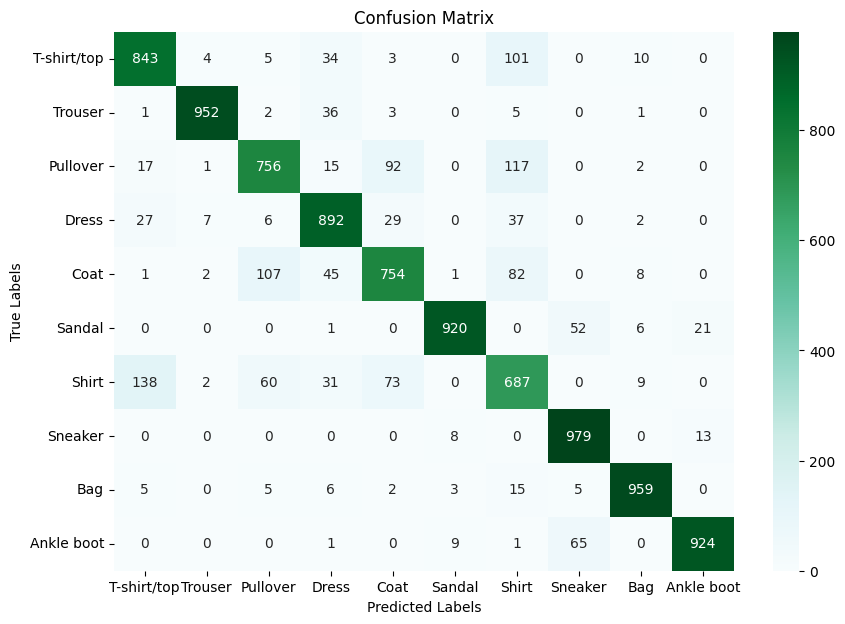

In [38]:
predictions = model.predict(x_test)
print(predictions[508])
true_labels = np.argmax(y_test_encode, axis=1)
print(true_labels[508])

# confusion matrix
conf_matrix = confusion_matrix(true_labels, predictions)

print("Confusion Matrix:")
print(conf_matrix)
plt.figure(figsize=(10,7))  # Adjust the size of the figure as needed
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="BuGn", cbar=True,
            xticklabels=class_names,  # Adjust these based on your classes
            yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()